# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    callsMade += 1
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0

# returns [{date: {open, close, high, low, volume}}]
# all data is normalized/adjusted according to splits and dividends
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parseAndAdjustPrice(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockSymbol)
    return stocks

### Parseando dados da API

In [3]:
def parseAndAdjustPrice(stocksRetrieved):
    stockPrices = {}
    splitFactor = 1.0
    dividendsFactor = 1.0
    i = 0
    
    for date in reversed(sorted(stocksRetrieved.keys())):
        # Calculando valores ajustados
        todayOpen = float(stocksRetrieved[date]['1. open']) * dividendsFactor / splitFactor
        todayHigh = float(stocksRetrieved[date]['2. high']) * dividendsFactor / splitFactor
        todayLow = float(stocksRetrieved[date]['3. low']) * dividendsFactor / splitFactor
        todayClose = float(stocksRetrieved[date]['4. close']) * dividendsFactor / splitFactor
        todayVolume = float(stocksRetrieved[date]['6. volume']) * splitFactor
        
#         # Analisando possível erro -- nao funciona por razões de arredondamento (api deve ter dados com mais casas decimais)
#         if (int(todayClose*10000) != int(float(stocksRetrieved[date]['5. adjusted close'])*10000)):
#             print('Adjusted values dont match: (calculated) ' + str(int(todayClose*10000)) + ' vs ' + str(int(float(stocksRetrieved[date]['5. adjusted close'])*10000)) + ' (api)')
#             print('Aborting operation')
#             raise Exception('Adjusted values dont match')
        
        stockPrices[date] = {
            'open': todayOpen,
            'close': todayClose,
            'high': todayHigh,
            'low': todayLow,
            'volume': todayVolume,
        }

        # Calculando fatores históricos de split e dividendos (que irão afetar datas antes da atual)
        if (i+1 < len(stocksRetrieved.keys())):
            yesterdayDate = list(reversed(sorted(stocksRetrieved.keys())))[i+1]
            yesterdayClose = float(stocksRetrieved[yesterdayDate]['4. close'])
            splitFactor *= float(stocksRetrieved[date]['8. split coefficient'])
            dividendsFactor *= (yesterdayClose-float(stocksRetrieved[date]['7. dividend amount']))/yesterdayClose
            i += 1
        
    print('Preço final normalizado (calculado): ' + str(stockPrices[sorted(stockPrices.keys())[0]]['close'])
         + ' | ' + sorted(stockPrices.keys())[0])
    print('Preço final normalizado (api): ' + str(stocksRetrieved[sorted(stocksRetrieved.keys())[0]]['5. adjusted close'])
         + ' | ' + sorted(stocksRetrieved.keys())[0])
        
    return stockPrices

# returns [{date: price}]
def simplifyStockPrices(stockPrices):
    stockPricesSimplified = {}
    for date, stockData in stockPrices.items():
        stockPricesSimplified[date] = stockData['open']
    return stockPricesSimplified

### Obtendo indicadores

In [4]:
from talib.abstract import *
import numpy as np

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, stockPrices):
    indicator = {}
    opens, highs, lows, closes, volumes = [], [], [], [], []
    
    for date in sorted(stockPrices.keys()):
        opens.append(stockPrices[date]['open'])
        highs.append(stockPrices[date]['high'])
        lows.append(stockPrices[date]['low'])
        closes.append(stockPrices[date]['close'])
        volumes.append(stockPrices[date]['volume'])
    
    inputs = {
        'open': np.array(opens),
        'high': np.array(highs),
        'low': np.array(lows),
        'close': np.array(closes),
        'volume': np.array(volumes)
    }
    
    if indicatorFunction=='SMA':
        indicatorList = SMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='EMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MACD':
        indicatorList, macdsignal, macdhist = MACD(inputs, fastperiod=12, slowperiod=26, signalperiod=9)
    elif indicatorFunction=='RSI':
        indicatorList = RSI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADX':
        indicatorList = ADX(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='CCI':
        indicatorList = CCI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MOM':
        indicatorList = MOM(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WILLR':
        indicatorList = WILLR(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='AD':
        indicatorList = AD(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADOSC':
        indicatorList = ADOSC(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='OBV':
        indicatorList = OBV(inputs, timeperiod=10, price='open')
    
    i = 0
    indicators = {}
    for date in sorted(stockPrices.keys()):
        indicators[date] = {indicatorFunction: indicatorList[i]}
        i += 1
        
    print('Calculated and parsed indicator ' + indicatorFunction)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, stockPrices):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, stockPrices)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [5]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(stocks, indicators, indicatorFunctions):
    filteredStocks = {date: stock for date, stock in stocks.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in stocks.keys()}
    return filteredStocks, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPricesDetailed = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockPricesDetailed)
    stockPrices, indicators = filterData(stockPricesDetailed, indicators, indicatorFunctions)
    return stockPricesDetailed, indicators

### Métodos de anotação de dados

In [6]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [7]:
import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stocks):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        # Normalizando baseado no preço
        if (indicatorFunction == 'SMA' or indicatorFunction == 'EMA'
            or indicatorFunction == 'ADX' or indicatorFunction == 'CCI' or indicatorFunction == 'MOM'
            or indicatorFunction == 'WILLR'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['close'])
        # Normalizando baseado no volume
        elif (indicatorFunction == 'AD' or indicatorFunction == 'ADOSC' or indicatorFunction == 'OBV'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['volume'])
        elif (indicatorFunction == 'MACD' or indicatorFunction == 'RSI'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/100.0
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stocks[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

### Machine Learning

In [8]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_steps*n_features*3, activation='relu', input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_steps*n_features*3, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


### Análise de dados

In [9]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return cm

### Main

In [10]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = {}
indicatorFunctions[3] = ['SMA','MOM','WILLR']
indicatorFunctions[6] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI']
indicatorFunctions[8] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI']
indicatorFunctions[11] = ['SMA','EMA','MACD','RSI','ADX','CCI','MOM','WILLR','AD','OBV','ADOSC']
stockSymbol = 'ORCL'

stocks, indicators = getData(stockSymbol, indicatorFunctions[11])
stockPrices = simplifyStockPrices(stocks)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY_ADJUSTED&symbol=ORCL
Preço final normalizado (calculado): 17.327397986855075 | 1999-12-07
Preço final normalizado (api): 17.3277 | 1999-12-07
Retrieved and parsed ORCL
Calculated and parsed indicator SMA
Calculated and parsed indicator EMA
Calculated and parsed indicator MACD
Calculated and parsed indicator RSI
Calculated and parsed indicator ADX
Calculated and parsed indicator CCI
Calculated and parsed indicator MOM
Calculated and parsed indicator WILLR
Calculated and parsed indicator AD
Calculated and parsed indicator OBV
Calculated and parsed indicator ADOSC


In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(stockPrices, orient='index')

In [12]:
df[0] = df[0].astype('float')

In [13]:
div = df[0].astype('float').div(df[0].astype('float').shift(-1))

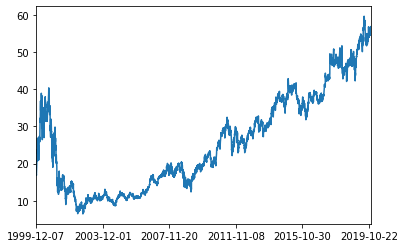

In [14]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

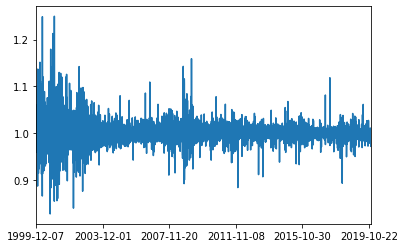

In [15]:
div.sort_index(inplace=True)
div.plot()

In [16]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5032.000000
mean        1.000539
std         0.024851
min         0.826964
1%          0.924791
10%         0.977824
25%         0.990550
50%         1.000470
75%         1.010411
90%         1.022479
95%         1.034534
99%         1.077599
max         1.249901
Name: 0, dtype: float64

In [17]:
div

1999-12-07         NaN
1999-12-08    1.002426
1999-12-09    0.981656
1999-12-10    1.031664
1999-12-13    1.056604
                ...   
2019-12-02    0.998225
2019-12-03    0.971368
2019-12-04    1.005126
2019-12-05    0.992714
2019-12-06    1.009725
Name: 0, Length: 5033, dtype: float64

In [18]:
dateAnnotated = {}

dateAnnotated[2] = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[2], orient='index')
df[0].value_counts()

S    2589
B    2443
Name: 0, dtype: int64

In [19]:
dateAnnotated[8] = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[8], orient='index')
df[0].value_counts()

S2    727
S0    703
B0    684
B2    641
B3    590
S1    581
S3    578
B1    528
Name: 0, dtype: int64

In [20]:
import pandas as pd

normalizedIndicators = {}
normalizedIndicators[2] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[2])
normalizedIndicators[8] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[8])

data = {}
data[2] = pd.DataFrame.from_dict(normalizedIndicators[2], orient='index')
data[8] = pd.DataFrame.from_dict(normalizedIndicators[8], orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [21]:
data[2] = pd.DataFrame.merge(pd.DataFrame(data[2].indicators.values.tolist(), index=data[2].index), data[2], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
data[8] = pd.DataFrame.merge(pd.DataFrame(data[8].indicators.values.tolist(), index=data[8].index), data[8], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [22]:
data[2].head(), data[8].head()

(                 SMA       EMA      MACD       RSI       ADX       CCI  \
 2019-12-06  1.017946  1.012264 -0.001219  0.410451  0.426876 -1.230044   
 2019-12-05  1.022915  1.016961 -0.000720  0.321355  0.416426 -1.972964   
 2019-12-04  1.031152  1.026530  0.000080  0.358116  0.378173 -3.000760   
 2019-12-03  1.030628  1.027027  0.001375  0.308264  0.332275 -4.726299   
 2019-12-02  1.018510  1.017258  0.002825  0.515420  0.288018 -3.565342   
 
                  MOM     WILLR          AD        OBV     ADOSC annotation  
 2019-12-06 -0.021703 -1.414020 -186.063886  94.837949 -1.272646          S  
 2019-12-05 -0.031456 -1.513359 -160.044437  80.782306 -1.261461          B  
 2019-12-04 -0.028855 -1.693549 -148.139251  75.494083 -1.375087          S  
 2019-12-03 -0.035538 -1.740175 -118.013396  59.493145 -1.016485          B  
 2019-12-02 -0.003067 -1.750320 -117.557526  60.520720 -0.820650          B  ,
                  SMA       EMA      MACD       RSI       ADX       CCI  \
 201

In [23]:
data[2].annotation = data[2].annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
data[8].annotation = data[8].annotation.apply(lambda x: eight_dict[x])

In [24]:
data[2] = data[2].sort_index()
data[8] = data[8].sort_index()

In [25]:
data[2] = data[2].dropna()
data[8] = data[8].dropna()

In [26]:
len(data[2]), len(data[8])

(5000, 5000)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

data_analysis = pd.DataFrame.merge(data[2], div, left_index=True, right_index=True, how='inner')
X = data_analysis.iloc[:,:8]
y = data_analysis.iloc[:,-1:]

In [28]:
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Specs     Score
2   MACD  1.729390
1    EMA  1.618102
0    SMA  1.402933
6    MOM  1.160041
3    RSI  1.032749
5    CCI  0.922461
7  WILLR  0.847902
4    ADX  0.740391


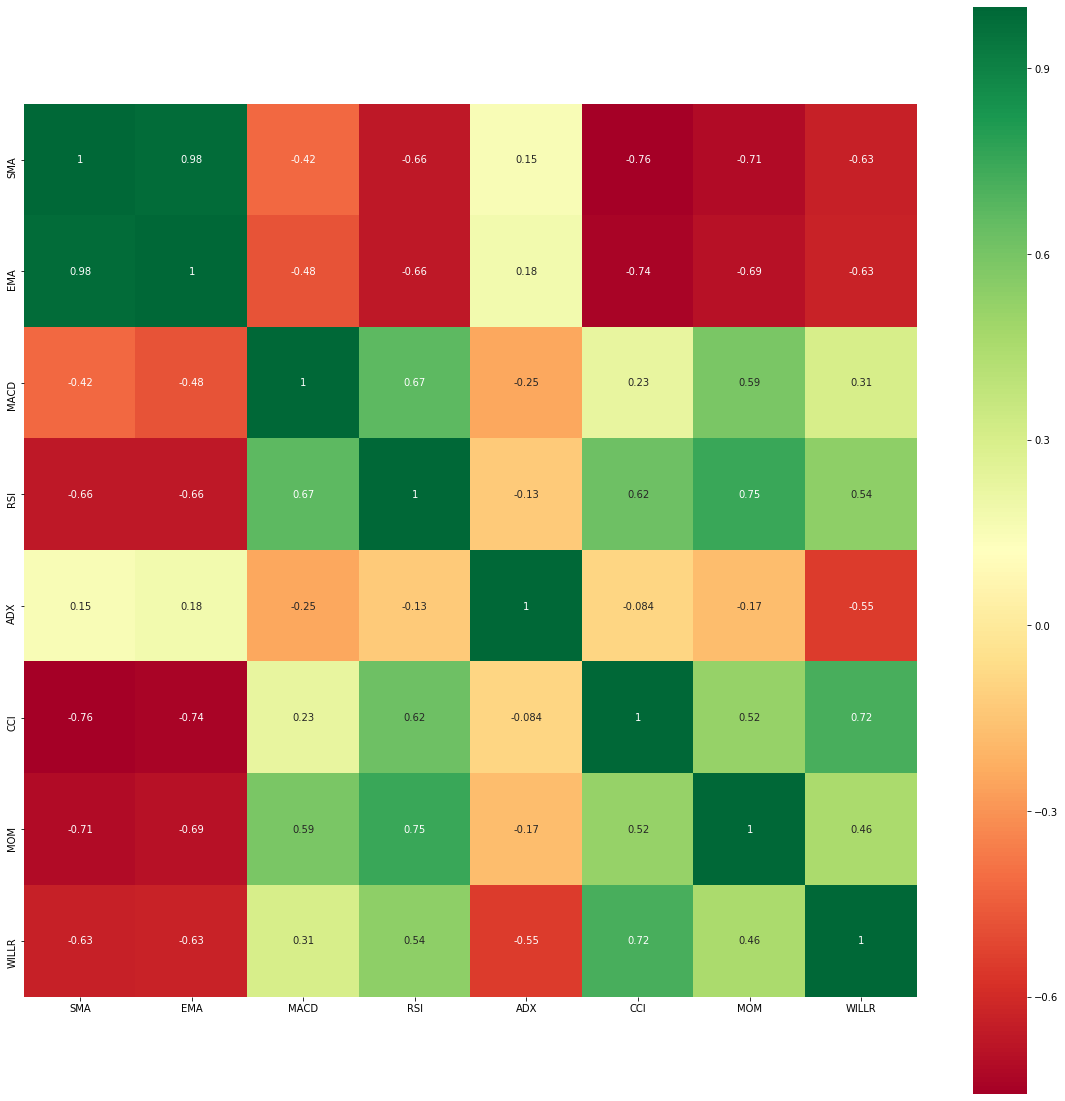

In [29]:
corrmat = data_analysis.iloc[:,:8].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.axis('scaled')
g=sns.heatmap(data_analysis[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
import numpy as np
import matplotlib.pyplot as plt

models = ["mlp","lstm"]
classes = {2: ["S","B"],
           8: ["B3","B2","B1","B0","S0","S1","S2","S3"]}
n_classes = [2, 8]
n_steps = [2,5,10]
n_indicators = [3, 6, 8, 11]
n_indicators_names = {
    3: ['SMA','MOM','WILLR'], 
    6: ['SMA','MOM','WILLR', 'MACD','ADX','RSI'],
    8: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI'],
    11: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI','AD','OBV','ADOSC']
}

batch_size = 32
train_split = .8

# X [d: (all, train, test)] [m: type(mlp/lstm)] [c: classes(2, 8)] [s: n_steps(2,5,10)] [i: indicators(3, 6)] 

In [31]:
X = {}
y = {}
for a in ["all", "train", "test"]:
    X[a] = {}
    y[a] = {}
    for m in models:
        X[a][m] = {}
        y[a][m] = {}
        for c in n_classes:
            X[a][m][c] = {}
            y[a][m][c] = {}
            for s in n_steps:
                X[a][m][c][s] = {}
                y[a][m][c][s] = {}
                for i in n_indicators:
                    X[a][m][c][s][i] = []
                    y[a][m][c][s][i] = []
                    if a == "all":
                        for d in range(len(data[c])):
                            end_ix = d + s
                            if end_ix > len(data[c]):
                                break
                            seq_x, seq_y = data[c].loc[data[c].index.isin(data[c].index[d:end_ix]), n_indicators_names[i]].values, data[c].iloc[end_ix-1, -1]
                            if m == "lstm":
                                X[a][m][c][s][i].append(seq_x)
                            else:
                                X[a][m][c][s][i].append(seq_x.flatten())
                            if c == 2:
                                y[a][m][c][s][i].append(seq_y)
                            else:
                                y[a][m][c][s][i].append(np.eye(c)[seq_y])
                        X[a][m][c][s][i] = np.array(X[a][m][c][s][i])
                        y[a][m][c][s][i] = np.array(y[a][m][c][s][i])

In [32]:
a = 'all'
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(4999, 6) (4999,)
(4999, 12) (4999,)
(4999, 16) (4999,)
(4999, 22) (4999,)
(4996, 15) (4996,)
(4996, 30) (4996,)
(4996, 40) (4996,)
(4996, 55) (4996,)
(4991, 30) (4991,)
(4991, 60) (4991,)
(4991, 80) (4991,)
(4991, 110) (4991,)
(4999, 6) (4999, 8)
(4999, 12) (4999, 8)
(4999, 16) (4999, 8)
(4999, 22) (4999, 8)
(4996, 15) (4996, 8)
(4996, 30) (4996, 8)
(4996, 40) (4996, 8)
(4996, 55) (4996, 8)
(4991, 30) (4991, 8)
(4991, 60) (4991, 8)
(4991, 80) (4991, 8)
(4991, 110) (4991, 8)
(4999, 2, 3) (4999,)
(4999, 2, 6) (4999,)
(4999, 2, 8) (4999,)
(4999, 2, 11) (4999,)
(4996, 5, 3) (4996,)
(4996, 5, 6) (4996,)
(4996, 5, 8) (4996,)
(4996, 5, 11) (4996,)
(4991, 10, 3) (4991,)
(4991, 10, 6) (4991,)
(4991, 10, 8) (4991,)
(4991, 10, 11) (4991,)
(4999, 2, 3) (4999, 8)
(4999, 2, 6) (4999, 8)
(4999, 2, 8) (4999, 8)
(4999, 2, 11) (4999, 8)
(4996, 5, 3) (4996, 8)
(4996, 5, 6) (4996, 8)
(4996, 5, 8) (4996, 8)
(4996, 5, 11) (4996, 8)
(4991, 10, 3) (4991, 8)
(4991, 10, 6) (4991, 8)
(4991, 10, 8) (4991, 8)
(49

In [33]:
data[2].head()

,SMA,EMA,MACD,RSI,ADX,CCI,MOM,WILLR,AD,OBV,ADOSC,annotation
2000-01-25,1.004766,1.003853,0.014889,0.510843,1.324681,0.435766,0.018781,-2.102785,1.723009,5.793691,-0.325395,1
2000-01-26,1.030766,1.029319,0.013515,0.546193,1.283274,0.505525,0.008173,-2.743348,0.952319,7.462345,-0.665689,0
2000-01-27,1.094769,1.090854,0.011151,0.522842,1.283161,-5.200081,-0.006562,-3.719189,0.283090,4.814161,-0.714016,1
2000-01-28,1.191325,1.173595,0.007626,0.429331,1.387706,-9.609473,-0.058041,-4.583156,-0.517457,2.402132,-0.743495,1
2000-01-31,1.116897,1.085312,0.005675,0.368795,1.303135,-6.271512,-0.131331,-3.556079,0.226735,2.045281,-0.699903,1


In [34]:
X["all"]["lstm"][2][5][6][0]

array([[ 1.00476612,  0.01878101, -2.10278476,  0.01488897,  1.32468085,
         0.51084325],
       [ 1.03076644,  0.0081729 , -2.74334842,  0.01351512,  1.28327367,
         0.54619335],
       [ 1.09476935, -0.00656244, -3.71918917,  0.01115102,  1.28316061,
         0.52284201],
       [ 1.19132545, -0.05804137, -4.58315554,  0.00762641,  1.38770606,
         0.42933069],
       [ 1.1168969 , -0.13133133, -3.55607939,  0.00567455,  1.30313471,
         0.36879531]])

In [35]:
X["all"]["mlp"][2][2][6][0]

array([ 1.00476612,  0.01878101, -2.10278476,  0.01488897,  1.32468085,
        0.51084325,  1.03076644,  0.0081729 , -2.74334842,  0.01351512,
        1.28327367,  0.54619335])

In [36]:
from sklearn.model_selection import train_test_split

for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                if m == "mlp":
                    X['train'][m][c][s][i], X['test'][m][c][s][i], y['train'][m][c][s][i], y['test'][m][c][s][i] = train_test_split(X['all'][m][c][s][i], y['all'][m][c][s][i], train_size=train_split, random_state=0)
                else:
                    X['train'][m][c][s][i] = X['all'][m][c][s][i][:int(len(X['all'][m][c][s][i])*train_split)]
                    X['test'][m][c][s][i] = X['all'][m][c][s][i][int(len(X['all'][m][c][s][i])*train_split):]
                    y['train'][m][c][s][i] = y['all'][m][c][s][i][:int(len(y['all'][m][c][s][i])*train_split)]
                    y['test'][m][c][s][i] = y['all'][m][c][s][i][int(len(y['all'][m][c][s][i])*train_split):]

In [37]:
for a in ['train','test']:
    for m in models:
        for c in n_classes:
            for s in n_steps:
                for i in n_indicators:
                    print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(3999, 6) (3999,)
(3999, 12) (3999,)
(3999, 16) (3999,)
(3999, 22) (3999,)
(3996, 15) (3996,)
(3996, 30) (3996,)
(3996, 40) (3996,)
(3996, 55) (3996,)
(3992, 30) (3992,)
(3992, 60) (3992,)
(3992, 80) (3992,)
(3992, 110) (3992,)
(3999, 6) (3999, 8)
(3999, 12) (3999, 8)
(3999, 16) (3999, 8)
(3999, 22) (3999, 8)
(3996, 15) (3996, 8)
(3996, 30) (3996, 8)
(3996, 40) (3996, 8)
(3996, 55) (3996, 8)
(3992, 30) (3992, 8)
(3992, 60) (3992, 8)
(3992, 80) (3992, 8)
(3992, 110) (3992, 8)
(3999, 2, 3) (3999,)
(3999, 2, 6) (3999,)
(3999, 2, 8) (3999,)
(3999, 2, 11) (3999,)
(3996, 5, 3) (3996,)
(3996, 5, 6) (3996,)
(3996, 5, 8) (3996,)
(3996, 5, 11) (3996,)
(3992, 10, 3) (3992,)
(3992, 10, 6) (3992,)
(3992, 10, 8) (3992,)
(3992, 10, 11) (3992,)
(3999, 2, 3) (3999, 8)
(3999, 2, 6) (3999, 8)
(3999, 2, 8) (3999, 8)
(3999, 2, 11) (3999, 8)
(3996, 5, 3) (3996, 8)
(3996, 5, 6) (3996, 8)
(3996, 5, 8) (3996, 8)
(3996, 5, 11) (3996, 8)
(3992, 10, 3) (3992, 8)
(3992, 10, 6) (3992, 8)
(3992, 10, 8) (3992, 8)
(39

In [38]:
Models = {}
for m in models:
    Models[m] = {}
    for c in n_classes:
        Models[m][c] = {}
        for s in n_steps:
            Models[m][c][s] = {}
            for i in n_indicators:
                Models[m][c][s][i] = {}
                if c == 2:
                    out = 1
                else:
                    out = c
                if m == "mlp":
                    Models[m][c][s][i] = getModelMLP(s, i, out)
                else:
                    Models[m][c][s][i] = getModelBidirectionalLSTM(s, i, out)

In [39]:
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(Models[m][c][s][i])

In [40]:
history = {}
preds = {}
conf = {}
for m in models:
    history[m] = {}
    preds[m] = {}
    conf[m] = {}
    for c in n_classes:
        history[m][c] = {}
        preds[m][c] = {}
        conf[m][c] = {}
        for s in n_steps:
            history[m][c][s] = {}
            preds[m][c][s] = {}
            conf[m][c][s] = {}
            for i in n_indicators:
                history[m][c][s][i] = {}
                preds[m][c][s][i] = {}
                conf[m][c][s][i] = {}

In [41]:
# Calculando lucro/prejuízo total, supondo que inicialmente temos US$1000 em carteira
import copy

def calculateOptimalProfit(preds):
    prices = copy.deepcopy(stockPrices)
    for date in sorted(stockPrices.keys()):
        if len(prices) == len(preds):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}
    
    for date in sorted(prices.keys())[:-1]:
        todayPrice = float(prices[date])
        tomorrowPrice = float(prices[sorted(prices.keys())[index+1]])
        if tomorrowPrice > todayPrice and currentMoney != 0:
            currentStocks = currentMoney/todayPrice
            currentMoney = 0
        elif tomorrowPrice < todayPrice and currentStocks != 0:
            currentMoney = currentStocks*todayPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*todayPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney
        
    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()

def calculateProfit(preds):
    
    if any(item in list(np.argmax(preds, axis=1)) for item in [2, 3, 4, 5, 6, 7]):
        classificationArray = list(np.argmax(preds, axis=1))
    else:
        classificationArray = []
        for predValue in preds:
            if predValue < 0.5:
                classificationArray.append(0)
            else:
                classificationArray.append(1)
    
    print(classificationArray)
    if (max(classificationArray) == 1):
        buyClassification = [0]
        sellClassification = [1]
        print("Using simple buy/sell (2 classes) classification")
    else:
        buyClassification = [0, 1, 2, 3]
        sellClassification = [4, 5, 6, 7]
        print("Using complex buy/sell (8 classes) classification")

    prices = copy.deepcopy(stockPrices)

    for date in sorted(stockPrices.keys()):
        if len(prices) == len(classificationArray):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}

    for date in sorted(prices.keys()):
        stockPrice = float(prices[date])
        classification = classificationArray[index]
        if currentMoney != 0 and classification in buyClassification:
            currentStocks = currentMoney/stockPrice
            currentMoney = 0.0
        elif currentStocks != 0 and classification in sellClassification:
            currentMoney = currentStocks*stockPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*stockPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney

    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
#     moneyGrowthPerYear = (finalMoney-initialMoney)/timeLenInYears
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)

#     print("[DEBUG] Current money:\t   US$ " + str(round(currentMoney, 2)))
#     print("[DEBUG] Current stocks:\t   " + str(round(currentStocks, 2)) + "\t| Last stock-price: US$ " + str(round(lastPrice, 2)))
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()
#     pricesDf = pd.DataFrame.from_dict(prices, orient='index')
#     pricesDf.sort_index(inplace=True)
#     pricesDf[0].astype('float').plot(ax=graphAx)

In [42]:
def fit(m, c, s, i):
    history[m][c][s][i] = Models[m][c][s][i].fit(
        X['train'][m][c][s][i], 
        y['train'][m][c][s][i], 
        epochs=300, 
        verbose=1,
        batch_size=batch_size)
    plt.plot(history[m][c][s][i].history['loss'], label='train')
#     plt.plot(history[m][c][s][i].history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(m, c, s, i):
    preds[m][c][s][i] = Models[m][c][s][i].predict(
        X['test'][m][c][s][i], 
        batch_size=batch_size)
    print(f"Model {m}\nNumber of classes {c}\nNumber of steps {s}\nNumber of indicators {i}")
    print(classification_report(y['test'][m][c][s][i], 
                                np.rint(preds[m][c][s][i]).astype(np.int64), 
                                target_names=classes[c], 
                                digits=5))
    if c == 2:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i], 
                                                 np.rint(preds[m][c][s][i]).astype(np.int64), 
                                                 classes=np.array(classes[c]))
    else:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i].argmax(axis=1), 
                                                 np.rint(preds[m][c][s][i]).argmax(axis=1), 
                                                 classes=np.array(classes[c]))
        
def get_next_value(m, c, s, i):
    i = n_indicators[(n_indicators.index(i) + 1)%len(n_indicators)]
    if (n_indicators.index(i) == 0):
        s = n_steps[(n_steps.index(s) + 1)%len(n_steps)]
        if (n_steps.index(s) == 0):
            c = n_classes[(n_classes.index(c) + 1)%len(n_classes)]
            if (n_classes.index(c) == 0):
                m = models[(models.index(m) + 1)%len(models)]    
    return m, c, s, i

In [43]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

for x in range(48):
    Models[m][c][s][i].summary()
    m, c, s, i = get_next_value(m, c, s, i)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Outpu

dense_54 (Dense)             (None, 8)                 488       
Total params: 6,008
Trainable params: 6,008
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 80)                3280      
_________________________________________________________________
dropout_37 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 80)                6480      
_________________________________________________________________
dropout_38 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 648       
Total params: 10,408
Trainable params: 10,408
Non-t

bidirectional_8 (Bidirection (None, 330)               233640    
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 331       
Total params: 233,971
Trainable params: 233,971
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 180)               67680     
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 181       
Total params: 67,861
Trainable params: 67,861
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bi

Epoch 1/300
3999/3999 [==============================] - 2s 521us/step - loss: 0.7335 - accuracy: 0.5139
Epoch 2/300
3999/3999 [==============================] - 1s 140us/step - loss: 0.6925 - accuracy: 0.5731
Epoch 3/300
3999/3999 [==============================] - 1s 163us/step - loss: 0.6848 - accuracy: 0.5776
Epoch 4/300
3999/3999 [==============================] - 1s 197us/step - loss: 0.6769 - accuracy: 0.5826
Epoch 5/300
3999/3999 [==============================] - 1s 130us/step - loss: 0.6724 - accuracy: 0.5889
Epoch 6/300
3999/3999 [==============================] - 1s 151us/step - loss: 0.6675 - accuracy: 0.6027
Epoch 7/300
3999/3999 [==============================] - 1s 160us/step - loss: 0.6659 - accuracy: 0.6019
Epoch 8/300
3999/3999 [==============================] - 1s 162us/step - loss: 0.6588 - accuracy: 0.6132
Epoch 9/300
3999/3999 [==============================] - 1s 160us/step - loss: 0.6616 - accuracy: 0.61290s - loss: 0.6627 - accuracy
Epoch 10/300
3999/3999 [===

3999/3999 [==============================] - 1s 171us/step - loss: 0.5530 - accuracy: 0.7347
Epoch 77/300
3999/3999 [==============================] - 1s 160us/step - loss: 0.5491 - accuracy: 0.7304
Epoch 78/300
3999/3999 [==============================] - 1s 140us/step - loss: 0.5479 - accuracy: 0.7357
Epoch 79/300
3999/3999 [==============================] - 1s 141us/step - loss: 0.5519 - accuracy: 0.7362
Epoch 80/300
3999/3999 [==============================] - 1s 143us/step - loss: 0.5463 - accuracy: 0.7339
Epoch 81/300
3999/3999 [==============================] - 1s 166us/step - loss: 0.5514 - accuracy: 0.7357
Epoch 82/300
3999/3999 [==============================] - 1s 130us/step - loss: 0.5516 - accuracy: 0.7299
Epoch 83/300
3999/3999 [==============================] - 1s 157us/step - loss: 0.5451 - accuracy: 0.7324
Epoch 84/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.5517 - accuracy: 0.7342
Epoch 85/300
3999/3999 [==============================] - 0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 368us/step - loss: 0.5470 - accuracy: 0.7404
Epoch 126/300
3999/3999 [==============================] - 1s 350us/step - loss: 0.5414 - accuracy: 0.7339
Epoch 127/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.5425 - accuracy: 0.7362
Epoch 128/300
3999/3999 [==============================] - 1s 186us/step - loss: 0.5443 - accuracy: 0.7404
Epoch 129/300
3999/3999 [==============================] - 1s 230us/step - loss: 0.5399 - accuracy: 0.7434
Epoch 130/300
3999/3999 [==============================] - 1s 217us/step - loss: 0.5431 - accuracy: 0.7344
Epoch 131/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.5488 - accuracy: 0.7409
Epoch 132/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.5447 - accuracy: 0.7374
Epoch 133/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.5526 - accuracy: 0.7354
Epoch 134/300
3999/3999 [===========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 370us/step - loss: 0.5438 - accuracy: 0.7414
Epoch 138/300
3999/3999 [==============================] - 1s 226us/step - loss: 0.5479 - accuracy: 0.7419
Epoch 139/300
3999/3999 [==============================] - 1s 263us/step - loss: 0.5433 - accuracy: 0.7409
Epoch 140/300
3999/3999 [==============================] - 1s 244us/step - loss: 0.5365 - accuracy: 0.7467
Epoch 141/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.5427 - accuracy: 0.7349
Epoch 142/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.5411 - accuracy: 0.7472
Epoch 143/300
3999/3999 [==============================] - 2s 437us/step - loss: 0.5386 - accuracy: 0.7437
Epoch 144/300
3999/3999 [==============================] - 1s 352us/step - loss: 0.5444 - accuracy: 0.7419
Epoch 145/300
3999/3999 [==============================] - 1s 292us/step - loss: 0.5453 - accuracy: 0.7482
Epoch 146/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 220us/step - loss: 0.5424 - accuracy: 0.73890s - loss: 0.5423 - accuracy: 0.
Epoch 162/300
3999/3999 [==============================] - 1s 325us/step - loss: 0.5336 - accuracy: 0.7497
Epoch 163/300
3999/3999 [==============================] - 2s 439us/step - loss: 0.5439 - accuracy: 0.7412
Epoch 164/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.5433 - accuracy: 0.7414
Epoch 165/300
3999/3999 [==============================] - 1s 251us/step - loss: 0.5396 - accuracy: 0.7372
Epoch 166/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.5416 - accuracy: 0.7427
Epoch 167/300
3999/3999 [==============================] - 1s 302us/step - loss: 0.5355 - accuracy: 0.7457
Epoch 168/300
3999/3999 [==============================] - 1s 294us/step - loss: 0.5398 - accuracy: 0.7417
Epoch 169/300
3999/3999 [==============================] - 2s 560us/step - loss: 0.5406 - accuracy: 0.7419
Epoch 170/300
3999/

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 331us/step - loss: 0.5443 - accuracy: 0.7447
Epoch 174/300
3999/3999 [==============================] - 2s 452us/step - loss: 0.5393 - accuracy: 0.73940s
Epoch 175/300
3999/3999 [==============================] - 1s 287us/step - loss: 0.5426 - accuracy: 0.7452
Epoch 176/300
3999/3999 [==============================] - 1s 320us/step - loss: 0.5406 - accuracy: 0.7359
Epoch 177/300
3999/3999 [==============================] - 2s 464us/step - loss: 0.5407 - accuracy: 0.74641s - l
Epoch 178/300
3999/3999 [==============================] - 1s 276us/step - loss: 0.5447 - accuracy: 0.7402
Epoch 179/300
3999/3999 [==============================] - 1s 195us/step - loss: 0.5398 - accuracy: 0.7404
Epoch 180/300
3999/3999 [==============================] - 1s 350us/step - loss: 0.5398 - accuracy: 0.7394
Epoch 181/300
1280/3999 [========>.....................] - ETA: 0s - loss: 0.5238 - accuracy: 0.7531

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 225us/step - loss: 0.5353 - accuracy: 0.7454
Epoch 182/300
3999/3999 [==============================] - 1s 190us/step - loss: 0.5392 - accuracy: 0.7392
Epoch 183/300
3999/3999 [==============================] - 1s 245us/step - loss: 0.5412 - accuracy: 0.7424
Epoch 184/300
3999/3999 [==============================] - 1s 196us/step - loss: 0.5375 - accuracy: 0.73640s - loss: 0.5407 - ac
Epoch 185/300
3999/3999 [==============================] - 2s 494us/step - loss: 0.5376 - accuracy: 0.7447
Epoch 186/300
3999/3999 [==============================] - 1s 374us/step - loss: 0.5360 - accuracy: 0.7462
Epoch 187/300
3999/3999 [==============================] - 2s 448us/step - loss: 0.5394 - accuracy: 0.7409
Epoch 188/300
3999/3999 [==============================] - 1s 364us/step - loss: 0.5445 - accuracy: 0.73640s - loss: 0.5424 - accura
Epoch 189/300
3999/3999 [==============================] - 2s 382us/step - loss: 0.5409 - accuracy: 0.7397
Epo

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 356us/step - loss: 0.5353 - accuracy: 0.7464
Epoch 212/300
3999/3999 [==============================] - 1s 365us/step - loss: 0.5398 - accuracy: 0.7464
Epoch 213/300
3999/3999 [==============================] - 1s 244us/step - loss: 0.5360 - accuracy: 0.7457
Epoch 214/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.5357 - accuracy: 0.7427
Epoch 215/300
3999/3999 [==============================] - 1s 341us/step - loss: 0.5333 - accuracy: 0.7482
Epoch 216/300
3999/3999 [==============================] - 1s 307us/step - loss: 0.5350 - accuracy: 0.7457
Epoch 217/300
3999/3999 [==============================] - 1s 266us/step - loss: 0.5421 - accuracy: 0.7409
Epoch 218/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.5442 - accuracy: 0.7367
Epoch 219/300
3999/3999 [==============================] - 1s 315us/step - loss: 0.5368 - accuracy: 0.7404
Epoch 220/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 338us/step - loss: 0.5392 - accuracy: 0.7429
Epoch 236/300
3999/3999 [==============================] - 1s 288us/step - loss: 0.5376 - accuracy: 0.7467
Epoch 237/300
3999/3999 [==============================] - 1s 333us/step - loss: 0.5404 - accuracy: 0.7457
Epoch 238/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.5458 - accuracy: 0.7414
Epoch 239/300
3999/3999 [==============================] - 1s 278us/step - loss: 0.5406 - accuracy: 0.7434
Epoch 240/300
3999/3999 [==============================] - 1s 287us/step - loss: 0.5344 - accuracy: 0.7427
Epoch 241/300
3999/3999 [==============================] - 1s 364us/step - loss: 0.5394 - accuracy: 0.7422
Epoch 242/300
3999/3999 [==============================] - 1s 282us/step - loss: 0.5361 - accuracy: 0.7444
Epoch 243/300
3999/3999 [==============================] - 1s 352us/step - loss: 0.5392 - accuracy: 0.7387
Epoch 244/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 283us/step - loss: 0.5398 - accuracy: 0.7492
Epoch 269/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.5383 - accuracy: 0.7457
Epoch 270/300
3999/3999 [==============================] - 1s 327us/step - loss: 0.5300 - accuracy: 0.7392
Epoch 271/300
3999/3999 [==============================] - 1s 293us/step - loss: 0.5450 - accuracy: 0.7364
Epoch 272/300
3999/3999 [==============================] - 1s 359us/step - loss: 0.5368 - accuracy: 0.74090s - loss: 0.5354 - accuracy: 
Epoch 273/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.5377 - accuracy: 0.73870s - loss: 0.5557 - accuracy: 0. - ETA: 0s - loss: 0.552
Epoch 274/300
3999/3999 [==============================] - 1s 330us/step - loss: 0.5365 - accuracy: 0.74340s - loss: 0.563
Epoch 275/300
3999/3999 [==============================] - 1s 285us/step - loss: 0.5346 - accuracy: 0.7432
Epoch 276/300
3999/3999 [==============================]

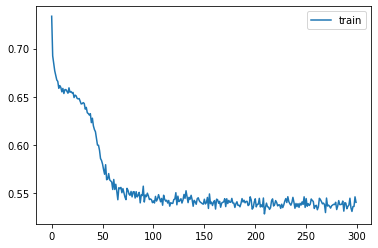

In [44]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.78333   0.76113   0.77207       494
           B    0.77308   0.79447   0.78363       506

    accuracy                        0.77800      1000
   macro avg    0.77821   0.77780   0.77785      1000
weighted avg    0.77814   0.77800   0.77792      1000

Confusion matrix, without normalization
[[376 118]
 [104 402]]


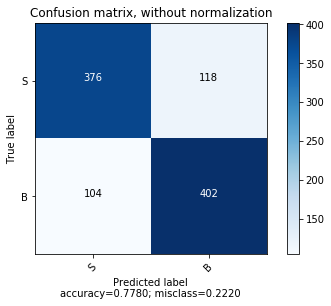

[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 

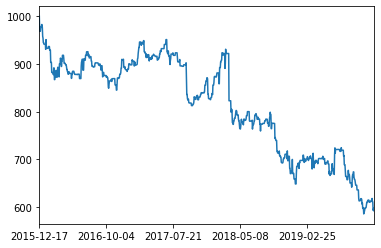

In [45]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 448us/step - loss: 0.6711 - accuracy: 0.6087
Epoch 2/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.6585 - accuracy: 0.6209
Epoch 3/300
3999/3999 [==============================] - 0s 124us/step - loss: 0.6543 - accuracy: 0.6312
Epoch 4/300
3999/3999 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.62 - 1s 127us/step - loss: 0.6492 - accuracy: 0.6304
Epoch 5/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.6484 - accuracy: 0.6399
Epoch 6/300
3999/3999 [==============================] - 0s 122us/step - loss: 0.6415 - accuracy: 0.6474
Epoch 7/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.6420 - accuracy: 0.6402
Epoch 8/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.6371 - accuracy: 0.6484
Epoch 9/300
3999/3999 [==============================] - 1s 140us/step - loss: 0.6304 - accuracy: 0.6559
Epoch 10/300


3999/3999 [==============================] - 1s 133us/step - loss: 0.1704 - accuracy: 0.9332
Epoch 78/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.1641 - accuracy: 0.9315
Epoch 79/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.1541 - accuracy: 0.9375
Epoch 80/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.1605 - accuracy: 0.9372
Epoch 81/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1553 - accuracy: 0.9387
Epoch 82/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.1652 - accuracy: 0.9302
Epoch 83/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.1622 - accuracy: 0.9327
Epoch 84/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.1612 - accuracy: 0.9380
Epoch 85/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.1536 - accuracy: 0.9377
Epoch 86/300
3999/3999 [==============================] - 0s

3999/3999 [==============================] - 1s 131us/step - loss: 0.1411 - accuracy: 0.9407
Epoch 154/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.1405 - accuracy: 0.9417
Epoch 155/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.1269 - accuracy: 0.9472
Epoch 156/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.1144 - accuracy: 0.9540
Epoch 157/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.1264 - accuracy: 0.9490
Epoch 158/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1124 - accuracy: 0.9520
Epoch 159/300
3999/3999 [==============================] - 1s 133us/step - loss: 0.1082 - accuracy: 0.95770s - loss: 0.1410 
Epoch 160/300
3999/3999 [==============================] - 1s 165us/step - loss: 0.1057 - accuracy: 0.9562
Epoch 161/300
3999/3999 [==============================] - 1s 171us/step - loss: 0.1079 - accuracy: 0.9580
Epoch 162/300
3999/3999 [========

3999/3999 [==============================] - 0s 112us/step - loss: 0.1007 - accuracy: 0.9570
Epoch 229/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.1078 - accuracy: 0.9572
Epoch 230/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.0974 - accuracy: 0.9597
Epoch 231/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.0922 - accuracy: 0.9622
Epoch 232/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1054 - accuracy: 0.9570
Epoch 233/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.1368 - accuracy: 0.9455
Epoch 234/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.1041 - accuracy: 0.9557
Epoch 235/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.1197 - accuracy: 0.9520
Epoch 236/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.0964 - accuracy: 0.9615
Epoch 237/300
3999/3999 [==========================

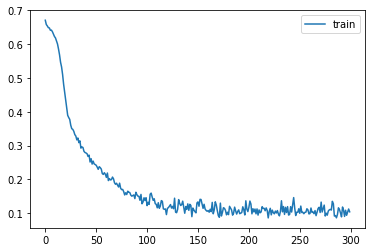

In [46]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.97211   0.98785   0.97992       494
           B    0.98795   0.97233   0.98008       506

    accuracy                        0.98000      1000
   macro avg    0.98003   0.98009   0.98000      1000
weighted avg    0.98013   0.98000   0.98000      1000

Confusion matrix, without normalization
[[488   6]
 [ 14 492]]


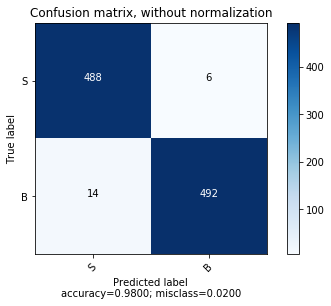

[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 

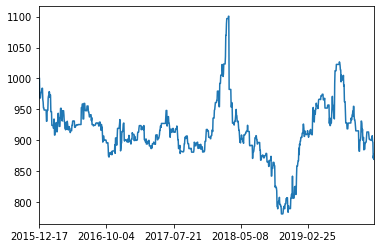

In [47]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 402us/step - loss: 0.6550 - accuracy: 0.6372
Epoch 2/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.5973 - accuracy: 0.6947
Epoch 3/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.5812 - accuracy: 0.7107
Epoch 4/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.5620 - accuracy: 0.7237
Epoch 5/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.5449 - accuracy: 0.7422
Epoch 6/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.5277 - accuracy: 0.7589
Epoch 7/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.5253 - accuracy: 0.7549
Epoch 8/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.5156 - accuracy: 0.7537
Epoch 9/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.5017 - accuracy: 0.7719
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 0s 105us/step - loss: 0.2528 - accuracy: 0.8957
Epoch 79/300
3999/3999 [==============================] - 0s 93us/step - loss: 0.2671 - accuracy: 0.8915
Epoch 80/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.2581 - accuracy: 0.8967
Epoch 81/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.2578 - accuracy: 0.8945
Epoch 82/300
3999/3999 [==============================] - 0s 91us/step - loss: 0.2650 - accuracy: 0.8927
Epoch 83/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.2467 - accuracy: 0.8965
Epoch 84/300
3999/3999 [==============================] - 0s 85us/step - loss: 0.2581 - accuracy: 0.8910
Epoch 85/300
3999/3999 [==============================] - 0s 95us/step - loss: 0.2442 - accuracy: 0.9027
Epoch 86/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.2400 - accuracy: 0.9007
Epoch 87/300
3999/3999 [==============================] - 0s 95us

3999/3999 [==============================] - 0s 111us/step - loss: 0.1673 - accuracy: 0.9300
Epoch 155/300
3999/3999 [==============================] - 0s 122us/step - loss: 0.1497 - accuracy: 0.9412
Epoch 156/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.1698 - accuracy: 0.9322
Epoch 157/300
3999/3999 [==============================] - 1s 140us/step - loss: 0.1615 - accuracy: 0.9365
Epoch 158/300
3999/3999 [==============================] - 1s 139us/step - loss: 0.1581 - accuracy: 0.9320
Epoch 159/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.1559 - accuracy: 0.9385
Epoch 160/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.1602 - accuracy: 0.9407
Epoch 161/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.1587 - accuracy: 0.9367
Epoch 162/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.1631 - accuracy: 0.9360
Epoch 163/300
3999/3999 [===========================

3999/3999 [==============================] - 0s 117us/step - loss: 0.1392 - accuracy: 0.9422
Epoch 231/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1482 - accuracy: 0.9370
Epoch 232/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.1367 - accuracy: 0.9395
Epoch 233/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.1694 - accuracy: 0.9320
Epoch 234/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.1718 - accuracy: 0.92520s - loss: 0.1691 - accuracy: 
Epoch 235/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.1637 - accuracy: 0.9320
Epoch 236/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.1548 - accuracy: 0.9362
Epoch 237/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.1400 - accuracy: 0.9440
Epoch 238/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.1235 - accuracy: 0.9525
Epoch 239/300
3999/39

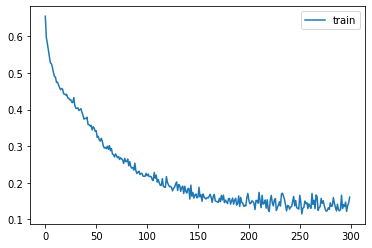

In [48]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.95210   0.96559   0.95879       494
           B    0.96593   0.95257   0.95920       506

    accuracy                        0.95900      1000
   macro avg    0.95901   0.95908   0.95900      1000
weighted avg    0.95910   0.95900   0.95900      1000

Confusion matrix, without normalization
[[477  17]
 [ 24 482]]


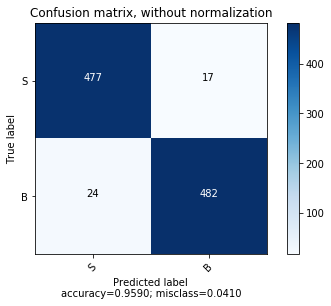

[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 

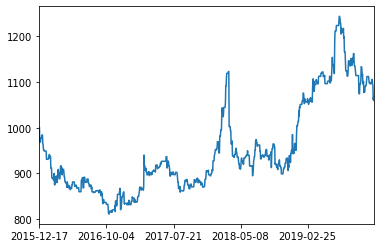

In [49]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 355us/step - loss: 1.3360 - accuracy: 0.5451
Epoch 2/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.6993 - accuracy: 0.5749
Epoch 3/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.6782 - accuracy: 0.5934
Epoch 4/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.6742 - accuracy: 0.5879
Epoch 5/300
3999/3999 [==============================] - 1s 138us/step - loss: 0.6576 - accuracy: 0.6129
Epoch 6/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.6583 - accuracy: 0.6107
Epoch 7/300
3999/3999 [==============================] - 1s 144us/step - loss: 0.6532 - accuracy: 0.6224
Epoch 8/300
3999/3999 [==============================] - 1s 130us/step - loss: 0.6451 - accuracy: 0.6289
Epoch 9/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.6379 - accuracy: 0.6422
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 0s 111us/step - loss: 0.4568 - accuracy: 0.7877
Epoch 78/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.4528 - accuracy: 0.7934
Epoch 79/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.4542 - accuracy: 0.7874
Epoch 80/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.4424 - accuracy: 0.7952
Epoch 81/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.4418 - accuracy: 0.8000
Epoch 82/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.4406 - accuracy: 0.8020
Epoch 83/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.4408 - accuracy: 0.7924
Epoch 84/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.4487 - accuracy: 0.7934
Epoch 85/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.4388 - accuracy: 0.8010
Epoch 86/300
3999/3999 [==============================] - 0

3999/3999 [==============================] - 1s 131us/step - loss: 0.3947 - accuracy: 0.8250
Epoch 154/300
3999/3999 [==============================] - 1s 137us/step - loss: 0.3953 - accuracy: 0.8295
Epoch 155/300
3999/3999 [==============================] - 1s 151us/step - loss: 0.4026 - accuracy: 0.8222
Epoch 156/300
3999/3999 [==============================] - 1s 197us/step - loss: 0.3967 - accuracy: 0.8280
Epoch 157/300
3999/3999 [==============================] - 1s 149us/step - loss: 0.4079 - accuracy: 0.8215
Epoch 158/300
3999/3999 [==============================] - 1s 160us/step - loss: 0.3968 - accuracy: 0.8282
Epoch 159/300
3999/3999 [==============================] - 1s 174us/step - loss: 0.3983 - accuracy: 0.82450s - loss: 0
Epoch 160/300
3999/3999 [==============================] - 1s 144us/step - loss: 0.4066 - accuracy: 0.8177
Epoch 161/300
3999/3999 [==============================] - 1s 156us/step - loss: 0.3984 - accuracy: 0.8247
Epoch 162/300
3999/3999 [==============

3999/3999 [==============================] - 0s 112us/step - loss: 0.3645 - accuracy: 0.8435
Epoch 228/300
3999/3999 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.83 - 0s 116us/step - loss: 0.3682 - accuracy: 0.8375
Epoch 229/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.3730 - accuracy: 0.8397
Epoch 230/300
3999/3999 [==============================] - 1s 130us/step - loss: 0.3760 - accuracy: 0.8437
Epoch 231/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.3653 - accuracy: 0.8450
Epoch 232/300
3999/3999 [==============================] - 1s 147us/step - loss: 0.3590 - accuracy: 0.8417
Epoch 233/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.3768 - accuracy: 0.8330
Epoch 234/300
3999/3999 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.84 - 0s 117us/step - loss: 0.3565 - accuracy: 0.8430
Epoch 235/300
3999/3999 [==============================] - 1s 130us/step -

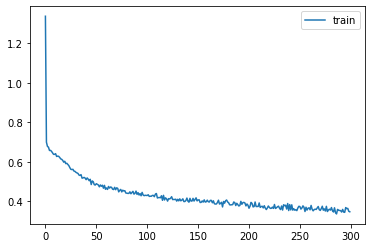

In [50]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.91284   0.80567   0.85591       494
           B    0.82979   0.92490   0.87477       506

    accuracy                        0.86600      1000
   macro avg    0.87132   0.86528   0.86534      1000
weighted avg    0.87082   0.86600   0.86545      1000

Confusion matrix, without normalization
[[398  96]
 [ 38 468]]


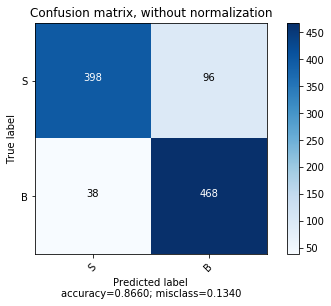

First date:	   2015-12-18	| Initial stock value: US$ 35.72353041982023
Last date:	   2019-12-06	| Final stock value: US$ 55.03
Stock value growth:	54.04%
[DEBUG] Initial money:    US$ 1000.0 | Final money: US$ 109449.62
[DEBUG] Final profit:	   US$ 108449.62 over 3.97 years
Money growth:      	10844.96%
Growth per year:   	226.5%
[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1

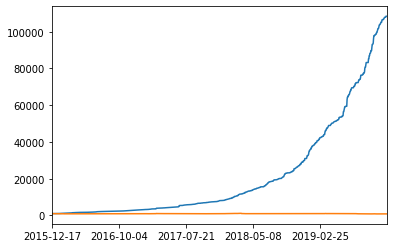

In [51]:
predict(m, c, s, i)
calculateOptimalProfit(preds[m][c][s][i])
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 411us/step - loss: 0.6289 - accuracy: 0.6504
Epoch 2/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.5615 - accuracy: 0.7147
Epoch 3/300
3996/3996 [==============================] - 1s 130us/step - loss: 0.5470 - accuracy: 0.7347
Epoch 4/300
3996/3996 [==============================] - 0s 122us/step - loss: 0.5360 - accuracy: 0.7375
Epoch 5/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.5312 - accuracy: 0.7465
Epoch 6/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.5331 - accuracy: 0.7510
Epoch 7/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.5274 - accuracy: 0.7455
Epoch 8/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.5255 - accuracy: 0.7495
Epoch 9/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.5193 - accuracy: 0.7563
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 105us/step - loss: 0.4667 - accuracy: 0.78180s - loss: 0.4715 - accuracy: 0.
Epoch 79/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.4687 - accuracy: 0.7840
Epoch 80/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.4695 - accuracy: 0.7828
Epoch 81/300
3996/3996 [==============================] - 0s 85us/step - loss: 0.4738 - accuracy: 0.7743
Epoch 82/300
3996/3996 [==============================] - 0s 87us/step - loss: 0.4701 - accuracy: 0.7768
Epoch 83/300
3996/3996 [==============================] - 0s 93us/step - loss: 0.4675 - accuracy: 0.7843
Epoch 84/300
3996/3996 [==============================] - 0s 98us/step - loss: 0.4703 - accuracy: 0.7835
Epoch 85/300
3996/3996 [==============================] - 0s 85us/step - loss: 0.4639 - accuracy: 0.7780
Epoch 86/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.4739 - accuracy: 0.7768
Epoch 87/300
3996/3996 [=========

3996/3996 [==============================] - 0s 106us/step - loss: 0.4498 - accuracy: 0.7948
Epoch 155/300
3996/3996 [==============================] - 0s 93us/step - loss: 0.4488 - accuracy: 0.8013
Epoch 156/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.4476 - accuracy: 0.7885
Epoch 157/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.4477 - accuracy: 0.7910
Epoch 158/300
3996/3996 [==============================] - 0s 90us/step - loss: 0.4504 - accuracy: 0.7908
Epoch 159/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.4466 - accuracy: 0.7890
Epoch 160/300
3996/3996 [==============================] - 0s 97us/step - loss: 0.4460 - accuracy: 0.7945
Epoch 161/300
3996/3996 [==============================] - 0s 98us/step - loss: 0.4410 - accuracy: 0.7983
Epoch 162/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.4480 - accuracy: 0.7928
Epoch 163/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 131us/step - loss: 0.4392 - accuracy: 0.7945
Epoch 230/300
3996/3996 [==============================] - 1s 191us/step - loss: 0.4378 - accuracy: 0.79500s - loss: 0.4358 - 
Epoch 231/300
3996/3996 [==============================] - 1s 126us/step - loss: 0.4370 - accuracy: 0.8006
Epoch 232/300
3996/3996 [==============================] - 1s 147us/step - loss: 0.4428 - accuracy: 0.7943
Epoch 233/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.4430 - accuracy: 0.7975
Epoch 234/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.4427 - accuracy: 0.7950
Epoch 235/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.4384 - accuracy: 0.7953
Epoch 236/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4445 - accuracy: 0.79930s - loss: 0.4429 - accuracy: 0.
Epoch 237/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4509 - accuracy: 0.7900

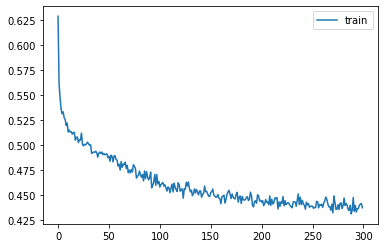

In [52]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.82402   0.77583   0.79920       513
           B    0.77756   0.82546   0.80080       487

    accuracy                        0.80000      1000
   macro avg    0.80079   0.80065   0.80000      1000
weighted avg    0.80139   0.80000   0.79998      1000

Confusion matrix, without normalization
[[398 115]
 [ 85 402]]


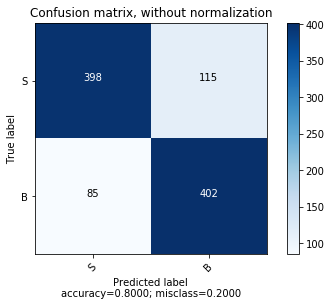

[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 

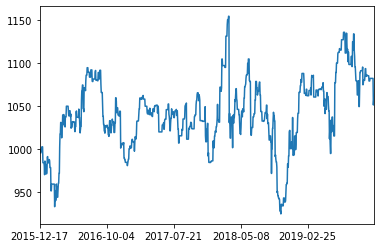

In [53]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.6035 - accuracy: 0.6819
Epoch 2/300
3996/3996 [==============================] - 1s 320us/step - loss: 0.5368 - accuracy: 0.7337
Epoch 3/300
3996/3996 [==============================] - 1s 316us/step - loss: 0.5126 - accuracy: 0.7538
Epoch 4/300
3996/3996 [==============================] - 1s 372us/step - loss: 0.5116 - accuracy: 0.7530
Epoch 5/300
3996/3996 [==============================] - 1s 285us/step - loss: 0.5065 - accuracy: 0.7528
Epoch 6/300
3996/3996 [==============================] - 1s 269us/step - loss: 0.4934 - accuracy: 0.7723
Epoch 7/300
3996/3996 [==============================] - 1s 319us/step - loss: 0.4975 - accuracy: 0.7678
Epoch 8/300
3996/3996 [==============================] - 1s 350us/step - loss: 0.4912 - accuracy: 0.7678
Epoch 9/300
3996/3996 [==============================] - 1s 298us/step - loss: 0.4814 - accuracy: 0.7760
Epoch 10/300
3996/3996 [==============================] -

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 353us/step - loss: 0.2945 - accuracy: 0.8719
Epoch 49/300
3996/3996 [==============================] - 1s 238us/step - loss: 0.2913 - accuracy: 0.8719
Epoch 50/300
 672/3996 [====>.........................] - ETA: 1s - loss: 0.2751 - accuracy: 0.8765

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 301us/step - loss: 0.2746 - accuracy: 0.8831
Epoch 51/300
3996/3996 [==============================] - 1s 302us/step - loss: 0.2789 - accuracy: 0.87940s - loss: 0.2817 - accuracy: 0.87
Epoch 52/300
3996/3996 [==============================] - 1s 251us/step - loss: 0.2769 - accuracy: 0.8804
Epoch 53/300
3996/3996 [==============================] - 1s 259us/step - loss: 0.2785 - accuracy: 0.8789
Epoch 54/300
3996/3996 [==============================] - 1s 288us/step - loss: 0.2829 - accuracy: 0.8799
Epoch 55/300
3996/3996 [==============================] - 1s 249us/step - loss: 0.2642 - accuracy: 0.8844
Epoch 56/300
3996/3996 [==============================] - 1s 273us/step - loss: 0.2625 - accuracy: 0.8876
Epoch 57/300
3996/3996 [==============================] - 1s 266us/step - loss: 0.2718 - accuracy: 0.8819
Epoch 58/300
3996/3996 [==============================] - 1s 320us/step - loss: 0.2617 - accuracy: 0.88691s - los
Epoch 59/300
3996

3996/3996 [==============================] - 1s 225us/step - loss: 0.1851 - accuracy: 0.9152
Epoch 123/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.1802 - accuracy: 0.9219
Epoch 124/300
3996/3996 [==============================] - 1s 134us/step - loss: 0.1675 - accuracy: 0.9272
Epoch 125/300
3996/3996 [==============================] - 1s 150us/step - loss: 0.1686 - accuracy: 0.9257
Epoch 126/300
3996/3996 [==============================] - 1s 168us/step - loss: 0.1642 - accuracy: 0.9314
Epoch 127/300
3996/3996 [==============================] - 1s 183us/step - loss: 0.1744 - accuracy: 0.9287
Epoch 128/300
3996/3996 [==============================] - 1s 151us/step - loss: 0.1615 - accuracy: 0.9294
Epoch 129/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.1804 - accuracy: 0.92020s - loss: 0.1785 - accuracy: 0.
Epoch 130/300
3996/3996 [==============================] - 1s 134us/step - loss: 0.1810 - accuracy: 0.9254
Epoch 131/300
3996/

3996/3996 [==============================] - 1s 359us/step - loss: 0.1544 - accuracy: 0.9367
Epoch 198/300
3996/3996 [==============================] - 2s 443us/step - loss: 0.1541 - accuracy: 0.9357
Epoch 199/300
3996/3996 [==============================] - 1s 293us/step - loss: 0.1642 - accuracy: 0.9294
Epoch 200/300
3996/3996 [==============================] - 2s 423us/step - loss: 0.1794 - accuracy: 0.9252
Epoch 201/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.1482 - accuracy: 0.9367
Epoch 202/300
3996/3996 [==============================] - 1s 254us/step - loss: 0.1848 - accuracy: 0.91920s - loss: 0.2128 
Epoch 203/300
3996/3996 [==============================] - 1s 248us/step - loss: 0.1752 - accuracy: 0.9214
Epoch 204/300
3996/3996 [==============================] - 1s 205us/step - loss: 0.1804 - accuracy: 0.9227
Epoch 205/300
3996/3996 [==============================] - 1s 184us/step - loss: 0.1484 - accuracy: 0.9344
Epoch 206/300
3996/3996 [========

3996/3996 [==============================] - 1s 159us/step - loss: 0.1293 - accuracy: 0.9434
Epoch 273/300
3996/3996 [==============================] - 1s 145us/step - loss: 0.1400 - accuracy: 0.9384
Epoch 274/300
3996/3996 [==============================] - 1s 138us/step - loss: 0.1431 - accuracy: 0.9382
Epoch 275/300
3996/3996 [==============================] - 1s 130us/step - loss: 0.1519 - accuracy: 0.9349
Epoch 276/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.1381 - accuracy: 0.9429
Epoch 277/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.1260 - accuracy: 0.9432
Epoch 278/300
3996/3996 [==============================] - 0s 118us/step - loss: 0.1592 - accuracy: 0.9304
Epoch 279/300
3996/3996 [==============================] - 1s 130us/step - loss: 0.1451 - accuracy: 0.9382
Epoch 280/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.1568 - accuracy: 0.9367
Epoch 281/300
3996/3996 [==========================

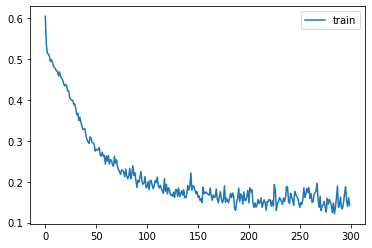

In [54]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.92976   0.98051   0.95446       513
           B    0.97821   0.92197   0.94926       487

    accuracy                        0.95200      1000
   macro avg    0.95399   0.95124   0.95186      1000
weighted avg    0.95336   0.95200   0.95193      1000

Confusion matrix, without normalization
[[503  10]
 [ 38 449]]


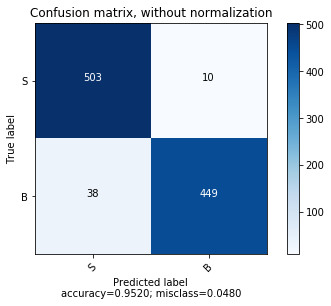

[1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 

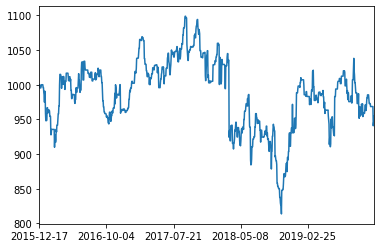

In [55]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.5991 - accuracy: 0.7055
Epoch 2/300
3996/3996 [==============================] - 1s 208us/step - loss: 0.5353 - accuracy: 0.74150s - loss: 0.5318 - accuracy: 0.74 - ETA: 0s - loss: 0.5321 - accuracy
Epoch 3/300
3996/3996 [==============================] - 2s 598us/step - loss: 0.5191 - accuracy: 0.7528
Epoch 4/300
3996/3996 [==============================] - 2s 424us/step - loss: 0.4985 - accuracy: 0.76001s - loss: 0.494
Epoch 5/300
3996/3996 [==============================] - 1s 255us/step - loss: 0.4931 - accuracy: 0.7698
Epoch 6/300
3996/3996 [==============================] - 1s 216us/step - loss: 0.4854 - accuracy: 0.76980s - loss: 0.4861 - accuracy: 0.76
Epoch 7/300
3996/3996 [==============================] - 1s 204us/step - loss: 0.4711 - accuracy: 0.7810
Epoch 8/300
3996/3996 [==============================] - 1s 264us/step - loss: 0.4743 - accuracy: 0.7765
Epoch 9/300
3996/3996 [===================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 450us/step - loss: 0.3531 - accuracy: 0.8481
Epoch 57/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.3624 - accuracy: 0.8413
Epoch 58/300
3996/3996 [==============================] - 1s 269us/step - loss: 0.3612 - accuracy: 0.8398
Epoch 59/300
3996/3996 [==============================] - 1s 149us/step - loss: 0.3590 - accuracy: 0.8411
Epoch 60/300
3996/3996 [==============================] - 1s 155us/step - loss: 0.3581 - accuracy: 0.8348
Epoch 61/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.3552 - accuracy: 0.8408
Epoch 62/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.3550 - accuracy: 0.8436
Epoch 63/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.3475 - accuracy: 0.8481
Epoch 64/300
3996/3996 [==============================] - 1s 130us/step - loss: 0.3475 - accuracy: 0.8406
Epoch 65/300
3996/3996 [==============================] - 1

3996/3996 [==============================] - 1s 166us/step - loss: 0.2839 - accuracy: 0.8751
Epoch 131/300
3996/3996 [==============================] - 1s 178us/step - loss: 0.2745 - accuracy: 0.8719
Epoch 132/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.2755 - accuracy: 0.8799
Epoch 133/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.2707 - accuracy: 0.8801
Epoch 134/300
3996/3996 [==============================] - 1s 174us/step - loss: 0.2709 - accuracy: 0.8804
Epoch 135/300
3996/3996 [==============================] - 1s 145us/step - loss: 0.2635 - accuracy: 0.8859
Epoch 136/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.2667 - accuracy: 0.8806
Epoch 137/300
3996/3996 [==============================] - 1s 146us/step - loss: 0.2638 - accuracy: 0.8846
Epoch 138/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.2603 - accuracy: 0.8841
Epoch 139/300
3996/3996 [==========================

3996/3996 [==============================] - 1s 164us/step - loss: 0.2209 - accuracy: 0.9084
Epoch 205/300
3996/3996 [==============================] - 1s 186us/step - loss: 0.2268 - accuracy: 0.9079
Epoch 206/300
3996/3996 [==============================] - 1s 207us/step - loss: 0.2079 - accuracy: 0.9124
Epoch 207/300
3996/3996 [==============================] - 1s 186us/step - loss: 0.2086 - accuracy: 0.9089
Epoch 208/300
3996/3996 [==============================] - 1s 175us/step - loss: 0.2032 - accuracy: 0.9147
Epoch 209/300
3996/3996 [==============================] - 1s 186us/step - loss: 0.2280 - accuracy: 0.9012
Epoch 210/300
3996/3996 [==============================] - 1s 170us/step - loss: 0.2056 - accuracy: 0.9127
Epoch 211/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.2149 - accuracy: 0.9069
Epoch 212/300
3996/3996 [==============================] - 1s 186us/step - loss: 0.1935 - accuracy: 0.9194
Epoch 213/300
3996/3996 [==========================

3996/3996 [==============================] - 1s 199us/step - loss: 0.1846 - accuracy: 0.91920s - loss: 0.1851 - accuracy: 
Epoch 278/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.1959 - accuracy: 0.9157
Epoch 279/300
3996/3996 [==============================] - 1s 183us/step - loss: 0.1801 - accuracy: 0.9249
Epoch 280/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.1918 - accuracy: 0.9137
Epoch 281/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.1881 - accuracy: 0.9192
Epoch 282/300
3996/3996 [==============================] - 1s 173us/step - loss: 0.1850 - accuracy: 0.9202
Epoch 283/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.1975 - accuracy: 0.9134
Epoch 284/300
3996/3996 [==============================] - 1s 180us/step - loss: 0.1622 - accuracy: 0.93420s - loss: 0.1798 
Epoch 285/300
3996/3996 [==============================] - 1s 182us/step - loss: 0.1798 - accuracy: 0.9262
Epo

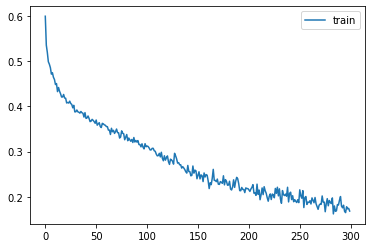

In [56]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.91977   0.91618   0.91797       513
           B    0.91207   0.91581   0.91393       487

    accuracy                        0.91600      1000
   macro avg    0.91592   0.91600   0.91595      1000
weighted avg    0.91602   0.91600   0.91600      1000

Confusion matrix, without normalization
[[470  43]
 [ 41 446]]


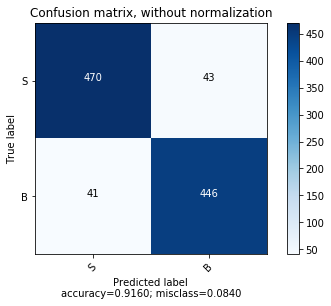

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 

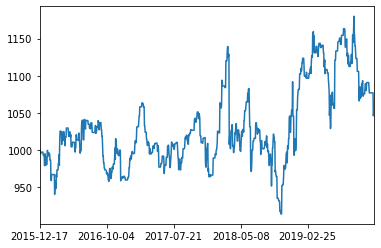

In [57]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 3s 659us/step - loss: 1.3872 - accuracy: 0.55811s - loss: 1.6881 - accura
Epoch 2/300
3996/3996 [==============================] - 1s 181us/step - loss: 0.6714 - accuracy: 0.6074
Epoch 3/300
3996/3996 [==============================] - 1s 170us/step - loss: 0.6385 - accuracy: 0.6481
Epoch 4/300
3996/3996 [==============================] - 1s 150us/step - loss: 0.6190 - accuracy: 0.6629
Epoch 5/300
3996/3996 [==============================] - 1s 147us/step - loss: 0.5959 - accuracy: 0.6797
Epoch 6/300
3996/3996 [==============================] - 1s 187us/step - loss: 0.5748 - accuracy: 0.6957
Epoch 7/300
3996/3996 [==============================] - 1s 159us/step - loss: 0.5695 - accuracy: 0.7080
Epoch 8/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.5638 - accuracy: 0.7125
Epoch 9/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.5611 - accuracy: 0.7297
Epoch 10/300
3996/3996 [=====

Epoch 77/300
3996/3996 [==============================] - 1s 238us/step - loss: 0.4241 - accuracy: 0.8018
Epoch 78/300
3996/3996 [==============================] - 1s 298us/step - loss: 0.4209 - accuracy: 0.8093
Epoch 79/300
3996/3996 [==============================] - 1s 242us/step - loss: 0.4169 - accuracy: 0.8073
Epoch 80/300
3996/3996 [==============================] - 1s 206us/step - loss: 0.4303 - accuracy: 0.7983
Epoch 81/300
3996/3996 [==============================] - 1s 252us/step - loss: 0.4171 - accuracy: 0.8056
Epoch 82/300
3996/3996 [==============================] - 1s 135us/step - loss: 0.4131 - accuracy: 0.8091
Epoch 83/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.4047 - accuracy: 0.8158
Epoch 84/300
3996/3996 [==============================] - 1s 188us/step - loss: 0.4102 - accuracy: 0.8131
Epoch 85/300
3996/3996 [==============================] - 0s 124us/step - loss: 0.4136 - accuracy: 0.8076
Epoch 86/300
3996/3996 [======================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 250us/step - loss: 0.3845 - accuracy: 0.8233
Epoch 132/300
3996/3996 [==============================] - 1s 301us/step - loss: 0.3902 - accuracy: 0.8266
Epoch 133/300
3996/3996 [==============================] - 1s 321us/step - loss: 0.3967 - accuracy: 0.8221
Epoch 134/300
3996/3996 [==============================] - 1s 273us/step - loss: 0.3751 - accuracy: 0.8311
Epoch 135/300
3996/3996 [==============================] - 1s 288us/step - loss: 0.3785 - accuracy: 0.8281
Epoch 136/300
3996/3996 [==============================] - 1s 202us/step - loss: 0.3780 - accuracy: 0.82960s - loss: 0.3
Epoch 137/300
3996/3996 [==============================] - 1s 375us/step - loss: 0.3889 - accuracy: 0.8211
Epoch 138/300
3996/3996 [==============================] - 1s 246us/step - loss: 0.3857 - accuracy: 0.8228
Epoch 139/300
3996/3996 [==============================] - 1s 177us/step - loss: 0.3834 - accuracy: 0.8258
Epoch 140/300
3996/3996 [============

3996/3996 [==============================] - 1s 194us/step - loss: 0.3641 - accuracy: 0.8416
Epoch 207/300
3996/3996 [==============================] - 1s 144us/step - loss: 0.3543 - accuracy: 0.8368
Epoch 208/300
3996/3996 [==============================] - 1s 147us/step - loss: 0.3544 - accuracy: 0.8403
Epoch 209/300
3996/3996 [==============================] - 1s 139us/step - loss: 0.3524 - accuracy: 0.8481
Epoch 210/300
3996/3996 [==============================] - 1s 336us/step - loss: 0.3490 - accuracy: 0.84060s - loss: 0.3497 - accura
Epoch 211/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.3456 - accuracy: 0.84160s - loss:
Epoch 212/300
3996/3996 [==============================] - 1s 203us/step - loss: 0.3489 - accuracy: 0.8473
Epoch 213/300
3996/3996 [==============================] - 1s 224us/step - loss: 0.3614 - accuracy: 0.8388
Epoch 214/300
3996/3996 [==============================] - 1s 174us/step - loss: 0.3577 - accuracy: 0.8413
Epoch 215/300
3

3996/3996 [==============================] - 1s 148us/step - loss: 0.3373 - accuracy: 0.8506
Epoch 283/300
3996/3996 [==============================] - 1s 177us/step - loss: 0.3295 - accuracy: 0.8496
Epoch 284/300
3996/3996 [==============================] - 1s 202us/step - loss: 0.3315 - accuracy: 0.85010s - loss: 0.3322 - accuracy
Epoch 285/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.3359 - accuracy: 0.8571
Epoch 286/300
3996/3996 [==============================] - 1s 156us/step - loss: 0.3270 - accuracy: 0.85110s - loss: 0.3264 - accuracy: 
Epoch 287/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.3458 - accuracy: 0.8431
Epoch 288/300
3996/3996 [==============================] - 1s 150us/step - loss: 0.3338 - accuracy: 0.8539
Epoch 289/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.3405 - accuracy: 0.8463
Epoch 290/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.3427 - accuracy: 

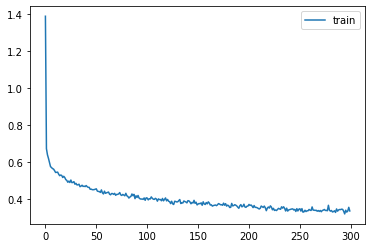

In [58]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

           S    0.81190   0.82456   0.81818       513
           B    0.81211   0.79877   0.80538       487

    accuracy                        0.81200      1000
   macro avg    0.81200   0.81166   0.81178      1000
weighted avg    0.81200   0.81200   0.81195      1000

Confusion matrix, without normalization
[[423  90]
 [ 98 389]]


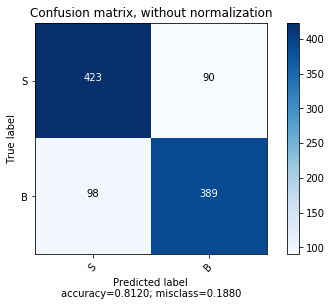

[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 

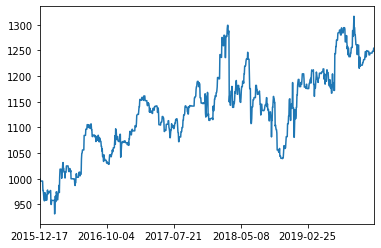

In [59]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 378us/step - loss: 0.6355 - accuracy: 0.6563
Epoch 2/300
3992/3992 [==============================] - 0s 115us/step - loss: 0.5594 - accuracy: 0.7192
Epoch 3/300
3992/3992 [==============================] - 1s 136us/step - loss: 0.5459 - accuracy: 0.7315
Epoch 4/300
3992/3992 [==============================] - 0s 114us/step - loss: 0.5397 - accuracy: 0.7335
Epoch 5/300
3992/3992 [==============================] - 1s 130us/step - loss: 0.5337 - accuracy: 0.7462
Epoch 6/300
3992/3992 [==============================] - 0s 116us/step - loss: 0.5271 - accuracy: 0.7465
Epoch 7/300
3992/3992 [==============================] - 0s 123us/step - loss: 0.5216 - accuracy: 0.7457
Epoch 8/300
3992/3992 [==============================] - 0s 117us/step - loss: 0.5235 - accuracy: 0.7528
Epoch 9/300
3992/3992 [==============================] - 0s 111us/step - loss: 0.5189 - accuracy: 0.7580
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 234us/step - loss: 0.4574 - accuracy: 0.7838
Epoch 78/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.4573 - accuracy: 0.7896
Epoch 79/300
3992/3992 [==============================] - 1s 149us/step - loss: 0.4581 - accuracy: 0.7868
Epoch 80/300
3992/3992 [==============================] - 0s 118us/step - loss: 0.4555 - accuracy: 0.7868
Epoch 81/300
3992/3992 [==============================] - 0s 109us/step - loss: 0.4589 - accuracy: 0.7803
Epoch 82/300
3992/3992 [==============================] - 0s 108us/step - loss: 0.4573 - accuracy: 0.7833
Epoch 83/300
3992/3992 [==============================] - 0s 105us/step - loss: 0.4536 - accuracy: 0.7838
Epoch 84/300
3992/3992 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.78 - 0s 110us/step - loss: 0.4501 - accuracy: 0.7903
Epoch 85/300
3992/3992 [==============================] - 0s 96us/step - loss: 0.4563 - accuracy: 0.7891
Epoch 86/300
3992/

3992/3992 [==============================] - 0s 125us/step - loss: 0.4256 - accuracy: 0.8064
Epoch 153/300
3992/3992 [==============================] - 0s 103us/step - loss: 0.4270 - accuracy: 0.8059
Epoch 154/300
3992/3992 [==============================] - 0s 109us/step - loss: 0.4300 - accuracy: 0.8004
Epoch 155/300
3992/3992 [==============================] - 0s 110us/step - loss: 0.4344 - accuracy: 0.7978
Epoch 156/300
3992/3992 [==============================] - 0s 111us/step - loss: 0.4217 - accuracy: 0.8046
Epoch 157/300
3992/3992 [==============================] - 0s 114us/step - loss: 0.4270 - accuracy: 0.8006
Epoch 158/300
3992/3992 [==============================] - 0s 117us/step - loss: 0.4260 - accuracy: 0.8059
Epoch 159/300
3992/3992 [==============================] - 0s 116us/step - loss: 0.4272 - accuracy: 0.7968
Epoch 160/300
3992/3992 [==============================] - 0s 116us/step - loss: 0.4209 - accuracy: 0.8039
Epoch 161/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 129us/step - loss: 0.4134 - accuracy: 0.8106
Epoch 227/300
3992/3992 [==============================] - 0s 122us/step - loss: 0.4130 - accuracy: 0.8079
Epoch 228/300
3992/3992 [==============================] - 1s 131us/step - loss: 0.4049 - accuracy: 0.8116
Epoch 229/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.4031 - accuracy: 0.8081
Epoch 230/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.4103 - accuracy: 0.8071
Epoch 231/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.4065 - accuracy: 0.8169
Epoch 232/300
3992/3992 [==============================] - 1s 155us/step - loss: 0.4067 - accuracy: 0.81240s - loss: 0.4077 - accuracy: 0.
Epoch 233/300
3992/3992 [==============================] - 1s 164us/step - loss: 0.4045 - accuracy: 0.8089
Epoch 234/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.4036 - accuracy: 0.8114
Epoch 235/300
3992/

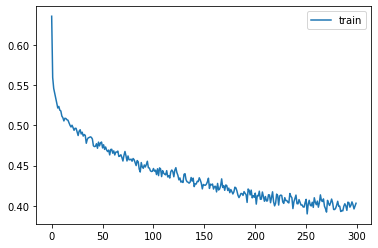

In [60]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.81518   0.81202   0.81359       516
           B    0.80000   0.80331   0.80165       483

    accuracy                        0.80781       999
   macro avg    0.80759   0.80766   0.80762       999
weighted avg    0.80784   0.80781   0.80782       999

Confusion matrix, without normalization
[[419  97]
 [ 95 388]]


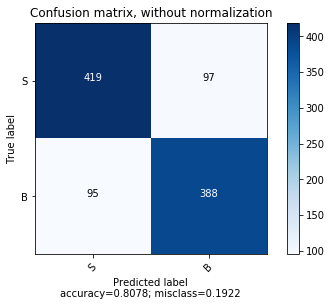

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 

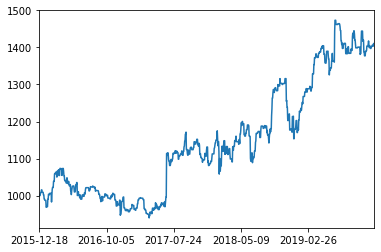

In [61]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 523us/step - loss: 0.6460 - accuracy: 0.6410
Epoch 2/300
3992/3992 [==============================] - 1s 142us/step - loss: 0.5595 - accuracy: 0.7222
Epoch 3/300
3992/3992 [==============================] - 1s 133us/step - loss: 0.5331 - accuracy: 0.7420
Epoch 4/300
3992/3992 [==============================] - 1s 136us/step - loss: 0.5272 - accuracy: 0.7482
Epoch 5/300
3992/3992 [==============================] - 1s 157us/step - loss: 0.5159 - accuracy: 0.7515
Epoch 6/300
3992/3992 [==============================] - 0s 123us/step - loss: 0.5168 - accuracy: 0.7638
Epoch 7/300
3992/3992 [==============================] - 1s 143us/step - loss: 0.5050 - accuracy: 0.7630
Epoch 8/300
3992/3992 [==============================] - 1s 143us/step - loss: 0.5038 - accuracy: 0.7620
Epoch 9/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.5027 - accuracy: 0.7645
Epoch 10/300
3992/3992 [==============================]

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 347us/step - loss: 0.4675 - accuracy: 0.7856
Epoch 22/300
3992/3992 [==============================] - 1s 307us/step - loss: 0.4638 - accuracy: 0.7908
Epoch 23/300
3992/3992 [==============================] - 1s 311us/step - loss: 0.4572 - accuracy: 0.7906
Epoch 24/300
3992/3992 [==============================] - 1s 321us/step - loss: 0.4601 - accuracy: 0.7898
Epoch 25/300
3992/3992 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.7935 ETA: 0s - loss: 0.449 - 1s 310us/step - loss: 0.4524 - accuracy: 0.7933
Epoch 26/300
3992/3992 [==============================] - 1s 228us/step - loss: 0.4593 - accuracy: 0.7866
Epoch 27/300
3992/3992 [==============================] - 1s 252us/step - loss: 0.4480 - accuracy: 0.7958
Epoch 28/300
3992/3992 [==============================] - 1s 237us/step - loss: 0.4543 - accuracy: 0.7876
Epoch 29/300
3992/3992 [==============================] - 1s 186us/step - loss: 0.4529 - accuracy: 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 236us/step - loss: 0.4465 - accuracy: 0.8001
Epoch 31/300
3992/3992 [==============================] - 1s 220us/step - loss: 0.4415 - accuracy: 0.7943
Epoch 32/300
3992/3992 [==============================] - 1s 220us/step - loss: 0.4401 - accuracy: 0.7988
Epoch 33/300
3992/3992 [==============================] - 1s 235us/step - loss: 0.4415 - accuracy: 0.79331s - loss: 0.4353 - accuracy - ETA: 0s - loss: 0.429
Epoch 34/300
3992/3992 [==============================] - 1s 250us/step - loss: 0.4453 - accuracy: 0.7983
Epoch 35/300
3992/3992 [==============================] - 1s 271us/step - loss: 0.4337 - accuracy: 0.80410s - loss:
Epoch 36/300
 992/3992 [======>.......................] - ETA: 0s - loss: 0.4372 - accuracy: 0.8115

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.81 - 1s 283us/step - loss: 0.4272 - accuracy: 0.8096
Epoch 37/300
3992/3992 [==============================] - 1s 259us/step - loss: 0.4257 - accuracy: 0.80340s - loss: 0.4315 - ac
Epoch 38/300
3992/3992 [==============================] - 1s 242us/step - loss: 0.4155 - accuracy: 0.8041
Epoch 39/300
3992/3992 [==============================] - 1s 210us/step - loss: 0.4229 - accuracy: 0.80610s - loss: 0.4235 - ac
Epoch 40/300
3992/3992 [==============================] - 1s 251us/step - loss: 0.4145 - accuracy: 0.8096
Epoch 41/300
 928/3992 [=====>........................] - ETA: 0s - loss: 0.4018 - accuracy: 0.8060

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 290us/step - loss: 0.4140 - accuracy: 0.81010s - loss: 0.4185 - ac
Epoch 42/300
3992/3992 [==============================] - 1s 227us/step - loss: 0.4217 - accuracy: 0.8091
Epoch 43/300
3992/3992 [==============================] - 1s 326us/step - loss: 0.4079 - accuracy: 0.8176
Epoch 44/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.4088 - accuracy: 0.8101
Epoch 45/300
3992/3992 [==============================] - 1s 252us/step - loss: 0.4004 - accuracy: 0.8161
Epoch 46/300
3992/3992 [==============================] - 1s 301us/step - loss: 0.3991 - accuracy: 0.8161
Epoch 47/300
3992/3992 [==============================] - 1s 231us/step - loss: 0.3932 - accuracy: 0.81940s - loss: 0.3914 - 
Epoch 48/300
3992/3992 [==============================] - 1s 250us/step - loss: 0.3850 - accuracy: 0.8259
Epoch 49/300
3992/3992 [==============================] - 1s 283us/step - loss: 0.3913 - accuracy: 0.8191
Epoch 50/300
3992

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 203us/step - loss: 0.3603 - accuracy: 0.8364
Epoch 65/300
3992/3992 [==============================] - 1s 295us/step - loss: 0.3484 - accuracy: 0.84241s -
Epoch 66/300
3992/3992 [==============================] - 1s 174us/step - loss: 0.3312 - accuracy: 0.8515
Epoch 67/300
3992/3992 [==============================] - 1s 235us/step - loss: 0.3403 - accuracy: 0.84740s - loss: 0.3409 - accu - ETA: 0s - loss: 0.3418 - accuracy: 0.
Epoch 68/300
3992/3992 [==============================] - 1s 172us/step - loss: 0.3364 - accuracy: 0.8520
Epoch 69/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.3263 - accuracy: 0.8522
Epoch 70/300
3992/3992 [==============================] - 1s 147us/step - loss: 0.3286 - accuracy: 0.8545
Epoch 71/300
3992/3992 [==============================] - 1s 155us/step - loss: 0.3135 - accuracy: 0.8632
Epoch 72/300
3992/3992 [==============================] - 1s 193us/step - loss: 0.3168 - accuracy

Epoch 139/300
3992/3992 [==============================] - 1s 164us/step - loss: 0.2697 - accuracy: 0.8805
Epoch 140/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.2901 - accuracy: 0.8730
Epoch 141/300
3992/3992 [==============================] - 1s 178us/step - loss: 0.2694 - accuracy: 0.8765
Epoch 142/300
3992/3992 [==============================] - 1s 179us/step - loss: 0.2620 - accuracy: 0.88931s - loss:
Epoch 143/300
3992/3992 [==============================] - 1s 183us/step - loss: 0.2439 - accuracy: 0.89030s - loss: 0.2351 - accura
Epoch 144/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.2680 - accuracy: 0.8825
Epoch 145/300
3992/3992 [==============================] - 1s 160us/step - loss: 0.2439 - accuracy: 0.8928
Epoch 146/300
3992/3992 [==============================] - 1s 331us/step - loss: 0.2502 - accuracy: 0.8885
Epoch 147/300
3992/3992 [==============================] - 1s 331us/step - loss: 0.2623 - accuracy: 0.8863
E

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 288us/step - loss: 0.2716 - accuracy: 0.8813
Epoch 166/300
3992/3992 [==============================] - 1s 270us/step - loss: 0.3230 - accuracy: 0.8585
Epoch 167/300
3992/3992 [==============================] - 1s 217us/step - loss: 0.3140 - accuracy: 0.8607
Epoch 168/300
3992/3992 [==============================] - 2s 383us/step - loss: 0.2741 - accuracy: 0.8737
Epoch 169/300
3992/3992 [==============================] - 2s 533us/step - loss: 0.2717 - accuracy: 0.8853
Epoch 170/300
3992/3992 [==============================] - 2s 404us/step - loss: 0.2613 - accuracy: 0.8848
Epoch 171/300
3992/3992 [==============================] - 1s 334us/step - loss: 0.2707 - accuracy: 0.88330s - loss: 0.2622 - accu
Epoch 172/300
3992/3992 [==============================] - 1s 208us/step - loss: 0.2833 - accuracy: 0.8768
Epoch 173/300
3992/3992 [==============================] - 1s 258us/step - loss: 0.2687 - accuracy: 0.8823
Epoch 174/300
3992/3992 [==

3992/3992 [==============================] - 1s 159us/step - loss: 0.2065 - accuracy: 0.9101
Epoch 239/300
3992/3992 [==============================] - 1s 150us/step - loss: 0.2065 - accuracy: 0.90860s - loss: 0.1962 - ac
Epoch 240/300
3992/3992 [==============================] - 1s 159us/step - loss: 0.2565 - accuracy: 0.8913
Epoch 241/300
3992/3992 [==============================] - 1s 200us/step - loss: 0.2142 - accuracy: 0.9078
Epoch 242/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.2115 - accuracy: 0.9128
Epoch 243/300
3992/3992 [==============================] - 1s 148us/step - loss: 0.2091 - accuracy: 0.9111
Epoch 244/300
3992/3992 [==============================] - 1s 146us/step - loss: 0.2383 - accuracy: 0.8915
Epoch 245/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.2305 - accuracy: 0.9018
Epoch 246/300
3992/3992 [==============================] - 1s 157us/step - loss: 0.2196 - accuracy: 0.9048
Epoch 247/300
3992/3992 [====

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 180us/step - loss: 0.2019 - accuracy: 0.9086
Epoch 262/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.2159 - accuracy: 0.9088
Epoch 263/300
3992/3992 [==============================] - 1s 193us/step - loss: 0.2413 - accuracy: 0.8920
Epoch 264/300
3992/3992 [==============================] - 1s 151us/step - loss: 0.2080 - accuracy: 0.9123
Epoch 265/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.2289 - accuracy: 0.8950
Epoch 266/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.2344 - accuracy: 0.8950
Epoch 267/300
3992/3992 [==============================] - 1s 151us/step - loss: 0.2363 - accuracy: 0.8960
Epoch 268/300
3992/3992 [==============================] - 1s 175us/step - loss: 0.2314 - accuracy: 0.9018
Epoch 269/300
3992/3992 [==============================] - 1s 157us/step - loss: 0.2146 - accuracy: 0.9086
Epoch 270/300
3992/3992 [==========================

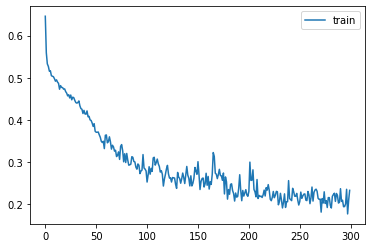

In [62]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.80220   0.99031   0.88638       516
           B    0.98619   0.73913   0.84497       483

    accuracy                        0.86887       999
   macro avg    0.89419   0.86472   0.86568       999
weighted avg    0.89115   0.86887   0.86636       999

Confusion matrix, without normalization
[[511   5]
 [126 357]]


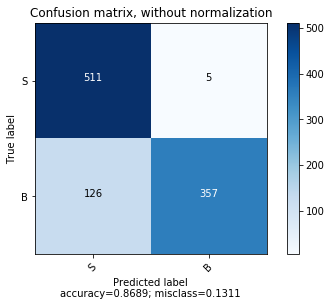

[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 

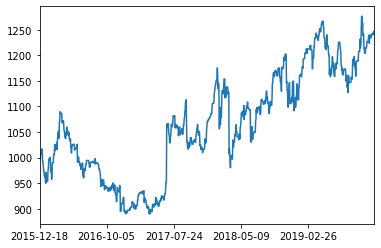

In [63]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 562us/step - loss: 0.6520 - accuracy: 0.6733
Epoch 2/300
3992/3992 [==============================] - 1s 190us/step - loss: 0.5559 - accuracy: 0.7202
Epoch 3/300
3992/3992 [==============================] - 1s 185us/step - loss: 0.5377 - accuracy: 0.7367
Epoch 4/300
3992/3992 [==============================] - 1s 181us/step - loss: 0.5207 - accuracy: 0.7553
Epoch 5/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.5144 - accuracy: 0.7560
Epoch 6/300
3992/3992 [==============================] - 1s 181us/step - loss: 0.4999 - accuracy: 0.7660
Epoch 7/300
3992/3992 [==============================] - 1s 161us/step - loss: 0.4901 - accuracy: 0.7728
Epoch 8/300
3992/3992 [==============================] - 1s 195us/step - loss: 0.4832 - accuracy: 0.7748
Epoch 9/300
3992/3992 [==============================] - 1s 166us/step - loss: 0.4776 - accuracy: 0.7766
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 0s 124us/step - loss: 0.3030 - accuracy: 0.8647
Epoch 77/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.3059 - accuracy: 0.8645
Epoch 78/300
3992/3992 [==============================] - 0s 120us/step - loss: 0.3032 - accuracy: 0.8640
Epoch 79/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.3073 - accuracy: 0.8612
Epoch 80/300
3992/3992 [==============================] - 1s 301us/step - loss: 0.2987 - accuracy: 0.8645
Epoch 81/300
3992/3992 [==============================] - 1s 227us/step - loss: 0.2980 - accuracy: 0.8652
Epoch 82/300
3992/3992 [==============================] - 1s 254us/step - loss: 0.2987 - accuracy: 0.86650s - loss: 0.287
Epoch 83/300
3992/3992 [==============================] - 1s 180us/step - loss: 0.2872 - accuracy: 0.8672
Epoch 84/300
3992/3992 [==============================] - 1s 228us/step - loss: 0.3035 - accuracy: 0.8612
Epoch 85/300
3992/3992 [===================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 332us/step - loss: 0.2586 - accuracy: 0.8908
Epoch 129/300
 832/3992 [=====>........................] - ETA: 1s - loss: 0.2272 - accuracy: 0.9026

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 341us/step - loss: 0.2533 - accuracy: 0.89180s - loss: 0.2549 - accuracy: 
Epoch 130/300
3992/3992 [==============================] - 1s 343us/step - loss: 0.2587 - accuracy: 0.8875
Epoch 131/300
3992/3992 [==============================] - 1s 284us/step - loss: 0.2548 - accuracy: 0.8885
Epoch 132/300
3992/3992 [==============================] - 1s 299us/step - loss: 0.2484 - accuracy: 0.8945
Epoch 133/300
3992/3992 [==============================] - 2s 376us/step - loss: 0.2579 - accuracy: 0.88600s - loss: 0.276 - ETA: 0s - loss: 0.2608 - accura
Epoch 134/300
3992/3992 [==============================] - 1s 339us/step - loss: 0.2574 - accuracy: 0.88830s - loss: 0.2530 - accura
Epoch 135/300
3992/3992 [==============================] - 1s 226us/step - loss: 0.2531 - accuracy: 0.8915
Epoch 136/300
3992/3992 [==============================] - 1s 268us/step - loss: 0.2506 - accuracy: 0.8865
Epoch 137/300
3992/3992 [===========================

3992/3992 [==============================] - 1s 198us/step - loss: 0.2223 - accuracy: 0.9076
Epoch 203/300
3992/3992 [==============================] - 1s 210us/step - loss: 0.2421 - accuracy: 0.9003
Epoch 204/300
3992/3992 [==============================] - 1s 191us/step - loss: 0.2056 - accuracy: 0.9051
Epoch 205/300
3992/3992 [==============================] - 1s 206us/step - loss: 0.2238 - accuracy: 0.9076
Epoch 206/300
3992/3992 [==============================] - 1s 185us/step - loss: 0.2196 - accuracy: 0.9056
Epoch 207/300
3992/3992 [==============================] - 1s 211us/step - loss: 0.2037 - accuracy: 0.9133
Epoch 208/300
3992/3992 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9097 ETA: 0s - loss: 0.2 - 1s 197us/step - loss: 0.2217 - accuracy: 0.9086
Epoch 209/300
3992/3992 [==============================] - 1s 185us/step - loss: 0.2123 - accuracy: 0.9088
Epoch 210/300
3992/3992 [==============================] - 1s 212us/step - loss: 0.2064 - accu

3992/3992 [==============================] - 1s 256us/step - loss: 0.1954 - accuracy: 0.91930s - loss: 0.1952 - accuracy: 0.91
Epoch 275/300
3992/3992 [==============================] - 1s 218us/step - loss: 0.1987 - accuracy: 0.91680s - loss:
Epoch 276/300
3992/3992 [==============================] - 1s 219us/step - loss: 0.1887 - accuracy: 0.9264
Epoch 277/300
3992/3992 [==============================] - 1s 225us/step - loss: 0.1964 - accuracy: 0.9186
Epoch 278/300
3992/3992 [==============================] - 1s 223us/step - loss: 0.1939 - accuracy: 0.92260s - loss: 0.1854 - 
Epoch 279/300
3992/3992 [==============================] - 1s 253us/step - loss: 0.1952 - accuracy: 0.9178
Epoch 280/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.1935 - accuracy: 0.9196
Epoch 281/300
3992/3992 [==============================] - 1s 262us/step - loss: 0.1712 - accuracy: 0.92961s - los
Epoch 282/300
3992/3992 [==============================] - 1s 231us/step - loss: 0.177

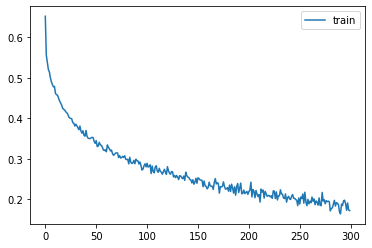

In [64]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.88153   0.85078   0.86588       516
           B    0.84631   0.87785   0.86179       483

    accuracy                        0.86386       999
   macro avg    0.86392   0.86431   0.86383       999
weighted avg    0.86450   0.86386   0.86390       999

Confusion matrix, without normalization
[[439  77]
 [ 59 424]]


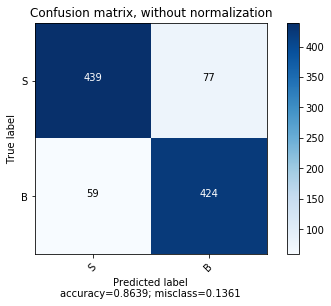

[1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 

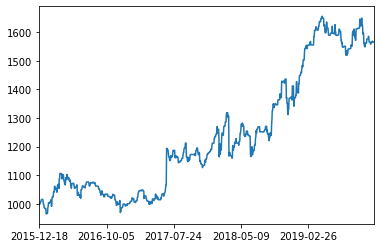

In [65]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 3s 756us/step - loss: 1.9238 - accuracy: 0.5381
Epoch 2/300
3992/3992 [==============================] - 1s 312us/step - loss: 0.6864 - accuracy: 0.57790s - loss: 0.6
Epoch 3/300
3992/3992 [==============================] - 2s 426us/step - loss: 0.6648 - accuracy: 0.5954
Epoch 4/300
3992/3992 [==============================] - 2s 442us/step - loss: 0.6489 - accuracy: 0.6242
Epoch 5/300
3992/3992 [==============================] - 2s 385us/step - loss: 0.6449 - accuracy: 0.6290
Epoch 6/300
3992/3992 [==============================] - 2s 387us/step - loss: 0.6259 - accuracy: 0.6490
Epoch 7/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.6169 - accuracy: 0.65430s - loss:
Epoch 8/300
3992/3992 [==============================] - 1s 314us/step - loss: 0.6103 - accuracy: 0.66111s - loss:
Epoch 9/300
3992/3992 [==============================] - 1s 285us/step - loss: 0.5990 - accuracy: 0.6683
Epoch 10/300
3992/399

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 2s 506us/step - loss: 0.4997 - accuracy: 0.7590
Epoch 36/300
3992/3992 [==============================] - 2s 413us/step - loss: 0.4987 - accuracy: 0.75630s - loss: 0.488 - ETA: 0s - loss: 0.4958 - accuracy: 0.
Epoch 37/300
3992/3992 [==============================] - 1s 365us/step - loss: 0.5060 - accuracy: 0.7523
Epoch 38/300
3992/3992 [==============================] - 1s 261us/step - loss: 0.4940 - accuracy: 0.7670
Epoch 39/300
3992/3992 [==============================] - 1s 326us/step - loss: 0.4805 - accuracy: 0.7700
Epoch 40/300
3992/3992 [==============================] - 1s 329us/step - loss: 0.4927 - accuracy: 0.76301s - loss: 0.4873 -  - ETA: 0s - loss: 0.4
Epoch 41/300
3992/3992 [==============================] - 1s 347us/step - loss: 0.4919 - accuracy: 0.76551s - loss: 0.5554 - accuracy - ETA: 1s - loss: 0.5137 - accura - ETA: 0s - loss:
Epoch 42/300
3992/3992 [==============================] - 1s 309us/step - loss: 0.4851 - accu

3992/3992 [==============================] - 1s 218us/step - loss: 0.4081 - accuracy: 0.8086
Epoch 107/300
3992/3992 [==============================] - 1s 227us/step - loss: 0.3920 - accuracy: 0.8239
Epoch 108/300
3992/3992 [==============================] - 1s 193us/step - loss: 0.3995 - accuracy: 0.8104
Epoch 109/300
3992/3992 [==============================] - 1s 201us/step - loss: 0.3899 - accuracy: 0.8194
Epoch 110/300
3992/3992 [==============================] - 1s 217us/step - loss: 0.3956 - accuracy: 0.8169
Epoch 111/300
3992/3992 [==============================] - 1s 242us/step - loss: 0.4026 - accuracy: 0.8126
Epoch 112/300
3992/3992 [==============================] - 1s 214us/step - loss: 0.3944 - accuracy: 0.8131
Epoch 113/300
3992/3992 [==============================] - 1s 211us/step - loss: 0.3902 - accuracy: 0.8204
Epoch 114/300
3992/3992 [==============================] - 1s 240us/step - loss: 0.4013 - accuracy: 0.8156
Epoch 115/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 191us/step - loss: 0.3600 - accuracy: 0.8414
Epoch 182/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.3455 - accuracy: 0.8472
Epoch 183/300
3992/3992 [==============================] - 1s 186us/step - loss: 0.3385 - accuracy: 0.8477
Epoch 184/300
3992/3992 [==============================] - 1s 178us/step - loss: 0.3436 - accuracy: 0.8422
Epoch 185/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.3549 - accuracy: 0.8407
Epoch 186/300
3992/3992 [==============================] - 1s 174us/step - loss: 0.3483 - accuracy: 0.8454
Epoch 187/300
3992/3992 [==============================] - 1s 163us/step - loss: 0.3495 - accuracy: 0.8442
Epoch 188/300
3992/3992 [==============================] - 1s 141us/step - loss: 0.3440 - accuracy: 0.8454
Epoch 189/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.3519 - accuracy: 0.8402
Epoch 190/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 278us/step - loss: 0.3199 - accuracy: 0.86100s - loss: 0.3209 - accuracy: 0.86
Epoch 257/300
3992/3992 [==============================] - 1s 207us/step - loss: 0.3219 - accuracy: 0.8552
Epoch 258/300
3992/3992 [==============================] - 1s 209us/step - loss: 0.3130 - accuracy: 0.8605
Epoch 259/300
3992/3992 [==============================] - 1s 174us/step - loss: 0.3258 - accuracy: 0.8557
Epoch 260/300
3992/3992 [==============================] - 1s 157us/step - loss: 0.3113 - accuracy: 0.8620
Epoch 261/300
3992/3992 [==============================] - 1s 220us/step - loss: 0.3304 - accuracy: 0.8512
Epoch 262/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.3148 - accuracy: 0.8675
Epoch 263/300
3992/3992 [==============================] - 1s 179us/step - loss: 0.3128 - accuracy: 0.8627
Epoch 264/300
3992/3992 [==============================] - 1s 254us/step - loss: 0.3174 - accuracy: 0.8575
Epoch 265/300
399

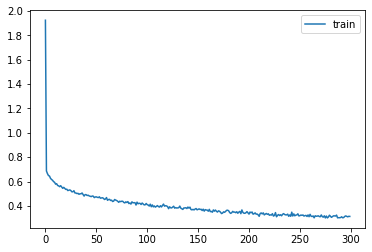

In [66]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

           S    0.78777   0.84884   0.81716       516
           B    0.82393   0.75569   0.78834       483

    accuracy                        0.80380       999
   macro avg    0.80585   0.80227   0.80275       999
weighted avg    0.80525   0.80380   0.80323       999

Confusion matrix, without normalization
[[438  78]
 [118 365]]


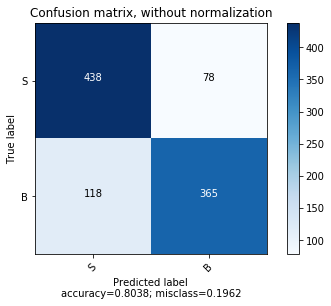

[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 

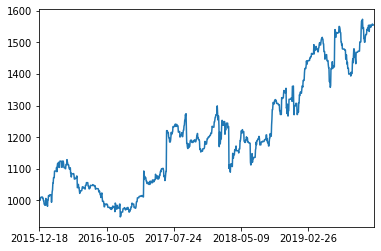

In [67]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 405us/step - loss: 2.1028 - accuracy: 0.1628
Epoch 2/300
3999/3999 [==============================] - 1s 136us/step - loss: 2.0535 - accuracy: 0.1603
Epoch 3/300
3999/3999 [==============================] - 1s 131us/step - loss: 2.0397 - accuracy: 0.1648
Epoch 4/300
3999/3999 [==============================] - 1s 137us/step - loss: 2.0348 - accuracy: 0.1645
Epoch 5/300
3999/3999 [==============================] - 0s 116us/step - loss: 2.0295 - accuracy: 0.1760
Epoch 6/300
3999/3999 [==============================] - 0s 107us/step - loss: 2.0282 - accuracy: 0.1823
Epoch 7/300
3999/3999 [==============================] - 0s 97us/step - loss: 2.0183 - accuracy: 0.1730
Epoch 8/300
3999/3999 [==============================] - 0s 125us/step - loss: 2.0192 - accuracy: 0.1758
Epoch 9/300
3999/3999 [==============================] - 0s 111us/step - loss: 2.0193 - accuracy: 0.1828
Epoch 10/300
3999/3999 [==============================] 

3999/3999 [==============================] - 0s 92us/step - loss: 1.8337 - accuracy: 0.2828
Epoch 79/300
3999/3999 [==============================] - 0s 77us/step - loss: 1.8347 - accuracy: 0.2763
Epoch 80/300
3999/3999 [==============================] - 0s 72us/step - loss: 1.8320 - accuracy: 0.2858
Epoch 81/300
3999/3999 [==============================] - 0s 74us/step - loss: 1.8325 - accuracy: 0.2816
Epoch 82/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.8379 - accuracy: 0.2801
Epoch 83/300
3999/3999 [==============================] - 0s 74us/step - loss: 1.8301 - accuracy: 0.2841
Epoch 84/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.8333 - accuracy: 0.2756
Epoch 85/300
3999/3999 [==============================] - 0s 73us/step - loss: 1.8268 - accuracy: 0.2798
Epoch 86/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.8242 - accuracy: 0.2878
Epoch 87/300
3999/3999 [==============================] - 0s 84us/st

3999/3999 [==============================] - 0s 91us/step - loss: 1.7893 - accuracy: 0.2996
Epoch 156/300
3999/3999 [==============================] - 0s 95us/step - loss: 1.7871 - accuracy: 0.3006
Epoch 157/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.8007 - accuracy: 0.2948
Epoch 158/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.7949 - accuracy: 0.3071
Epoch 159/300
3999/3999 [==============================] - 0s 87us/step - loss: 1.8001 - accuracy: 0.2941
Epoch 160/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.8080 - accuracy: 0.2996
Epoch 161/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.7925 - accuracy: 0.2988
Epoch 162/300
3999/3999 [==============================] - 1s 150us/step - loss: 1.8008 - accuracy: 0.2976
Epoch 163/300
3999/3999 [==============================] - 0s 108us/step - loss: 1.7989 - accuracy: 0.3003
Epoch 164/300
3999/3999 [==============================] 

3999/3999 [==============================] - 1s 194us/step - loss: 1.7878 - accuracy: 0.31010s - loss: 1.7838 - 
Epoch 232/300
3999/3999 [==============================] - 2s 376us/step - loss: 1.7756 - accuracy: 0.3036
Epoch 233/300
3999/3999 [==============================] - 1s 214us/step - loss: 1.7699 - accuracy: 0.31930s - loss: 1.7750 - accuracy
Epoch 234/300
3999/3999 [==============================] - 1s 193us/step - loss: 1.7768 - accuracy: 0.3103
Epoch 235/300
3999/3999 [==============================] - 1s 189us/step - loss: 1.7886 - accuracy: 0.3018
Epoch 236/300
3999/3999 [==============================] - 1s 186us/step - loss: 1.7789 - accuracy: 0.3146
Epoch 237/300
3999/3999 [==============================] - 1s 232us/step - loss: 1.7755 - accuracy: 0.3003
Epoch 238/300
3999/3999 [==============================] - 1s 222us/step - loss: 1.7785 - accuracy: 0.30860s - loss: 1.7852 
Epoch 239/300
3999/3999 [==============================] - 1s 179us/step - loss: 1.7917 - ac

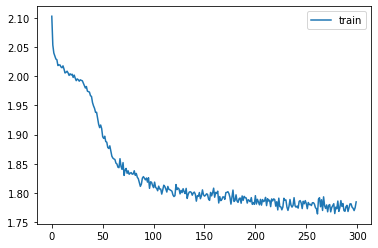

In [68]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.86667   0.23214   0.36620       112
          B2    0.00000   0.00000   0.00000       141
          B1    0.00000   0.00000   0.00000       110
          B0    0.00000   0.00000   0.00000       143
          S0    0.00000   0.00000   0.00000       136
          S1    0.00000   0.00000   0.00000       105
          S2    0.00000   0.00000   0.00000       137
          S3    0.82143   0.19828   0.31944       116

   micro avg    0.84483   0.04900   0.09263      1000
   macro avg    0.21101   0.05380   0.08571      1000
weighted avg    0.19235   0.04900   0.07807      1000
 samples avg    0.04900   0.04900   0.04900      1000

Confusion matrix, without normalization
[[112   0   0   0   0   0   0   0]
 [141   0   0   0   0   0   0   0]
 [110   0   0   0   0   0   0   0]
 [142   0   0   0   0   0   0   1]
 [136   0   0   0   0   0   0   0]
 [104   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


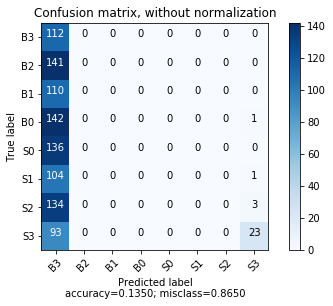

[6, 3, 1, 6, 6, 0, 6, 3, 6, 6, 4, 3, 1, 4, 0, 0, 1, 1, 4, 6, 7, 4, 4, 3, 0, 1, 6, 1, 4, 3, 7, 6, 3, 4, 3, 0, 6, 4, 1, 4, 1, 6, 4, 6, 6, 1, 6, 7, 1, 4, 6, 1, 4, 7, 4, 4, 4, 1, 6, 4, 1, 3, 7, 6, 1, 4, 6, 3, 4, 1, 1, 1, 4, 6, 4, 3, 1, 7, 1, 0, 7, 4, 3, 6, 3, 7, 3, 6, 3, 7, 1, 0, 1, 0, 1, 7, 6, 4, 6, 6, 0, 4, 1, 4, 1, 6, 1, 1, 0, 0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 1, 6, 4, 6, 7, 0, 7, 3, 0, 4, 1, 1, 4, 6, 6, 1, 4, 6, 4, 6, 3, 0, 6, 6, 6, 7, 0, 6, 4, 3, 3, 6, 1, 6, 1, 1, 1, 7, 6, 6, 0, 3, 6, 7, 0, 4, 0, 0, 1, 1, 6, 1, 4, 7, 3, 3, 4, 0, 7, 1, 7, 6, 1, 4, 6, 4, 6, 3, 1, 6, 1, 0, 0, 1, 6, 3, 6, 4, 3, 4, 6, 6, 6, 6, 4, 7, 3, 3, 1, 0, 7, 1, 6, 6, 1, 6, 1, 3, 0, 0, 0, 3, 7, 1, 4, 1, 6, 3, 7, 6, 1, 3, 6, 6, 6, 1, 4, 3, 3, 4, 6, 0, 6, 0, 4, 1, 4, 7, 6, 1, 7, 6, 6, 4, 6, 1, 0, 3, 6, 6, 4, 3, 0, 4, 3, 0, 1, 7, 0, 4, 0, 1, 4, 6, 6, 6, 4, 1, 1, 6, 1, 4, 7, 0, 1, 3, 3, 4, 6, 7, 4, 6, 6, 6, 0, 7, 0, 1, 1, 0, 6, 6, 6, 4, 7, 6, 6, 7, 3, 6, 0, 3, 6, 1, 1, 6, 6, 4, 1, 6, 7, 4, 6, 4, 7, 6, 1, 4, 6, 1, 

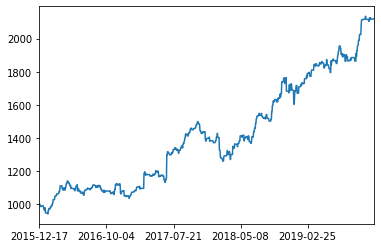

In [69]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 312us/step - loss: 2.0543 - accuracy: 0.1728
Epoch 2/300
3999/3999 [==============================] - 0s 117us/step - loss: 2.0095 - accuracy: 0.1905
Epoch 3/300
3999/3999 [==============================] - 0s 117us/step - loss: 1.9931 - accuracy: 0.2006
Epoch 4/300
3999/3999 [==============================] - 1s 135us/step - loss: 1.9866 - accuracy: 0.2058
Epoch 5/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.9738 - accuracy: 0.21460s - loss: 1.9877 - accu
Epoch 6/300
3999/3999 [==============================] - 0s 92us/step - loss: 1.9608 - accuracy: 0.2103
Epoch 7/300
3999/3999 [==============================] - 0s 79us/step - loss: 1.9476 - accuracy: 0.2268
Epoch 8/300
3999/3999 [==============================] - 0s 81us/step - loss: 1.9360 - accuracy: 0.2313
Epoch 9/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.9065 - accuracy: 0.2453
Epoch 10/300
3999/3999 [===========

3999/3999 [==============================] - 0s 91us/step - loss: 1.2496 - accuracy: 0.4821
Epoch 79/300
3999/3999 [==============================] - 1s 131us/step - loss: 1.2692 - accuracy: 0.4806
Epoch 80/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.2330 - accuracy: 0.4794
Epoch 81/300
3999/3999 [==============================] - 0s 77us/step - loss: 1.2333 - accuracy: 0.4691
Epoch 82/300
3999/3999 [==============================] - 0s 71us/step - loss: 1.2385 - accuracy: 0.4786
Epoch 83/300
3999/3999 [==============================] - 0s 74us/step - loss: 1.2337 - accuracy: 0.4841
Epoch 84/300
3999/3999 [==============================] - 0s 73us/step - loss: 1.2280 - accuracy: 0.4874
Epoch 85/300
3999/3999 [==============================] - 0s 71us/step - loss: 1.2261 - accuracy: 0.4791
Epoch 86/300
3999/3999 [==============================] - 0s 76us/step - loss: 1.2212 - accuracy: 0.4831
Epoch 87/300
3999/3999 [==============================] - 0s 71us/s

3999/3999 [==============================] - 1s 180us/step - loss: 1.1069 - accuracy: 0.5259
Epoch 154/300
3999/3999 [==============================] - 1s 250us/step - loss: 1.0828 - accuracy: 0.5366
Epoch 155/300
3999/3999 [==============================] - 1s 159us/step - loss: 1.0799 - accuracy: 0.5509
Epoch 156/300
3999/3999 [==============================] - 0s 101us/step - loss: 1.0728 - accuracy: 0.5409
Epoch 157/300
3999/3999 [==============================] - 1s 128us/step - loss: 1.0872 - accuracy: 0.5456
Epoch 158/300
3999/3999 [==============================] - 1s 309us/step - loss: 1.0521 - accuracy: 0.55792s - loss: 1.0356  - ETA: 0s - loss: 1.0561 - accura
Epoch 159/300
3999/3999 [==============================] - 1s 290us/step - loss: 1.0800 - accuracy: 0.5364
Epoch 160/300
3999/3999 [==============================] - 1s 253us/step - loss: 1.0782 - accuracy: 0.5454
Epoch 161/300
3999/3999 [==============================] - 1s 147us/step - loss: 1.0922 - accuracy: 0.5444

3999/3999 [==============================] - 0s 123us/step - loss: 1.0262 - accuracy: 0.5686
Epoch 230/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.0343 - accuracy: 0.5664
Epoch 231/300
3999/3999 [==============================] - 0s 93us/step - loss: 1.0357 - accuracy: 0.5619
Epoch 232/300
3999/3999 [==============================] - 0s 93us/step - loss: 1.0625 - accuracy: 0.5549
Epoch 233/300
3999/3999 [==============================] - 0s 114us/step - loss: 1.0269 - accuracy: 0.5631
Epoch 234/300
3999/3999 [==============================] - 0s 94us/step - loss: 1.0341 - accuracy: 0.5674
Epoch 235/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.0435 - accuracy: 0.5534
Epoch 236/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.0058 - accuracy: 0.5786
Epoch 237/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.0310 - accuracy: 0.5721
Epoch 238/300
3999/3999 [==============================]

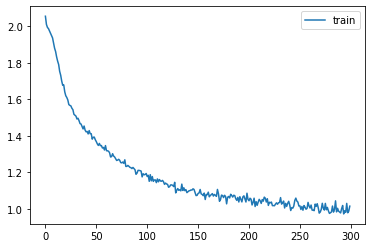

In [70]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.92593   0.44643   0.60241       112
          B2    0.74468   0.24823   0.37234       141
          B1    0.64286   0.08182   0.14516       110
          B0    0.77907   0.46853   0.58515       143
          S0    0.74046   0.71324   0.72659       136
          S1    0.63158   0.11429   0.19355       105
          S2    0.64151   0.49635   0.55967       137
          S3    0.86301   0.54310   0.66667       116

   micro avg    0.75660   0.40100   0.52418      1000
   macro avg    0.74614   0.38900   0.48144      1000
weighted avg    0.74584   0.40100   0.49276      1000
 samples avg    0.40100   0.40100   0.40100      1000

Confusion matrix, without normalization
[[100  12   0   0   0   0   0   0]
 [ 99  35   4   1   2   0   0   0]
 [ 83   0   9  18   0   0   0   0]
 [ 58   0   1  67  17   0   0   0]
 [ 36   0   0   0  97   3   0   0]
 [ 66   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


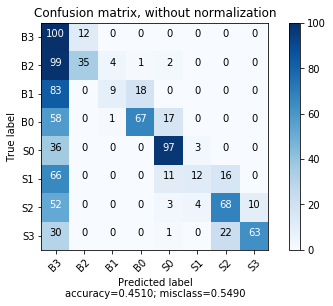

[5, 3, 0, 4, 4, 3, 6, 5, 4, 6, 4, 5, 3, 5, 0, 0, 3, 0, 1, 3, 7, 3, 4, 2, 0, 4, 6, 2, 7, 4, 6, 5, 2, 5, 3, 0, 4, 3, 1, 3, 4, 4, 5, 7, 7, 0, 7, 7, 1, 4, 6, 4, 6, 6, 5, 5, 6, 3, 7, 4, 2, 5, 6, 2, 3, 6, 5, 6, 7, 4, 3, 1, 6, 6, 2, 4, 1, 7, 4, 3, 6, 6, 4, 5, 6, 6, 2, 6, 3, 6, 1, 6, 6, 1, 1, 4, 7, 2, 5, 4, 1, 6, 2, 3, 4, 3, 1, 5, 0, 0, 4, 3, 4, 3, 4, 1, 2, 3, 3, 3, 4, 3, 1, 1, 5, 2, 6, 7, 0, 7, 2, 4, 4, 3, 2, 6, 6, 3, 2, 1, 3, 4, 3, 3, 0, 4, 2, 6, 7, 0, 6, 1, 3, 4, 6, 4, 5, 2, 0, 2, 7, 6, 7, 0, 2, 3, 7, 1, 4, 0, 0, 1, 1, 7, 2, 4, 7, 4, 4, 3, 1, 7, 3, 7, 5, 5, 4, 4, 5, 7, 2, 4, 6, 4, 0, 0, 4, 6, 6, 6, 3, 2, 1, 4, 4, 6, 6, 1, 5, 2, 4, 1, 1, 6, 3, 6, 6, 3, 4, 0, 3, 4, 1, 0, 5, 7, 6, 2, 1, 7, 3, 7, 6, 2, 2, 2, 4, 5, 6, 4, 6, 4, 5, 6, 0, 5, 0, 2, 4, 4, 6, 3, 4, 7, 4, 1, 1, 7, 2, 0, 1, 5, 6, 6, 2, 4, 4, 4, 2, 1, 6, 0, 4, 6, 1, 3, 6, 4, 6, 3, 2, 1, 7, 5, 3, 6, 0, 3, 3, 3, 5, 2, 7, 6, 3, 2, 6, 4, 4, 0, 1, 1, 0, 6, 6, 6, 6, 7, 3, 6, 6, 4, 6, 1, 3, 4, 2, 6, 5, 3, 4, 3, 6, 6, 4, 7, 4, 6, 4, 1, 3, 6, 4, 

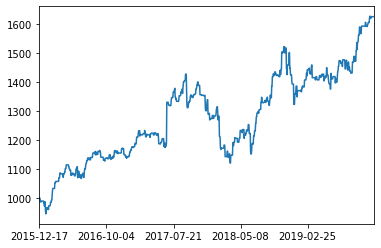

In [71]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 326us/step - loss: 2.1168 - accuracy: 0.1760
Epoch 2/300
3999/3999 [==============================] - 1s 135us/step - loss: 1.9440 - accuracy: 0.21880s - loss: 1.9453 - accuracy: 0.
Epoch 3/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.9161 - accuracy: 0.2233
Epoch 4/300
3999/3999 [==============================] - 0s 111us/step - loss: 1.8933 - accuracy: 0.2376
Epoch 5/300
3999/3999 [==============================] - 1s 163us/step - loss: 1.8677 - accuracy: 0.24160s - loss: 1.888
Epoch 6/300
3999/3999 [==============================] - 0s 110us/step - loss: 1.8353 - accuracy: 0.2541
Epoch 7/300
3999/3999 [==============================] - 1s 142us/step - loss: 1.8229 - accuracy: 0.2643
Epoch 8/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.8051 - accuracy: 0.2748
Epoch 9/300
3999/3999 [==============================] - 0s 105us/step - loss: 1.7870 - accuracy: 0.2816
Epoch 10

3999/3999 [==============================] - 0s 89us/step - loss: 1.3790 - accuracy: 0.4349
Epoch 78/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.3629 - accuracy: 0.4386
Epoch 79/300
3999/3999 [==============================] - 1s 137us/step - loss: 1.3768 - accuracy: 0.4314
Epoch 80/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.3595 - accuracy: 0.4331
Epoch 81/300
3999/3999 [==============================] - 0s 94us/step - loss: 1.3479 - accuracy: 0.4366
Epoch 82/300
3999/3999 [==============================] - 1s 187us/step - loss: 1.3560 - accuracy: 0.4326
Epoch 83/300
3999/3999 [==============================] - 0s 112us/step - loss: 1.3360 - accuracy: 0.4564
Epoch 84/300
3999/3999 [==============================] - 0s 106us/step - loss: 1.3262 - accuracy: 0.4459
Epoch 85/300
3999/3999 [==============================] - 0s 83us/step - loss: 1.3345 - accuracy: 0.4509
Epoch 86/300
3999/3999 [==============================] - 0s 85

Epoch 151/300
3999/3999 [==============================] - 1s 135us/step - loss: 1.1257 - accuracy: 0.5266
Epoch 152/300
3999/3999 [==============================] - 1s 152us/step - loss: 1.1247 - accuracy: 0.5239
Epoch 153/300
3999/3999 [==============================] - 1s 173us/step - loss: 1.1324 - accuracy: 0.5291
Epoch 154/300
3999/3999 [==============================] - 1s 148us/step - loss: 1.1004 - accuracy: 0.5359
Epoch 155/300
3999/3999 [==============================] - 1s 230us/step - loss: 1.1033 - accuracy: 0.53660s - loss: 1.0954 - accura - ETA: 0s - loss: 1.0967 - accura
Epoch 156/300
3999/3999 [==============================] - 1s 162us/step - loss: 1.1196 - accuracy: 0.5224
Epoch 157/300
3999/3999 [==============================] - 1s 162us/step - loss: 1.1012 - accuracy: 0.5454
Epoch 158/300
3999/3999 [==============================] - 1s 151us/step - loss: 1.1074 - accuracy: 0.5291
Epoch 159/300
3999/3999 [==============================] - 1s 262us/step - loss: 1.1

3999/3999 [==============================] - 0s 121us/step - loss: 1.0253 - accuracy: 0.5784
Epoch 226/300
3999/3999 [==============================] - 1s 166us/step - loss: 1.0094 - accuracy: 0.5736
Epoch 227/300
3999/3999 [==============================] - 1s 169us/step - loss: 1.0345 - accuracy: 0.5621
Epoch 228/300
3999/3999 [==============================] - 1s 134us/step - loss: 1.0033 - accuracy: 0.5784
Epoch 229/300
3999/3999 [==============================] - 1s 233us/step - loss: 1.0201 - accuracy: 0.5661
Epoch 230/300
3999/3999 [==============================] - 1s 147us/step - loss: 1.0338 - accuracy: 0.5659
Epoch 231/300
3999/3999 [==============================] - 0s 113us/step - loss: 1.0187 - accuracy: 0.5751
Epoch 232/300
3999/3999 [==============================] - 0s 110us/step - loss: 1.0180 - accuracy: 0.5701
Epoch 233/300
3999/3999 [==============================] - 0s 117us/step - loss: 1.0322 - accuracy: 0.57410s - loss: 1.0227 - accuracy: 0.
Epoch 234/300
3999/

3999/3999 [==============================] - 0s 101us/step - loss: 0.9892 - accuracy: 0.5854


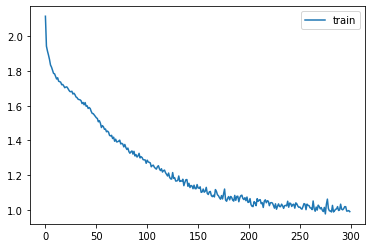

In [72]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.74038   0.68750   0.71296       112
          B2    0.66038   0.49645   0.56680       141
          B1    0.63636   0.12727   0.21212       110
          B0    0.69048   0.60839   0.64684       143
          S0    0.76471   0.47794   0.58824       136
          S1    0.87500   0.06667   0.12389       105
          S2    0.65823   0.37956   0.48148       137
          S3    0.85227   0.64655   0.73529       116

   micro avg    0.72330   0.44700   0.55253      1000
   macro avg    0.73473   0.43629   0.50845      1000
weighted avg    0.72969   0.44700   0.51987      1000
 samples avg    0.44700   0.44700   0.44700      1000

Confusion matrix, without normalization
[[92 19  1  0  0  0  0  0]
 [65 70  3  3  0  0  0  0]
 [76 17 14  3  0  0  0  0]
 [52  0  4 87  0  0  0  0]
 [40  0  0 30 65  1  0  0]
 [69  0  0  0 17  7 12  0]
 [67  0  0  2  3  0 52

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


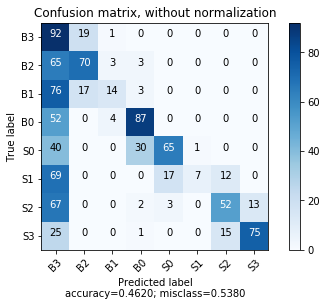

[5, 3, 0, 4, 4, 3, 6, 4, 3, 6, 4, 6, 3, 4, 0, 0, 3, 0, 1, 1, 7, 0, 2, 1, 0, 3, 6, 1, 6, 3, 4, 4, 1, 5, 3, 0, 5, 2, 0, 2, 0, 4, 4, 7, 7, 0, 7, 7, 1, 4, 7, 1, 6, 6, 4, 5, 6, 1, 7, 3, 1, 5, 6, 1, 2, 6, 5, 5, 7, 4, 2, 1, 6, 6, 1, 4, 1, 7, 3, 1, 6, 5, 4, 5, 6, 6, 1, 6, 3, 6, 0, 4, 5, 1, 1, 2, 7, 1, 5, 3, 1, 6, 1, 3, 4, 2, 1, 4, 0, 0, 3, 2, 4, 1, 4, 1, 1, 3, 3, 3, 1, 2, 0, 1, 5, 1, 6, 4, 0, 7, 1, 0, 3, 2, 1, 6, 6, 3, 1, 0, 3, 4, 2, 2, 0, 3, 2, 6, 7, 0, 6, 1, 2, 3, 6, 4, 3, 1, 0, 1, 7, 7, 7, 0, 1, 1, 7, 0, 4, 0, 0, 1, 1, 7, 1, 4, 7, 3, 4, 3, 0, 7, 2, 7, 5, 5, 4, 3, 5, 7, 1, 2, 6, 3, 0, 0, 3, 6, 6, 6, 3, 1, 1, 4, 4, 6, 6, 1, 6, 1, 4, 1, 1, 6, 3, 7, 6, 2, 3, 0, 3, 0, 1, 0, 5, 7, 4, 2, 1, 7, 3, 7, 6, 2, 1, 1, 3, 5, 4, 3, 5, 3, 6, 6, 0, 5, 0, 1, 3, 3, 6, 3, 3, 7, 4, 1, 0, 7, 1, 0, 1, 5, 6, 6, 2, 4, 4, 3, 1, 0, 7, 0, 4, 6, 0, 2, 6, 3, 6, 3, 1, 1, 7, 4, 3, 6, 0, 3, 2, 3, 5, 1, 7, 6, 2, 1, 6, 4, 3, 0, 1, 1, 0, 6, 6, 6, 6, 7, 3, 6, 4, 3, 6, 1, 3, 3, 1, 6, 6, 2, 3, 3, 6, 7, 3, 7, 3, 6, 3, 1, 1, 6, 4, 

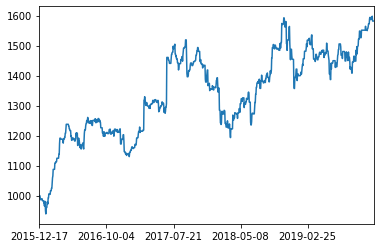

In [73]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 258us/step - loss: 4.0179 - accuracy: 0.1315
Epoch 2/300
3999/3999 [==============================] - 0s 84us/step - loss: 2.0946 - accuracy: 0.1710
Epoch 3/300
3999/3999 [==============================] - 0s 90us/step - loss: 2.0593 - accuracy: 0.1738
Epoch 4/300
3999/3999 [==============================] - 1s 156us/step - loss: 2.0392 - accuracy: 0.1878
Epoch 5/300
3999/3999 [==============================] - 1s 130us/step - loss: 2.0310 - accuracy: 0.1920
Epoch 6/300
3999/3999 [==============================] - 0s 100us/step - loss: 2.0194 - accuracy: 0.2008
Epoch 7/300
3999/3999 [==============================] - 1s 153us/step - loss: 2.0173 - accuracy: 0.1913
Epoch 8/300
3999/3999 [==============================] - 0s 103us/step - loss: 2.0052 - accuracy: 0.2076
Epoch 9/300
3999/3999 [==============================] - 0s 122us/step - loss: 2.0105 - accuracy: 0.1995
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 0s 76us/step - loss: 1.6474 - accuracy: 0.3381
Epoch 79/300
3999/3999 [==============================] - 0s 77us/step - loss: 1.6455 - accuracy: 0.3468
Epoch 80/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.6526 - accuracy: 0.3543
Epoch 81/300
3999/3999 [==============================] - 0s 116us/step - loss: 1.6254 - accuracy: 0.3506
Epoch 82/300
3999/3999 [==============================] - 0s 110us/step - loss: 1.6621 - accuracy: 0.3458
Epoch 83/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.6424 - accuracy: 0.3476
Epoch 84/300
3999/3999 [==============================] - 0s 79us/step - loss: 1.6436 - accuracy: 0.3446
Epoch 85/300
3999/3999 [==============================] - 0s 74us/step - loss: 1.6378 - accuracy: 0.3476
Epoch 86/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.6343 - accuracy: 0.3456
Epoch 87/300
3999/3999 [==============================] - 0s 76us/

3999/3999 [==============================] - 1s 139us/step - loss: 1.5459 - accuracy: 0.38130s - loss: 1.5594 - ac
Epoch 155/300
3999/3999 [==============================] - 1s 135us/step - loss: 1.5412 - accuracy: 0.3801
Epoch 156/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.5446 - accuracy: 0.3816
Epoch 157/300
3999/3999 [==============================] - 0s 92us/step - loss: 1.5464 - accuracy: 0.3796
Epoch 158/300
3999/3999 [==============================] - 0s 104us/step - loss: 1.5395 - accuracy: 0.3871
Epoch 159/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.5328 - accuracy: 0.3828
Epoch 160/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.5428 - accuracy: 0.3841
Epoch 161/300
3999/3999 [==============================] - 0s 119us/step - loss: 1.5516 - accuracy: 0.3781
Epoch 162/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.5319 - accuracy: 0.3803
Epoch 163/300
3999/3999 [=========

3999/3999 [==============================] - 2s 487us/step - loss: 1.4547 - accuracy: 0.3993
Epoch 231/300
3999/3999 [==============================] - 1s 158us/step - loss: 1.4749 - accuracy: 0.4086
Epoch 232/300
3999/3999 [==============================] - 0s 110us/step - loss: 1.4583 - accuracy: 0.4169
Epoch 233/300
3999/3999 [==============================] - 1s 250us/step - loss: 1.4561 - accuracy: 0.4101
Epoch 234/300
3999/3999 [==============================] - 0s 113us/step - loss: 1.4363 - accuracy: 0.4194
Epoch 235/300
3999/3999 [==============================] - 0s 111us/step - loss: 1.4118 - accuracy: 0.4254
Epoch 236/300
3999/3999 [==============================] - 0s 123us/step - loss: 1.4415 - accuracy: 0.4034
Epoch 237/300
3999/3999 [==============================] - 1s 264us/step - loss: 1.4521 - accuracy: 0.4059
Epoch 238/300
3999/3999 [==============================] - 1s 364us/step - loss: 1.4291 - accuracy: 0.40960s - loss: 1.4
Epoch 239/300
3999/3999 [============

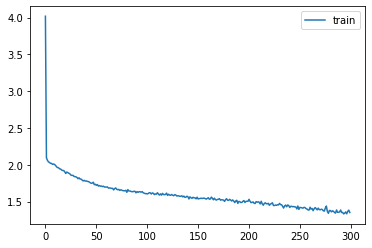

In [74]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.83824   0.50893   0.63333       112
          B2    0.55556   0.03546   0.06667       141
          B1    0.00000   0.00000   0.00000       110
          B0    0.00000   0.00000   0.00000       143
          S0    0.00000   0.00000   0.00000       136
          S1    0.00000   0.00000   0.00000       105
          S2    0.45833   0.08029   0.13665       137
          S3    0.86538   0.38793   0.53571       116

   micro avg    0.76129   0.11800   0.20433      1000
   macro avg    0.33969   0.12658   0.17155      1000
weighted avg    0.33539   0.11800   0.16120      1000
 samples avg    0.11800   0.11800   0.11800      1000

Confusion matrix, without normalization
[[109   3   0   0   0   0   0   0]
 [135   5   0   0   0   1   0   0]
 [110   0   0   0   0   0   0   0]
 [142   0   0   0   0   0   0   1]
 [136   0   0   0   0   0   0   0]
 [103   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


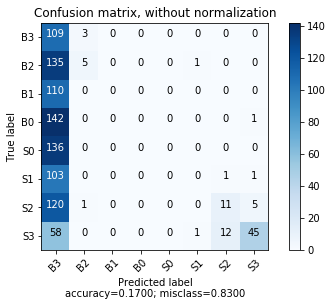

[5, 3, 0, 4, 4, 2, 5, 4, 4, 7, 4, 6, 3, 4, 0, 0, 3, 0, 1, 4, 7, 0, 2, 2, 0, 1, 6, 1, 6, 4, 7, 7, 2, 5, 3, 0, 6, 2, 0, 3, 0, 4, 4, 6, 6, 1, 7, 7, 1, 4, 6, 0, 6, 7, 5, 4, 4, 1, 6, 3, 1, 4, 6, 3, 1, 6, 5, 4, 6, 1, 3, 1, 6, 6, 2, 3, 1, 7, 3, 1, 7, 5, 4, 6, 6, 6, 1, 7, 3, 7, 1, 3, 7, 1, 1, 1, 6, 3, 6, 3, 0, 6, 1, 3, 4, 3, 1, 4, 0, 0, 4, 3, 4, 1, 6, 1, 1, 3, 3, 3, 1, 3, 0, 1, 6, 3, 6, 7, 0, 7, 2, 0, 4, 3, 3, 4, 6, 3, 1, 1, 3, 4, 3, 3, 0, 4, 2, 6, 7, 0, 6, 2, 3, 3, 6, 2, 6, 2, 1, 1, 7, 6, 6, 0, 1, 2, 7, 0, 4, 0, 0, 1, 4, 6, 1, 3, 7, 1, 4, 4, 4, 7, 1, 7, 6, 4, 4, 4, 4, 6, 2, 3, 5, 3, 0, 0, 4, 6, 7, 6, 3, 1, 1, 4, 7, 6, 6, 1, 6, 1, 4, 1, 0, 6, 1, 6, 7, 3, 4, 0, 1, 0, 0, 0, 5, 7, 4, 3, 1, 7, 2, 6, 6, 3, 1, 4, 4, 6, 3, 4, 5, 3, 5, 6, 0, 6, 0, 1, 4, 4, 6, 3, 3, 7, 6, 1, 1, 6, 3, 0, 1, 6, 7, 4, 3, 3, 4, 3, 0, 1, 7, 1, 3, 7, 3, 2, 7, 4, 6, 3, 2, 1, 6, 2, 3, 6, 0, 3, 3, 3, 4, 2, 7, 6, 3, 1, 6, 7, 4, 0, 1, 1, 0, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 1, 4, 4, 1, 1, 5, 2, 4, 2, 7, 7, 4, 6, 4, 6, 4, 1, 2, 4, 3, 

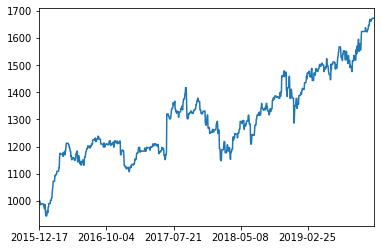

In [75]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 237us/step - loss: 2.0784 - accuracy: 0.1977
Epoch 2/300
3996/3996 [==============================] - 0s 96us/step - loss: 1.9478 - accuracy: 0.2172
Epoch 3/300
3996/3996 [==============================] - 0s 79us/step - loss: 1.9057 - accuracy: 0.2362
Epoch 4/300
3996/3996 [==============================] - 0s 98us/step - loss: 1.8693 - accuracy: 0.2475
Epoch 5/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.8528 - accuracy: 0.2603
Epoch 6/300
3996/3996 [==============================] - 0s 76us/step - loss: 1.8431 - accuracy: 0.2510
Epoch 7/300
3996/3996 [==============================] - 0s 79us/step - loss: 1.8327 - accuracy: 0.2563
Epoch 8/300
3996/3996 [==============================] - 0s 77us/step - loss: 1.8266 - accuracy: 0.2705
Epoch 9/300
3996/3996 [==============================] - 0s 81us/step - loss: 1.8276 - accuracy: 0.2605
Epoch 10/300
3996/3996 [==============================] - 0s 81

3996/3996 [==============================] - 0s 73us/step - loss: 1.6765 - accuracy: 0.3293
Epoch 79/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.6688 - accuracy: 0.3336
Epoch 80/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.6660 - accuracy: 0.3348
Epoch 81/300
3996/3996 [==============================] - 0s 78us/step - loss: 1.6561 - accuracy: 0.3371
Epoch 82/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.6652 - accuracy: 0.3271
Epoch 83/300
3996/3996 [==============================] - 0s 72us/step - loss: 1.6611 - accuracy: 0.3323
Epoch 84/300
3996/3996 [==============================] - 0s 72us/step - loss: 1.6712 - accuracy: 0.3323
Epoch 85/300
3996/3996 [==============================] - 0s 75us/step - loss: 1.6643 - accuracy: 0.3416
Epoch 86/300
3996/3996 [==============================] - 0s 75us/step - loss: 1.6509 - accuracy: 0.3373
Epoch 87/300
3996/3996 [==============================] - 0s 79us/st

3996/3996 [==============================] - 0s 82us/step - loss: 1.6075 - accuracy: 0.3576
Epoch 156/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.6051 - accuracy: 0.3626
Epoch 157/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.6038 - accuracy: 0.3526
Epoch 158/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.6027 - accuracy: 0.3571
Epoch 159/300
3996/3996 [==============================] - 0s 76us/step - loss: 1.6119 - accuracy: 0.3506
Epoch 160/300
3996/3996 [==============================] - 0s 76us/step - loss: 1.6012 - accuracy: 0.3671
Epoch 161/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.6050 - accuracy: 0.3551
Epoch 162/300
3996/3996 [==============================] - 0s 80us/step - loss: 1.6047 - accuracy: 0.3604
Epoch 163/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.6014 - accuracy: 0.3686
Epoch 164/300
3996/3996 [==============================] - 0

Epoch 232/300
3996/3996 [==============================] - 0s 108us/step - loss: 1.5740 - accuracy: 0.3644
Epoch 233/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.5962 - accuracy: 0.3599
Epoch 234/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.5777 - accuracy: 0.3596
Epoch 235/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.5729 - accuracy: 0.3729
Epoch 236/300
3996/3996 [==============================] - 0s 114us/step - loss: 1.5943 - accuracy: 0.3664
Epoch 237/300
3996/3996 [==============================] - 0s 123us/step - loss: 1.5897 - accuracy: 0.3696
Epoch 238/300
3996/3996 [==============================] - 1s 202us/step - loss: 1.5937 - accuracy: 0.3614
Epoch 239/300
3996/3996 [==============================] - 1s 127us/step - loss: 1.5781 - accuracy: 0.3734
Epoch 240/300
3996/3996 [==============================] - 1s 154us/step - loss: 1.5716 - accuracy: 0.3824
Epoch 241/300
3996/3996 [===============

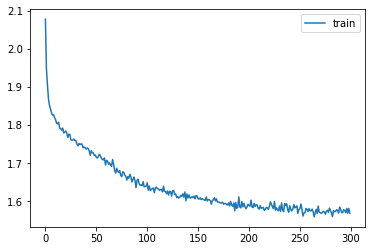

In [76]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.62162   0.47917   0.54118        96
          B2    0.00000   0.00000   0.00000       139
          B1    0.00000   0.00000   0.00000       121
          B0    0.00000   0.00000   0.00000       131
          S0    0.00000   0.00000   0.00000       140
          S1    0.00000   0.00000   0.00000       117
          S2    0.33333   0.00709   0.01389       141
          S3    0.78378   0.25217   0.38158       115

   micro avg    0.66667   0.07600   0.13645      1000
   macro avg    0.21734   0.09230   0.11708      1000
weighted avg    0.19681   0.07600   0.09779      1000
 samples avg    0.07600   0.07600   0.07600      1000

Confusion matrix, without normalization
[[ 96   0   0   0   0   0   0   0]
 [139   0   0   0   0   0   0   0]
 [120   0   0   0   0   0   0   1]
 [131   0   0   0   0   0   0   0]
 [140   0   0   0   0   0   0   0]
 [115   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


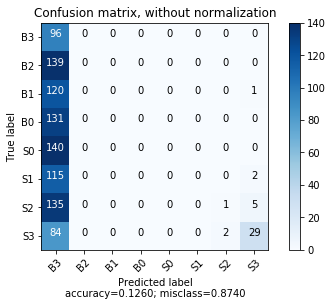

[4, 6, 0, 1, 6, 1, 6, 3, 1, 6, 4, 1, 3, 6, 3, 6, 6, 6, 6, 1, 3, 4, 4, 3, 4, 4, 5, 1, 1, 5, 4, 3, 0, 4, 0, 6, 0, 1, 1, 1, 0, 3, 3, 3, 7, 6, 3, 6, 7, 6, 7, 3, 4, 0, 6, 5, 3, 6, 1, 6, 4, 1, 6, 1, 6, 6, 7, 1, 7, 3, 6, 6, 6, 1, 4, 6, 6, 1, 0, 6, 0, 1, 1, 0, 4, 6, 6, 4, 1, 0, 1, 6, 7, 6, 6, 4, 0, 6, 1, 2, 0, 6, 0, 1, 6, 1, 6, 1, 6, 6, 6, 1, 0, 0, 3, 3, 6, 6, 6, 4, 6, 4, 3, 1, 6, 7, 6, 3, 3, 6, 0, 6, 6, 1, 4, 1, 4, 6, 4, 0, 3, 6, 1, 3, 4, 0, 0, 1, 6, 3, 0, 0, 6, 0, 1, 1, 7, 6, 0, 4, 1, 6, 1, 3, 3, 4, 6, 6, 4, 0, 1, 7, 0, 6, 6, 3, 3, 7, 6, 7, 1, 1, 4, 7, 0, 6, 1, 4, 6, 0, 4, 3, 7, 3, 6, 4, 3, 1, 7, 6, 6, 1, 4, 2, 4, 1, 7, 6, 7, 1, 1, 7, 5, 7, 4, 0, 0, 6, 0, 4, 1, 3, 4, 3, 7, 3, 6, 3, 6, 6, 6, 0, 1, 6, 0, 4, 6, 4, 7, 1, 0, 6, 6, 3, 3, 1, 6, 6, 1, 1, 6, 6, 1, 6, 0, 6, 1, 0, 1, 1, 0, 4, 4, 6, 6, 3, 4, 3, 4, 7, 7, 1, 4, 1, 6, 6, 1, 6, 0, 3, 0, 7, 4, 4, 6, 1, 6, 3, 6, 5, 6, 6, 0, 1, 1, 6, 6, 1, 4, 1, 0, 0, 4, 4, 1, 6, 7, 1, 4, 7, 0, 1, 0, 0, 6, 0, 0, 3, 1, 2, 6, 7, 1, 6, 4, 0, 4, 4, 6, 4, 3, 0, 3, 

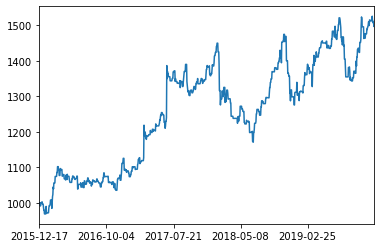

In [77]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 206us/step - loss: 2.0066 - accuracy: 0.2105
Epoch 2/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.8689 - accuracy: 0.2563
Epoch 3/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.8296 - accuracy: 0.2623
Epoch 4/300
3996/3996 [==============================] - 0s 96us/step - loss: 1.8170 - accuracy: 0.2703
Epoch 5/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.7886 - accuracy: 0.2820
Epoch 6/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.7808 - accuracy: 0.2893
Epoch 7/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.7711 - accuracy: 0.2840
Epoch 8/300
3996/3996 [==============================] - 1s 167us/step - loss: 1.7604 - accuracy: 0.2808
Epoch 9/300
3996/3996 [==============================] - 1s 156us/step - loss: 1.7558 - accuracy: 0.29200s - loss: 1.7567 - accuracy: 0.
Epoch 10/300
3996/3996 [=====

3996/3996 [==============================] - 0s 94us/step - loss: 1.1684 - accuracy: 0.5133
Epoch 79/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.1530 - accuracy: 0.5263
Epoch 80/300
3996/3996 [==============================] - 0s 98us/step - loss: 1.1463 - accuracy: 0.5215
Epoch 81/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.1558 - accuracy: 0.5100
Epoch 82/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.1679 - accuracy: 0.5123
Epoch 83/300
3996/3996 [==============================] - 0s 118us/step - loss: 1.1273 - accuracy: 0.5303
Epoch 84/300
3996/3996 [==============================] - 0s 101us/step - loss: 1.1543 - accuracy: 0.5093
Epoch 85/300
3996/3996 [==============================] - 0s 108us/step - loss: 1.1370 - accuracy: 0.5265
Epoch 86/300
3996/3996 [==============================] - 0s 88us/step - loss: 1.1393 - accuracy: 0.5245
Epoch 87/300
3996/3996 [==============================] - 0s 103u

3996/3996 [==============================] - 0s 82us/step - loss: 0.9973 - accuracy: 0.5866
Epoch 156/300
3996/3996 [==============================] - 0s 97us/step - loss: 0.9877 - accuracy: 0.5808
Epoch 157/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.9791 - accuracy: 0.5798
Epoch 158/300
3996/3996 [==============================] - 0s 87us/step - loss: 0.9813 - accuracy: 0.5868
Epoch 159/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.9836 - accuracy: 0.5863
Epoch 160/300
3996/3996 [==============================] - 0s 101us/step - loss: 1.0056 - accuracy: 0.5731
Epoch 161/300
3996/3996 [==============================] - 0s 91us/step - loss: 0.9934 - accuracy: 0.5808
Epoch 162/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.0143 - accuracy: 0.5678
Epoch 163/300
3996/3996 [==============================] - 1s 130us/step - loss: 0.9846 - accuracy: 0.5756
Epoch 164/300
3996/3996 [==============================] 

3996/3996 [==============================] - 0s 97us/step - loss: 0.9829 - accuracy: 0.5861
Epoch 232/300
3996/3996 [==============================] - 0s 92us/step - loss: 0.9980 - accuracy: 0.5748
Epoch 233/300
3996/3996 [==============================] - 0s 88us/step - loss: 0.9773 - accuracy: 0.5878
Epoch 234/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.9103 - accuracy: 0.6064
Epoch 235/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.9319 - accuracy: 0.6049
Epoch 236/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.9155 - accuracy: 0.6051
Epoch 237/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.9080 - accuracy: 0.6204
Epoch 238/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.9234 - accuracy: 0.5966
Epoch 239/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.9838 - accuracy: 0.58560s - loss: 1.0043 - accuracy: 0.55 - ETA: 0s - loss: 0.9

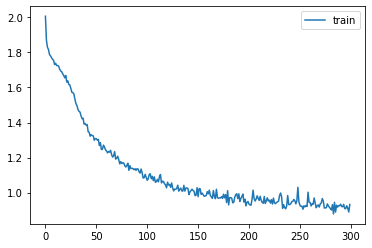

In [78]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.72632   0.71875   0.72251        96
          B2    0.64151   0.48921   0.55510       139
          B1    0.65116   0.23140   0.34146       121
          B0    0.70787   0.48092   0.57273       131
          S0    0.74194   0.49286   0.59227       140
          S1    0.58730   0.31624   0.41111       117
          S2    0.62500   0.39007   0.48035       141
          S3    0.89062   0.49565   0.63687       115

   micro avg    0.69579   0.44600   0.54357      1000
   macro avg    0.69646   0.45189   0.53905      1000
weighted avg    0.69355   0.44600   0.53485      1000
 samples avg    0.44600   0.44600   0.44600      1000

Confusion matrix, without normalization
[[73 21  2  0  0  0  0  0]
 [63 68  8  0  0  0  0  0]
 [72 17 28  3  0  1  0  0]
 [64  0  4 63  0  0  0  0]
 [50  0  0 20 69  1  0  0]
 [52  0  1  1 21 37  5  0]
 [52  0  0  1  3 23 55

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


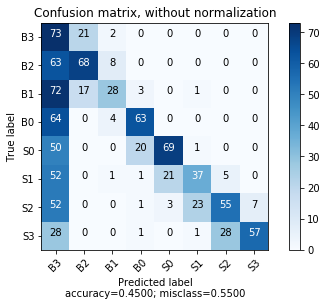

[3, 5, 1, 2, 4, 4, 0, 2, 1, 2, 5, 1, 3, 4, 6, 4, 5, 6, 6, 1, 1, 4, 4, 3, 5, 3, 6, 2, 1, 6, 4, 3, 3, 6, 1, 3, 0, 1, 2, 1, 1, 1, 3, 1, 6, 3, 3, 5, 7, 6, 7, 4, 2, 1, 3, 4, 1, 4, 1, 6, 5, 1, 2, 3, 7, 6, 7, 1, 1, 4, 5, 4, 7, 1, 2, 7, 6, 1, 3, 7, 1, 1, 1, 0, 2, 6, 4, 6, 1, 0, 3, 5, 4, 6, 2, 3, 0, 4, 0, 2, 0, 5, 0, 3, 7, 4, 6, 3, 6, 6, 7, 3, 0, 1, 3, 3, 7, 3, 6, 5, 4, 4, 2, 1, 6, 6, 5, 2, 1, 5, 0, 1, 5, 1, 3, 4, 6, 3, 2, 0, 2, 3, 1, 2, 3, 0, 0, 1, 6, 3, 0, 4, 5, 0, 1, 0, 6, 7, 0, 3, 2, 3, 1, 3, 3, 5, 6, 2, 5, 0, 3, 7, 0, 4, 4, 4, 3, 7, 6, 7, 1, 1, 2, 7, 0, 5, 2, 5, 5, 1, 6, 3, 6, 1, 3, 2, 3, 1, 7, 6, 4, 1, 4, 6, 4, 3, 5, 6, 6, 1, 1, 6, 4, 4, 5, 0, 5, 4, 0, 4, 2, 3, 1, 4, 7, 6, 4, 4, 6, 3, 4, 0, 2, 3, 0, 4, 6, 3, 6, 4, 0, 6, 4, 2, 3, 2, 6, 4, 1, 2, 6, 1, 1, 6, 0, 4, 2, 0, 4, 0, 0, 3, 3, 2, 6, 2, 4, 2, 4, 7, 7, 4, 2, 0, 6, 5, 0, 7, 1, 3, 1, 5, 2, 4, 4, 1, 6, 5, 5, 5, 5, 1, 0, 1, 1, 6, 5, 1, 4, 2, 1, 0, 3, 3, 5, 6, 5, 2, 2, 7, 0, 1, 3, 0, 4, 0, 0, 2, 4, 1, 7, 5, 4, 6, 4, 1, 4, 3, 4, 4, 3, 1, 4, 

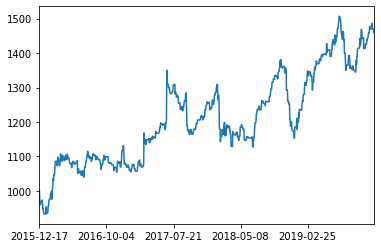

In [79]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 262us/step - loss: 2.0256 - accuracy: 0.2252
Epoch 2/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.8557 - accuracy: 0.2578
Epoch 3/300
3996/3996 [==============================] - 0s 113us/step - loss: 1.8186 - accuracy: 0.2645
Epoch 4/300
3996/3996 [==============================] - 0s 98us/step - loss: 1.7795 - accuracy: 0.2888
Epoch 5/300
3996/3996 [==============================] - 0s 100us/step - loss: 1.7578 - accuracy: 0.2920
Epoch 6/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.7438 - accuracy: 0.3051
Epoch 7/300
3996/3996 [==============================] - 0s 100us/step - loss: 1.7196 - accuracy: 0.3113
Epoch 8/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.7068 - accuracy: 0.3038
Epoch 9/300
3996/3996 [==============================] - 0s 105us/step - loss: 1.6955 - accuracy: 0.3206
Epoch 10/300
3996/3996 [==============================] - 0

3996/3996 [==============================] - 0s 92us/step - loss: 1.3654 - accuracy: 0.4247
Epoch 79/300
3996/3996 [==============================] - 1s 135us/step - loss: 1.3398 - accuracy: 0.4439
Epoch 80/300
3996/3996 [==============================] - 0s 122us/step - loss: 1.3643 - accuracy: 0.4407
Epoch 81/300
3996/3996 [==============================] - 0s 124us/step - loss: 1.3476 - accuracy: 0.4479
Epoch 82/300
3996/3996 [==============================] - 0s 102us/step - loss: 1.3275 - accuracy: 0.4432
Epoch 83/300
3996/3996 [==============================] - 0s 116us/step - loss: 1.3303 - accuracy: 0.4479
Epoch 84/300
3996/3996 [==============================] - 0s 122us/step - loss: 1.3306 - accuracy: 0.4499
Epoch 85/300
3996/3996 [==============================] - 1s 140us/step - loss: 1.3285 - accuracy: 0.4462
Epoch 86/300
3996/3996 [==============================] - 1s 127us/step - loss: 1.3202 - accuracy: 0.4492
Epoch 87/300
3996/3996 [==============================] - 0s

3996/3996 [==============================] - 1s 194us/step - loss: 1.1040 - accuracy: 0.5300
Epoch 155/300
3996/3996 [==============================] - 1s 161us/step - loss: 1.1114 - accuracy: 0.53080s - loss: 1.0923 
Epoch 156/300
3996/3996 [==============================] - 0s 100us/step - loss: 1.1006 - accuracy: 0.5338
Epoch 157/300
3996/3996 [==============================] - 0s 125us/step - loss: 1.1233 - accuracy: 0.5245
Epoch 158/300
3996/3996 [==============================] - 0s 95us/step - loss: 1.0815 - accuracy: 0.5445
Epoch 159/300
3996/3996 [==============================] - 1s 167us/step - loss: 1.1241 - accuracy: 0.5278
Epoch 160/300
3996/3996 [==============================] - 0s 110us/step - loss: 1.1112 - accuracy: 0.5403
Epoch 161/300
3996/3996 [==============================] - 1s 268us/step - loss: 1.1328 - accuracy: 0.5288
Epoch 162/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.0734 - accuracy: 0.5485
Epoch 163/300
3996/3996 [==========

3996/3996 [==============================] - 0s 117us/step - loss: 1.0087 - accuracy: 0.5743
Epoch 231/300
3996/3996 [==============================] - 1s 127us/step - loss: 1.0140 - accuracy: 0.5723
Epoch 232/300
3996/3996 [==============================] - 0s 101us/step - loss: 1.0114 - accuracy: 0.5681
Epoch 233/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.9977 - accuracy: 0.5861
Epoch 234/300
3996/3996 [==============================] - 0s 100us/step - loss: 1.0033 - accuracy: 0.5801
Epoch 235/300
3996/3996 [==============================] - 0s 106us/step - loss: 1.0008 - accuracy: 0.5796
Epoch 236/300
3996/3996 [==============================] - 0s 113us/step - loss: 1.0027 - accuracy: 0.5786
Epoch 237/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.9792 - accuracy: 0.5836
Epoch 238/300
3996/3996 [==============================] - 0s 92us/step - loss: 1.0086 - accuracy: 0.5758
Epoch 239/300
3996/3996 [===========================

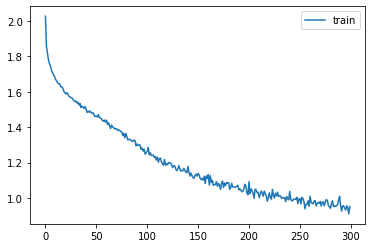

In [80]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.67308   0.72917   0.70000        96
          B2    0.60194   0.44604   0.51240       139
          B1    0.68750   0.18182   0.28758       121
          B0    0.65000   0.49618   0.56277       131
          S0    0.56481   0.43571   0.49194       140
          S1    0.36364   0.03419   0.06250       117
          S2    0.60952   0.45390   0.52033       141
          S3    0.89062   0.49565   0.63687       115

   micro avg    0.64593   0.40500   0.49785      1000
   macro avg    0.63014   0.40908   0.47180      1000
weighted avg    0.62661   0.40500   0.46973      1000
 samples avg    0.40500   0.40500   0.40500      1000

Confusion matrix, without normalization
[[77 17  1  1  0  0  0  0]
 [70 62  5  2  0  0  0  0]
 [70 22 22  6  1  0  0  0]
 [58  2  3 65  3  0  0  0]
 [54  0  0 24 61  1  0  0]
 [68  0  0  1 33  4 11  0]
 [53  0  0  1 10  6 64

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


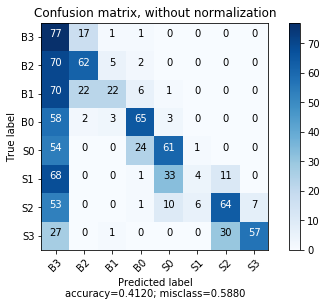

[3, 6, 0, 1, 4, 4, 1, 2, 2, 3, 6, 3, 3, 4, 6, 4, 6, 4, 6, 2, 1, 4, 4, 3, 6, 3, 6, 2, 1, 6, 4, 3, 0, 6, 1, 3, 0, 0, 2, 0, 3, 1, 3, 1, 6, 3, 3, 5, 7, 6, 7, 4, 2, 1, 3, 4, 1, 4, 1, 6, 4, 0, 3, 3, 7, 4, 7, 1, 0, 4, 4, 4, 6, 2, 2, 7, 6, 1, 2, 7, 1, 1, 2, 0, 1, 6, 4, 4, 1, 0, 1, 6, 4, 6, 3, 3, 0, 4, 0, 2, 1, 5, 0, 3, 7, 3, 6, 3, 6, 6, 7, 3, 0, 0, 3, 3, 7, 3, 6, 6, 4, 5, 4, 1, 5, 6, 6, 2, 1, 5, 0, 1, 5, 1, 3, 2, 6, 4, 1, 0, 2, 3, 1, 2, 4, 0, 4, 1, 6, 3, 0, 4, 4, 0, 4, 0, 5, 7, 0, 3, 2, 3, 0, 3, 3, 4, 6, 1, 5, 0, 3, 7, 0, 4, 4, 4, 3, 7, 6, 7, 2, 1, 1, 7, 0, 4, 2, 5, 4, 0, 6, 3, 6, 2, 4, 2, 3, 1, 7, 6, 4, 2, 4, 4, 4, 3, 5, 7, 7, 1, 1, 6, 4, 4, 5, 0, 6, 4, 0, 4, 2, 3, 1, 4, 6, 6, 4, 3, 6, 4, 4, 0, 1, 3, 0, 4, 5, 3, 6, 4, 0, 6, 4, 2, 3, 2, 6, 4, 2, 2, 6, 2, 2, 6, 2, 4, 2, 3, 3, 0, 0, 3, 3, 3, 4, 2, 4, 3, 3, 7, 7, 4, 3, 1, 6, 5, 0, 7, 0, 1, 1, 3, 3, 4, 4, 2, 6, 6, 6, 6, 4, 1, 0, 1, 0, 6, 5, 2, 4, 2, 0, 0, 3, 3, 4, 6, 6, 2, 2, 7, 1, 1, 4, 0, 4, 0, 0, 2, 3, 1, 6, 3, 4, 6, 4, 1, 4, 4, 4, 4, 3, 1, 3, 

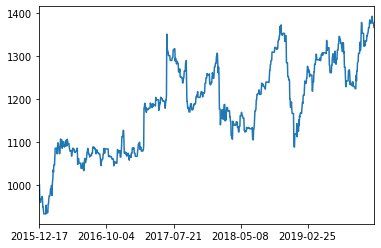

In [81]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 379us/step - loss: 3.8082 - accuracy: 0.1632A: 4s - loss: 13.1
Epoch 2/300
3996/3996 [==============================] - 1s 126us/step - loss: 2.0642 - accuracy: 0.1787
Epoch 3/300
3996/3996 [==============================] - 0s 108us/step - loss: 2.0284 - accuracy: 0.1992
Epoch 4/300
3996/3996 [==============================] - 0s 97us/step - loss: 2.0029 - accuracy: 0.2157
Epoch 5/300
3996/3996 [==============================] - 0s 100us/step - loss: 1.9759 - accuracy: 0.2192
Epoch 6/300
3996/3996 [==============================] - 0s 99us/step - loss: 1.9723 - accuracy: 0.2262
Epoch 7/300
3996/3996 [==============================] - 0s 98us/step - loss: 1.9520 - accuracy: 0.2332
Epoch 8/300
3996/3996 [==============================] - 1s 180us/step - loss: 1.9298 - accuracy: 0.2462
Epoch 9/300
3996/3996 [==============================] - 0s 124us/step - loss: 1.9223 - accuracy: 0.2450
Epoch 10/300
3996/3996 [================

3996/3996 [==============================] - 0s 90us/step - loss: 1.5453 - accuracy: 0.3854
Epoch 79/300
3996/3996 [==============================] - 0s 98us/step - loss: 1.5489 - accuracy: 0.3796
Epoch 80/300
3996/3996 [==============================] - 0s 101us/step - loss: 1.5343 - accuracy: 0.3816
Epoch 81/300
3996/3996 [==============================] - 0s 99us/step - loss: 1.5442 - accuracy: 0.3769
Epoch 82/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.5381 - accuracy: 0.3756
Epoch 83/300
3996/3996 [==============================] - 0s 84us/step - loss: 1.5168 - accuracy: 0.3849
Epoch 84/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.5095 - accuracy: 0.3914
Epoch 85/300
3996/3996 [==============================] - 0s 84us/step - loss: 1.5306 - accuracy: 0.3879
Epoch 86/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.5237 - accuracy: 0.3909
Epoch 87/300
3996/3996 [==============================] - 0s 90us/s

3996/3996 [==============================] - 0s 87us/step - loss: 1.4298 - accuracy: 0.4192
Epoch 156/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.4113 - accuracy: 0.4242
Epoch 157/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.4299 - accuracy: 0.4142
Epoch 158/300
3996/3996 [==============================] - 0s 79us/step - loss: 1.4332 - accuracy: 0.4122
Epoch 159/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.4205 - accuracy: 0.4257
Epoch 160/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.4336 - accuracy: 0.4064
Epoch 161/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.4271 - accuracy: 0.4249
Epoch 162/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.4112 - accuracy: 0.4237
Epoch 163/300
3996/3996 [==============================] - 0s 96us/step - loss: 1.4240 - accuracy: 0.4252
Epoch 164/300
3996/3996 [==============================] - 0

3996/3996 [==============================] - 1s 357us/step - loss: 1.3825 - accuracy: 0.4347
Epoch 233/300
3996/3996 [==============================] - 1s 346us/step - loss: 1.3775 - accuracy: 0.44440s - loss: 1.3763 - accu
Epoch 234/300
3996/3996 [==============================] - 1s 232us/step - loss: 1.3999 - accuracy: 0.4277
Epoch 235/300
3996/3996 [==============================] - 2s 447us/step - loss: 1.3737 - accuracy: 0.4369
Epoch 236/300
3996/3996 [==============================] - 1s 190us/step - loss: 1.3659 - accuracy: 0.4329
Epoch 237/300
3996/3996 [==============================] - 1s 158us/step - loss: 1.3504 - accuracy: 0.4449
Epoch 238/300
3996/3996 [==============================] - 1s 143us/step - loss: 1.3718 - accuracy: 0.4354
Epoch 239/300
3996/3996 [==============================] - 1s 139us/step - loss: 1.3600 - accuracy: 0.4407
Epoch 240/300
3996/3996 [==============================] - 1s 129us/step - loss: 1.3848 - accuracy: 0.4309
Epoch 241/300
3996/3996 [==

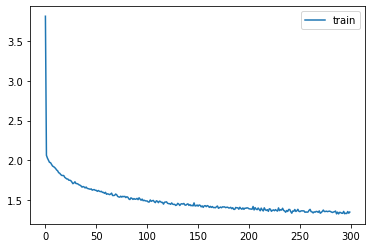

In [82]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.57692   0.31250   0.40541        96
          B2    0.37500   0.04317   0.07742       139
          B1    0.00000   0.00000   0.00000       121
          B0    0.20000   0.00763   0.01471       131
          S0    0.37500   0.02143   0.04054       140
          S1    0.25000   0.02564   0.04651       117
          S2    0.15385   0.01418   0.02597       141
          S3    0.62712   0.32174   0.42529       115

   micro avg    0.49398   0.08200   0.14065      1000
   macro avg    0.31974   0.09329   0.12948      1000
weighted avg    0.30927   0.08200   0.11529      1000
 samples avg    0.08200   0.08200   0.08200      1000

Confusion matrix, without normalization
[[ 86   3   1   1   0   1   2   2]
 [130   6   0   0   2   0   0   1]
 [118   1   0   0   1   0   1   0]
 [128   1   0   1   0   0   1   0]
 [128   2   0   0   3   2   2   3]
 [107   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


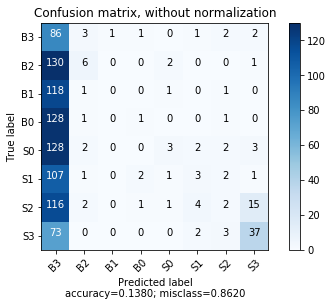

[4, 4, 1, 1, 4, 0, 6, 3, 3, 4, 3, 4, 4, 4, 5, 7, 7, 2, 5, 1, 3, 4, 5, 5, 4, 4, 6, 3, 3, 4, 5, 4, 0, 5, 5, 4, 0, 1, 4, 1, 3, 2, 3, 5, 7, 5, 3, 6, 7, 6, 7, 4, 3, 1, 6, 4, 3, 6, 3, 6, 4, 1, 3, 1, 6, 6, 7, 2, 3, 4, 5, 1, 5, 3, 4, 6, 5, 2, 0, 6, 1, 3, 1, 1, 2, 6, 6, 6, 1, 0, 4, 5, 6, 6, 1, 3, 0, 4, 1, 3, 0, 5, 1, 2, 6, 4, 6, 3, 6, 5, 6, 1, 2, 1, 4, 4, 4, 6, 6, 4, 5, 6, 4, 3, 5, 6, 6, 4, 2, 5, 1, 3, 7, 3, 4, 1, 3, 6, 2, 2, 3, 4, 3, 3, 6, 7, 6, 1, 6, 4, 0, 6, 5, 0, 3, 1, 6, 6, 1, 3, 3, 3, 1, 4, 4, 0, 7, 6, 4, 1, 6, 7, 6, 4, 3, 6, 4, 7, 7, 3, 3, 1, 3, 7, 0, 7, 4, 5, 2, 1, 5, 3, 7, 3, 4, 2, 4, 3, 7, 3, 5, 1, 6, 7, 5, 2, 6, 7, 7, 2, 1, 5, 5, 3, 6, 0, 7, 4, 1, 5, 3, 1, 2, 4, 7, 4, 6, 3, 6, 6, 5, 1, 2, 5, 0, 4, 6, 4, 7, 3, 0, 6, 4, 2, 4, 3, 7, 6, 1, 1, 6, 3, 3, 6, 2, 1, 1, 2, 4, 0, 0, 1, 5, 3, 4, 3, 4, 4, 4, 5, 7, 4, 4, 4, 6, 6, 1, 6, 0, 3, 0, 6, 4, 0, 6, 3, 6, 6, 6, 5, 6, 6, 1, 2, 0, 5, 7, 3, 5, 4, 1, 2, 4, 3, 4, 5, 6, 3, 4, 6, 2, 3, 3, 0, 4, 3, 0, 3, 4, 3, 6, 5, 6, 6, 7, 1, 6, 4, 5, 7, 4, 1, 3, 

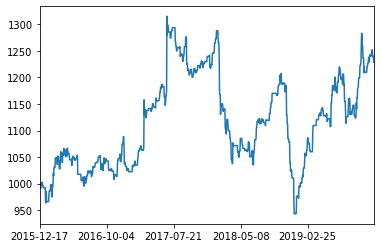

In [83]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 202us/step - loss: 2.0505 - accuracy: 0.1754
Epoch 2/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.9251 - accuracy: 0.2380
Epoch 3/300
3992/3992 [==============================] - 0s 103us/step - loss: 1.8757 - accuracy: 0.2462
Epoch 4/300
3992/3992 [==============================] - 0s 103us/step - loss: 1.8561 - accuracy: 0.2613
Epoch 5/300
3992/3992 [==============================] - 0s 124us/step - loss: 1.8388 - accuracy: 0.2650
Epoch 6/300
3992/3992 [==============================] - 0s 98us/step - loss: 1.8349 - accuracy: 0.2575
Epoch 7/300
3992/3992 [==============================] - 0s 100us/step - loss: 1.8152 - accuracy: 0.2633
Epoch 8/300
3992/3992 [==============================] - 0s 92us/step - loss: 1.8123 - accuracy: 0.2743
Epoch 9/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.8093 - accuracy: 0.2715
Epoch 10/300
3992/3992 [==============================] - 0

3992/3992 [==============================] - 0s 73us/step - loss: 1.6405 - accuracy: 0.3324
Epoch 80/300
3992/3992 [==============================] - 0s 80us/step - loss: 1.6461 - accuracy: 0.3404
Epoch 81/300
3992/3992 [==============================] - 0s 71us/step - loss: 1.6413 - accuracy: 0.3347
Epoch 82/300
3992/3992 [==============================] - 0s 72us/step - loss: 1.6420 - accuracy: 0.3327
Epoch 83/300
3992/3992 [==============================] - 0s 75us/step - loss: 1.6470 - accuracy: 0.3287
Epoch 84/300
3992/3992 [==============================] - 0s 72us/step - loss: 1.6335 - accuracy: 0.3389
Epoch 85/300
3992/3992 [==============================] - 0s 72us/step - loss: 1.6356 - accuracy: 0.3337
Epoch 86/300
3992/3992 [==============================] - 0s 72us/step - loss: 1.6312 - accuracy: 0.3417
Epoch 87/300
3992/3992 [==============================] - 0s 72us/step - loss: 1.6370 - accuracy: 0.3472
Epoch 88/300
3992/3992 [==============================] - 0s 72us/st

3992/3992 [==============================] - 0s 78us/step - loss: 1.5512 - accuracy: 0.3785
Epoch 157/300
3992/3992 [==============================] - 0s 77us/step - loss: 1.5643 - accuracy: 0.3747
Epoch 158/300
3992/3992 [==============================] - 0s 77us/step - loss: 1.5682 - accuracy: 0.3665
Epoch 159/300
3992/3992 [==============================] - 0s 74us/step - loss: 1.5589 - accuracy: 0.3742
Epoch 160/300
3992/3992 [==============================] - 0s 76us/step - loss: 1.5687 - accuracy: 0.3773
Epoch 161/300
3992/3992 [==============================] - 0s 75us/step - loss: 1.5643 - accuracy: 0.3645
Epoch 162/300
3992/3992 [==============================] - 0s 74us/step - loss: 1.5732 - accuracy: 0.3690
Epoch 163/300
3992/3992 [==============================] - 0s 75us/step - loss: 1.5616 - accuracy: 0.3682
Epoch 164/300
3992/3992 [==============================] - 0s 74us/step - loss: 1.5707 - accuracy: 0.3642
Epoch 165/300
3992/3992 [==============================] - 0

3992/3992 [==============================] - 0s 92us/step - loss: 1.5344 - accuracy: 0.3793
Epoch 234/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.5229 - accuracy: 0.3978
Epoch 235/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.5311 - accuracy: 0.3803
Epoch 236/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.5274 - accuracy: 0.3840
Epoch 237/300
3992/3992 [==============================] - 0s 122us/step - loss: 1.5359 - accuracy: 0.3828
Epoch 238/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.5243 - accuracy: 0.3968
Epoch 239/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.5267 - accuracy: 0.3835
Epoch 240/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.5179 - accuracy: 0.3818
Epoch 241/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.5311 - accuracy: 0.3818
Epoch 242/300
3992/3992 [==============================] - 

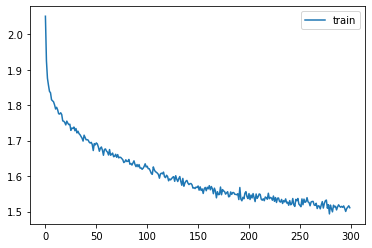

In [84]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.83019   0.36975   0.51163       119
          B2    0.00000   0.00000   0.00000       127
          B1    0.00000   0.00000   0.00000       108
          B0    0.00000   0.00000   0.00000       129
          S0    0.00000   0.00000   0.00000       131
          S1    0.00000   0.00000   0.00000       113
          S2    0.40000   0.03871   0.07059       155
          S3    0.73810   0.26496   0.38994       117

   micro avg    0.71053   0.08108   0.14555       999
   macro avg    0.24604   0.08418   0.12152       999
weighted avg    0.24740   0.08108   0.11757       999
 samples avg    0.08108   0.08108   0.08108       999

Confusion matrix, without normalization
[[116   0   0   2   0   0   0   1]
 [127   0   0   0   0   0   0   0]
 [107   0   0   0   0   0   1   0]
 [128   0   0   0   0   0   0   1]
 [131   0   0   0   0   0   0   0]
 [110   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


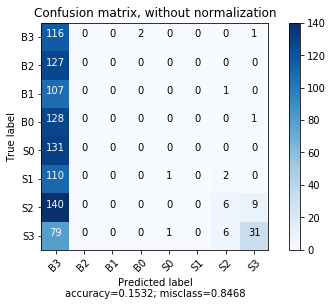

[1, 1, 4, 1, 6, 5, 3, 4, 2, 4, 4, 6, 2, 6, 0, 6, 1, 3, 1, 3, 4, 0, 7, 1, 6, 1, 6, 3, 4, 0, 6, 2, 3, 4, 4, 4, 6, 5, 4, 0, 0, 4, 4, 0, 4, 1, 1, 4, 1, 3, 3, 6, 6, 1, 2, 7, 6, 6, 3, 1, 4, 0, 3, 4, 1, 0, 4, 3, 6, 3, 0, 6, 6, 0, 3, 0, 6, 1, 3, 4, 1, 6, 4, 4, 5, 0, 4, 5, 6, 6, 3, 6, 7, 6, 6, 6, 6, 4, 0, 0, 4, 7, 3, 6, 3, 3, 7, 4, 2, 0, 4, 2, 6, 4, 2, 6, 6, 6, 2, 6, 6, 4, 1, 1, 1, 3, 4, 4, 1, 0, 7, 3, 4, 5, 3, 6, 7, 3, 6, 4, 2, 4, 0, 1, 2, 0, 6, 4, 4, 6, 0, 4, 6, 3, 1, 0, 4, 0, 6, 6, 4, 6, 1, 7, 1, 6, 6, 4, 2, 1, 6, 0, 6, 0, 4, 4, 7, 0, 1, 6, 6, 4, 6, 6, 4, 4, 4, 7, 6, 4, 0, 3, 3, 2, 1, 0, 7, 7, 4, 6, 3, 1, 3, 6, 0, 2, 0, 4, 1, 7, 1, 2, 4, 4, 7, 4, 6, 4, 6, 4, 0, 1, 1, 1, 6, 1, 4, 4, 7, 1, 0, 6, 7, 3, 6, 6, 2, 6, 6, 4, 4, 7, 4, 6, 4, 4, 1, 1, 6, 6, 1, 5, 4, 1, 7, 5, 6, 4, 1, 7, 6, 4, 4, 1, 4, 0, 1, 1, 4, 4, 6, 1, 1, 3, 1, 4, 4, 3, 1, 4, 4, 6, 1, 3, 0, 4, 4, 6, 3, 1, 1, 6, 1, 4, 0, 0, 7, 1, 0, 4, 4, 6, 3, 1, 4, 1, 6, 0, 7, 4, 1, 6, 7, 1, 4, 0, 0, 6, 1, 4, 5, 2, 4, 6, 1, 1, 6, 4, 4, 7, 4, 1, 3, 

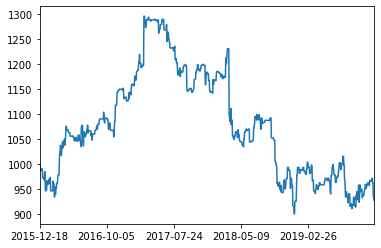

In [85]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 202us/step - loss: 2.0200 - accuracy: 0.1994
Epoch 2/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.8985 - accuracy: 0.2380
Epoch 3/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.8415 - accuracy: 0.2598
Epoch 4/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.8176 - accuracy: 0.2605
Epoch 5/300
3992/3992 [==============================] - 0s 97us/step - loss: 1.7995 - accuracy: 0.2698
Epoch 6/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.7793 - accuracy: 0.2788
Epoch 7/300
3992/3992 [==============================] - 0s 99us/step - loss: 1.7664 - accuracy: 0.2888
Epoch 8/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.7503 - accuracy: 0.2966
Epoch 9/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.7392 - accuracy: 0.2968
Epoch 10/300
3992/3992 [==============================] - 0s 95

3992/3992 [==============================] - 0s 93us/step - loss: 1.1960 - accuracy: 0.4960
Epoch 80/300
3992/3992 [==============================] - 0s 98us/step - loss: 1.2110 - accuracy: 0.5095
Epoch 81/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.2305 - accuracy: 0.4837
Epoch 82/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.2315 - accuracy: 0.4820
Epoch 83/300
3992/3992 [==============================] - 0s 100us/step - loss: 1.2048 - accuracy: 0.5003
Epoch 84/300
3992/3992 [==============================] - 0s 98us/step - loss: 1.2210 - accuracy: 0.4997
Epoch 85/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.2018 - accuracy: 0.4965
Epoch 86/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.2028 - accuracy: 0.5018
Epoch 87/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.1911 - accuracy: 0.4917
Epoch 88/300
3992/3992 [==============================] - 0s 96us/s

3992/3992 [==============================] - 0s 103us/step - loss: 1.0723 - accuracy: 0.5571
Epoch 156/300
3992/3992 [==============================] - 0s 106us/step - loss: 1.0939 - accuracy: 0.5423
Epoch 157/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.0312 - accuracy: 0.5641
Epoch 158/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.1093 - accuracy: 0.5318
Epoch 159/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.0852 - accuracy: 0.5353
Epoch 160/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.0418 - accuracy: 0.5611
Epoch 161/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.0830 - accuracy: 0.5493
Epoch 162/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.0654 - accuracy: 0.5463
Epoch 163/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.0465 - accuracy: 0.5671
Epoch 164/300
3992/3992 [==============================] -

3992/3992 [==============================] - 0s 109us/step - loss: 0.9808 - accuracy: 0.5714
Epoch 232/300
3992/3992 [==============================] - 0s 125us/step - loss: 0.9901 - accuracy: 0.5877
Epoch 233/300
3992/3992 [==============================] - 1s 127us/step - loss: 1.0098 - accuracy: 0.5739
Epoch 234/300
3992/3992 [==============================] - 0s 116us/step - loss: 0.9796 - accuracy: 0.5904
Epoch 235/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.9537 - accuracy: 0.5927
Epoch 236/300
3992/3992 [==============================] - 0s 122us/step - loss: 1.0065 - accuracy: 0.5754
Epoch 237/300
3992/3992 [==============================] - 1s 130us/step - loss: 1.0220 - accuracy: 0.5614
Epoch 238/300
3992/3992 [==============================] - 0s 112us/step - loss: 0.9912 - accuracy: 0.5739
Epoch 239/300
3992/3992 [==============================] - 0s 107us/step - loss: 0.9904 - accuracy: 0.5839
Epoch 240/300
3992/3992 [==========================

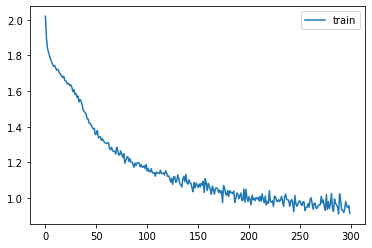

In [86]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.88764   0.66387   0.75962       119
          B2    0.57500   0.36220   0.44444       127
          B1    0.55000   0.30556   0.39286       108
          B0    0.77419   0.55814   0.64865       129
          S0    0.87143   0.46565   0.60697       131
          S1    0.63415   0.23009   0.33766       113
          S2    0.64179   0.55484   0.59516       155
          S3    0.80645   0.64103   0.71429       117

   micro avg    0.72424   0.47848   0.57625       999
   macro avg    0.71758   0.47267   0.56245       999
weighted avg    0.71829   0.47848   0.56700       999
 samples avg    0.47848   0.47848   0.47848       999

Confusion matrix, without normalization
[[89 30  0  0  0  0  0  0]
 [55 46 25  1  0  0  0  0]
 [58  4 33 13  0  0  0  0]
 [49  0  2 72  5  1  0  0]
 [59  0  0  6 61  5  0  0]
 [59  0  0  1  3 26 24  0]
 [42  0  0  0  0  9 8

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


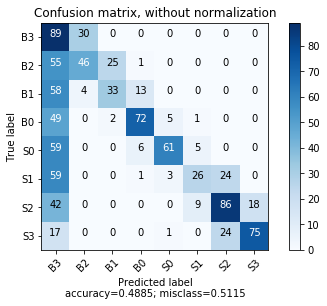

[1, 2, 5, 2, 4, 6, 2, 3, 3, 2, 4, 4, 1, 6, 0, 6, 1, 5, 3, 6, 6, 0, 7, 3, 6, 4, 3, 5, 6, 1, 4, 2, 4, 5, 3, 4, 7, 6, 3, 0, 0, 2, 4, 1, 6, 0, 6, 5, 0, 3, 5, 6, 6, 6, 2, 7, 6, 5, 4, 1, 4, 0, 4, 6, 2, 0, 4, 0, 6, 2, 0, 3, 6, 0, 5, 1, 6, 1, 5, 5, 1, 5, 3, 4, 5, 0, 4, 6, 2, 3, 2, 6, 7, 6, 6, 4, 7, 3, 1, 0, 1, 7, 1, 6, 3, 1, 7, 3, 4, 0, 4, 1, 7, 6, 2, 5, 6, 7, 1, 6, 4, 3, 4, 1, 1, 6, 4, 4, 4, 0, 7, 3, 1, 2, 2, 6, 7, 0, 6, 3, 2, 6, 0, 0, 2, 0, 6, 4, 6, 5, 0, 6, 6, 2, 0, 0, 3, 0, 6, 5, 7, 6, 4, 7, 3, 6, 6, 3, 2, 0, 5, 0, 6, 1, 3, 5, 7, 1, 1, 6, 6, 4, 6, 5, 1, 4, 3, 7, 3, 3, 1, 6, 2, 4, 5, 1, 7, 6, 3, 6, 5, 2, 3, 7, 1, 3, 0, 3, 1, 7, 0, 5, 5, 3, 5, 3, 5, 5, 6, 5, 1, 0, 0, 7, 6, 2, 3, 4, 7, 1, 3, 6, 7, 1, 4, 5, 2, 4, 6, 2, 4, 7, 1, 5, 1, 4, 0, 2, 5, 6, 0, 3, 2, 4, 0, 6, 5, 5, 1, 4, 6, 4, 4, 1, 2, 1, 1, 1, 4, 4, 5, 0, 1, 3, 0, 5, 3, 3, 1, 2, 2, 7, 5, 2, 0, 6, 7, 6, 3, 5, 1, 6, 1, 6, 1, 0, 7, 1, 0, 3, 6, 4, 2, 0, 3, 3, 6, 0, 7, 7, 3, 6, 7, 1, 4, 1, 0, 6, 2, 4, 3, 3, 3, 6, 2, 4, 6, 6, 3, 7, 4, 2, 5, 

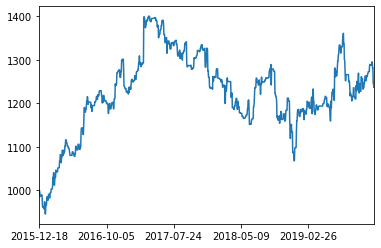

In [87]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 264us/step - loss: 2.0611 - accuracy: 0.2104
Epoch 2/300
3992/3992 [==============================] - 0s 121us/step - loss: 1.8753 - accuracy: 0.2523
Epoch 3/300
3992/3992 [==============================] - 0s 117us/step - loss: 1.8266 - accuracy: 0.2650
Epoch 4/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.8053 - accuracy: 0.2781
Epoch 5/300
3992/3992 [==============================] - 0s 113us/step - loss: 1.7969 - accuracy: 0.2751
Epoch 6/300
3992/3992 [==============================] - 0s 111us/step - loss: 1.7658 - accuracy: 0.2896
Epoch 7/300
3992/3992 [==============================] - 0s 121us/step - loss: 1.7653 - accuracy: 0.2991
Epoch 8/300
3992/3992 [==============================] - 0s 114us/step - loss: 1.7384 - accuracy: 0.3091
Epoch 9/300
3992/3992 [==============================] - 1s 145us/step - loss: 1.7285 - accuracy: 0.3049
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 127us/step - loss: 1.2769 - accuracy: 0.4810
Epoch 79/300
3992/3992 [==============================] - 0s 118us/step - loss: 1.2992 - accuracy: 0.4734
Epoch 80/300
3992/3992 [==============================] - 0s 111us/step - loss: 1.3011 - accuracy: 0.4657
Epoch 81/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.2990 - accuracy: 0.4672
Epoch 82/300
3992/3992 [==============================] - 0s 118us/step - loss: 1.2978 - accuracy: 0.4790
Epoch 83/300
3992/3992 [==============================] - 0s 115us/step - loss: 1.2763 - accuracy: 0.4845
Epoch 84/300
3992/3992 [==============================] - 0s 124us/step - loss: 1.2683 - accuracy: 0.4785
Epoch 85/300
3992/3992 [==============================] - 0s 114us/step - loss: 1.2913 - accuracy: 0.4719
Epoch 86/300
3992/3992 [==============================] - 0s 113us/step - loss: 1.2785 - accuracy: 0.4742
Epoch 87/300
3992/3992 [==============================] - 0

3992/3992 [==============================] - 0s 115us/step - loss: 1.1026 - accuracy: 0.5471
Epoch 155/300
3992/3992 [==============================] - 0s 114us/step - loss: 1.0961 - accuracy: 0.5486
Epoch 156/300
3992/3992 [==============================] - 1s 128us/step - loss: 1.1051 - accuracy: 0.5446
Epoch 157/300
3992/3992 [==============================] - 0s 115us/step - loss: 1.1113 - accuracy: 0.5481
Epoch 158/300
3992/3992 [==============================] - 0s 117us/step - loss: 1.0985 - accuracy: 0.5551
Epoch 159/300
3992/3992 [==============================] - 0s 115us/step - loss: 1.0744 - accuracy: 0.5651
Epoch 160/300
3992/3992 [==============================] - 0s 115us/step - loss: 1.1054 - accuracy: 0.5561
Epoch 161/300
3992/3992 [==============================] - 0s 119us/step - loss: 1.0927 - accuracy: 0.5544
Epoch 162/300
3992/3992 [==============================] - 0s 115us/step - loss: 1.0905 - accuracy: 0.5621
Epoch 163/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 126us/step - loss: 0.9771 - accuracy: 0.6070
Epoch 231/300
3992/3992 [==============================] - 1s 127us/step - loss: 0.9872 - accuracy: 0.5974
Epoch 232/300
3992/3992 [==============================] - 1s 130us/step - loss: 0.9805 - accuracy: 0.5999
Epoch 233/300
3992/3992 [==============================] - 1s 134us/step - loss: 0.9895 - accuracy: 0.5919
Epoch 234/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.9788 - accuracy: 0.6080
Epoch 235/300
3992/3992 [==============================] - 1s 133us/step - loss: 1.0016 - accuracy: 0.5994
Epoch 236/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.9850 - accuracy: 0.5962
Epoch 237/300
3992/3992 [==============================] - 1s 132us/step - loss: 1.0030 - accuracy: 0.5994
Epoch 238/300
3992/3992 [==============================] - 1s 130us/step - loss: 0.9694 - accuracy: 0.6225
Epoch 239/300
3992/3992 [==========================

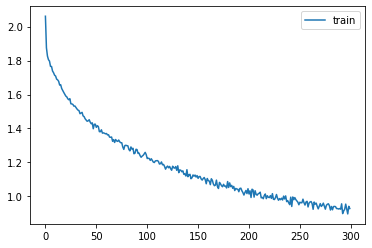

In [88]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.74257   0.63025   0.68182       119
          B2    0.38462   0.15748   0.22346       127
          B1    0.28571   0.07407   0.11765       108
          B0    0.50000   0.28682   0.36453       129
          S0    0.50000   0.19084   0.27624       131
          S1    0.28571   0.08850   0.13514       113
          S2    0.51579   0.31613   0.39200       155
          S3    0.77143   0.46154   0.57754       117

   micro avg    0.55050   0.27828   0.36968       999
   macro avg    0.49823   0.27570   0.34605       999
weighted avg    0.50106   0.27828   0.34939       999
 samples avg    0.27828   0.27828   0.27828       999

Confusion matrix, without normalization
[[97 18  1  3  0  0  0  0]
 [90 20 11  6  0  0  0  0]
 [73 12  8 13  0  1  1  0]
 [74  2  5 37  8  2  1  0]
 [83  0  2 10 25  7  2  2]
 [74  0  1  3 12 10 11  2]
 [77  0  0  1  3 13 4

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


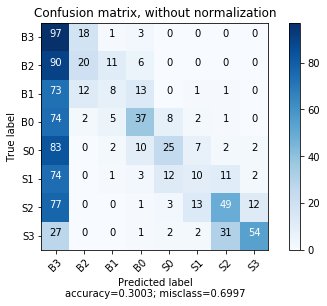

[1, 2, 5, 2, 4, 5, 2, 3, 1, 2, 4, 2, 2, 7, 0, 5, 1, 6, 3, 7, 6, 1, 7, 3, 5, 4, 4, 3, 6, 1, 6, 2, 5, 4, 3, 6, 6, 6, 3, 0, 0, 4, 5, 2, 5, 0, 3, 4, 2, 3, 3, 6, 5, 4, 1, 6, 6, 6, 4, 1, 4, 0, 0, 7, 2, 0, 5, 0, 3, 2, 0, 4, 5, 2, 4, 1, 5, 1, 4, 5, 1, 6, 3, 4, 5, 0, 6, 5, 3, 3, 1, 5, 7, 6, 6, 4, 5, 3, 0, 0, 3, 7, 2, 6, 3, 0, 7, 2, 4, 0, 4, 3, 7, 6, 1, 4, 7, 6, 1, 7, 6, 3, 3, 5, 0, 2, 4, 4, 7, 0, 7, 3, 4, 3, 2, 6, 7, 0, 5, 6, 2, 5, 0, 0, 2, 0, 5, 4, 5, 5, 0, 5, 6, 3, 0, 0, 2, 0, 6, 5, 4, 6, 4, 6, 3, 6, 6, 3, 1, 0, 4, 0, 5, 1, 3, 5, 7, 1, 1, 6, 6, 4, 6, 5, 2, 5, 3, 7, 4, 2, 2, 5, 1, 3, 5, 0, 7, 6, 5, 6, 5, 1, 2, 7, 0, 1, 0, 2, 1, 7, 1, 6, 4, 3, 6, 4, 6, 5, 6, 4, 0, 0, 0, 5, 6, 3, 3, 3, 7, 0, 3, 6, 7, 1, 7, 6, 1, 4, 5, 2, 5, 7, 1, 4, 2, 4, 0, 3, 4, 5, 0, 3, 3, 3, 5, 6, 5, 4, 1, 5, 5, 3, 3, 1, 3, 0, 1, 0, 4, 4, 5, 0, 0, 3, 0, 4, 4, 3, 1, 1, 3, 6, 4, 2, 0, 6, 7, 5, 2, 3, 1, 6, 0, 4, 0, 0, 6, 0, 0, 3, 6, 4, 2, 1, 2, 3, 6, 0, 7, 7, 2, 5, 7, 1, 3, 0, 0, 6, 2, 4, 4, 3, 2, 6, 2, 3, 6, 6, 2, 6, 4, 2, 3, 

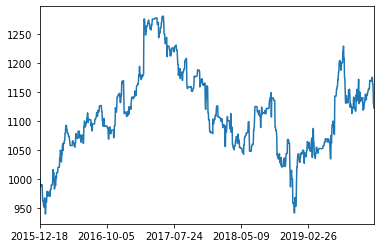

In [89]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 303us/step - loss: 4.0687 - accuracy: 0.1693
Epoch 2/300
3992/3992 [==============================] - 1s 183us/step - loss: 2.0404 - accuracy: 0.1954
Epoch 3/300
3992/3992 [==============================] - 1s 158us/step - loss: 2.0020 - accuracy: 0.2167
Epoch 4/300
3992/3992 [==============================] - 1s 189us/step - loss: 1.9496 - accuracy: 0.2262
Epoch 5/300
3992/3992 [==============================] - 1s 153us/step - loss: 1.9443 - accuracy: 0.2407
Epoch 6/300
3992/3992 [==============================] - 1s 166us/step - loss: 1.9265 - accuracy: 0.2415
Epoch 7/300
3992/3992 [==============================] - 1s 154us/step - loss: 1.8969 - accuracy: 0.2590
Epoch 8/300
3992/3992 [==============================] - 1s 168us/step - loss: 1.8764 - accuracy: 0.2645
Epoch 9/300
3992/3992 [==============================] - 1s 211us/step - loss: 1.8736 - accuracy: 0.26800s - loss:
Epoch 10/300
3992/3992 [=====================

3992/3992 [==============================] - 1s 154us/step - loss: 1.5237 - accuracy: 0.3865
Epoch 78/300
3992/3992 [==============================] - 1s 150us/step - loss: 1.5461 - accuracy: 0.3790
Epoch 79/300
3992/3992 [==============================] - 1s 145us/step - loss: 1.5432 - accuracy: 0.3722
Epoch 80/300
3992/3992 [==============================] - 1s 149us/step - loss: 1.5354 - accuracy: 0.3850
Epoch 81/300
3992/3992 [==============================] - 1s 150us/step - loss: 1.5423 - accuracy: 0.3765
Epoch 82/300
3992/3992 [==============================] - 1s 143us/step - loss: 1.5301 - accuracy: 0.3835
Epoch 83/300
3992/3992 [==============================] - 1s 143us/step - loss: 1.5451 - accuracy: 0.3843
Epoch 84/300
3992/3992 [==============================] - 1s 149us/step - loss: 1.5289 - accuracy: 0.3793
Epoch 85/300
3992/3992 [==============================] - 1s 143us/step - loss: 1.5090 - accuracy: 0.3843
Epoch 86/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 1s 158us/step - loss: 1.4152 - accuracy: 0.4296
Epoch 154/300
3992/3992 [==============================] - 1s 149us/step - loss: 1.3994 - accuracy: 0.4346
Epoch 155/300
3992/3992 [==============================] - 1s 160us/step - loss: 1.4403 - accuracy: 0.4161
Epoch 156/300
3992/3992 [==============================] - 1s 151us/step - loss: 1.4147 - accuracy: 0.4221
Epoch 157/300
3992/3992 [==============================] - 1s 160us/step - loss: 1.4279 - accuracy: 0.4274
Epoch 158/300
3992/3992 [==============================] - 1s 154us/step - loss: 1.4374 - accuracy: 0.4183
Epoch 159/300
3992/3992 [==============================] - 1s 140us/step - loss: 1.3977 - accuracy: 0.4281
Epoch 160/300
3992/3992 [==============================] - 1s 138us/step - loss: 1.4179 - accuracy: 0.4279
Epoch 161/300
3992/3992 [==============================] - 1s 134us/step - loss: 1.4202 - accuracy: 0.4286
Epoch 162/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 172us/step - loss: 1.3556 - accuracy: 0.4589
Epoch 230/300
3992/3992 [==============================] - 1s 150us/step - loss: 1.3630 - accuracy: 0.4489
Epoch 231/300
3992/3992 [==============================] - 1s 159us/step - loss: 1.3433 - accuracy: 0.4549
Epoch 232/300
3992/3992 [==============================] - 1s 143us/step - loss: 1.3535 - accuracy: 0.4466
Epoch 233/300
3992/3992 [==============================] - 1s 158us/step - loss: 1.3599 - accuracy: 0.4454
Epoch 234/300
3992/3992 [==============================] - 1s 150us/step - loss: 1.3292 - accuracy: 0.4652
Epoch 235/300
3992/3992 [==============================] - 1s 140us/step - loss: 1.3564 - accuracy: 0.4474
Epoch 236/300
3992/3992 [==============================] - 1s 155us/step - loss: 1.3449 - accuracy: 0.4592
Epoch 237/300
3992/3992 [==============================] - 1s 147us/step - loss: 1.3375 - accuracy: 0.4564
Epoch 238/300
3992/3992 [==========================

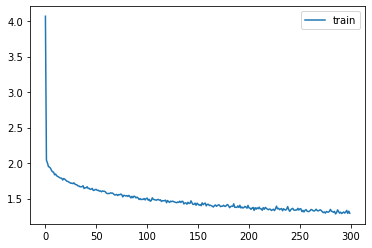

In [90]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.64865   0.40336   0.49741       119
          B2    0.25806   0.06299   0.10127       127
          B1    0.20000   0.00926   0.01770       108
          B0    0.20000   0.00775   0.01493       129
          S0    0.28571   0.03053   0.05517       131
          S1    0.16667   0.00885   0.01681       113
          S2    0.25581   0.07097   0.11111       155
          S3    0.61290   0.32479   0.42458       117

   micro avg    0.46667   0.11211   0.18079       999
   macro avg    0.32848   0.11481   0.15487       999
weighted avg    0.32531   0.11211   0.15207       999
 samples avg    0.11211   0.11211   0.11211       999

Confusion matrix, without normalization
[[111   6   1   0   1   0   0   0]
 [112   8   0   0   1   1   1   4]
 [ 91   8   1   1   2   1   2   2]
 [116   5   1   1   2   1   2   1]
 [110   1   1   1   4   1   7   6]
 [101  

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


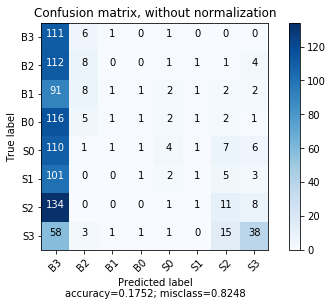

[1, 1, 6, 1, 4, 1, 3, 1, 4, 4, 4, 4, 1, 6, 1, 6, 1, 6, 4, 4, 6, 1, 4, 6, 6, 4, 6, 1, 7, 1, 7, 1, 1, 5, 4, 6, 6, 6, 3, 0, 1, 6, 7, 0, 4, 0, 3, 4, 2, 3, 3, 6, 6, 4, 1, 6, 7, 4, 4, 1, 3, 0, 4, 7, 3, 0, 4, 7, 7, 2, 0, 5, 6, 0, 4, 3, 6, 3, 4, 6, 2, 7, 4, 4, 4, 0, 6, 4, 4, 1, 1, 4, 7, 6, 3, 4, 7, 1, 0, 0, 4, 7, 5, 6, 4, 2, 7, 2, 1, 0, 3, 1, 6, 4, 3, 4, 6, 3, 4, 6, 4, 4, 0, 1, 1, 7, 4, 4, 0, 4, 7, 3, 5, 1, 3, 4, 7, 1, 6, 6, 2, 2, 7, 0, 4, 0, 4, 6, 4, 6, 7, 6, 6, 2, 0, 0, 1, 0, 6, 6, 7, 4, 6, 7, 2, 6, 6, 4, 0, 0, 6, 1, 6, 3, 1, 4, 6, 1, 4, 7, 7, 2, 6, 5, 0, 4, 4, 7, 3, 1, 1, 6, 3, 3, 4, 0, 7, 6, 2, 4, 4, 7, 3, 6, 1, 4, 0, 4, 1, 7, 4, 4, 6, 3, 6, 4, 5, 4, 6, 6, 0, 0, 0, 2, 6, 3, 4, 3, 7, 3, 2, 6, 7, 1, 6, 6, 2, 6, 6, 4, 6, 7, 2, 4, 4, 3, 1, 4, 1, 6, 1, 1, 6, 3, 7, 6, 5, 6, 2, 7, 6, 6, 6, 0, 4, 1, 1, 2, 6, 5, 3, 1, 6, 3, 1, 4, 6, 4, 1, 1, 1, 6, 0, 4, 0, 6, 7, 4, 4, 6, 3, 6, 1, 3, 1, 0, 7, 1, 0, 3, 6, 6, 3, 0, 6, 0, 4, 0, 7, 1, 4, 4, 7, 1, 4, 0, 0, 6, 1, 4, 4, 1, 4, 3, 3, 4, 2, 4, 4, 6, 3, 1, 3, 

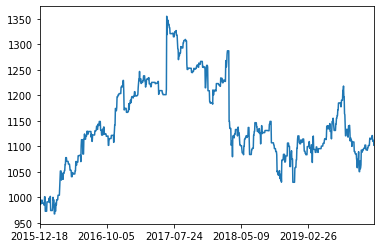

In [91]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 4s 1ms/step - loss: 0.6602 - accuracy: 0.6114
Epoch 2/300
3999/3999 [==============================] - 1s 225us/step - loss: 0.6507 - accuracy: 0.6229
Epoch 3/300
3999/3999 [==============================] - 1s 224us/step - loss: 0.6490 - accuracy: 0.6274
Epoch 4/300
3999/3999 [==============================] - 1s 230us/step - loss: 0.6459 - accuracy: 0.6284
Epoch 5/300
3999/3999 [==============================] - 1s 223us/step - loss: 0.6418 - accuracy: 0.6359
Epoch 6/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.6356 - accuracy: 0.6449
Epoch 7/300
3999/3999 [==============================] - 1s 228us/step - loss: 0.6262 - accuracy: 0.6534
Epoch 8/300
3999/3999 [==============================] - 1s 218us/step - loss: 0.6124 - accuracy: 0.6657
Epoch 9/300
3999/3999 [==============================] - 1s 217us/step - loss: 0.5985 - accuracy: 0.6859
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 277us/step - loss: 0.5183 - accuracy: 0.7507
Epoch 78/300
3999/3999 [==============================] - 1s 294us/step - loss: 0.5108 - accuracy: 0.7644
Epoch 79/300
3999/3999 [==============================] - 1s 367us/step - loss: 0.5092 - accuracy: 0.7604
Epoch 80/300
3999/3999 [==============================] - 1s 323us/step - loss: 0.5120 - accuracy: 0.7592
Epoch 81/300
3999/3999 [==============================] - 1s 277us/step - loss: 0.5093 - accuracy: 0.7602
Epoch 82/300
3999/3999 [==============================] - 1s 306us/step - loss: 0.5109 - accuracy: 0.7542
Epoch 83/300
3999/3999 [==============================] - 1s 345us/step - loss: 0.5121 - accuracy: 0.7569
Epoch 84/300
3999/3999 [==============================] - 2s 427us/step - loss: 0.5114 - accuracy: 0.7604
Epoch 85/300
3999/3999 [==============================] - 1s 314us/step - loss: 0.5130 - accuracy: 0.7554
Epoch 86/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 244us/step - loss: 0.5067 - accuracy: 0.7614
Epoch 154/300
3999/3999 [==============================] - 1s 223us/step - loss: 0.5055 - accuracy: 0.7604
Epoch 155/300
3999/3999 [==============================] - 1s 219us/step - loss: 0.5037 - accuracy: 0.7612
Epoch 156/300
3999/3999 [==============================] - 1s 288us/step - loss: 0.5041 - accuracy: 0.7602
Epoch 157/300
3999/3999 [==============================] - 1s 307us/step - loss: 0.5066 - accuracy: 0.7632
Epoch 158/300
3999/3999 [==============================] - 1s 232us/step - loss: 0.5048 - accuracy: 0.7649
Epoch 159/300
3999/3999 [==============================] - 1s 211us/step - loss: 0.5049 - accuracy: 0.7642
Epoch 160/300
3999/3999 [==============================] - 1s 207us/step - loss: 0.5065 - accuracy: 0.7604
Epoch 161/300
3999/3999 [==============================] - 1s 208us/step - loss: 0.5086 - accuracy: 0.7557
Epoch 162/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 197us/step - loss: 0.5029 - accuracy: 0.7592
Epoch 230/300
3999/3999 [==============================] - 1s 186us/step - loss: 0.5008 - accuracy: 0.7609
Epoch 231/300
3999/3999 [==============================] - 1s 239us/step - loss: 0.5007 - accuracy: 0.7667
Epoch 232/300
3999/3999 [==============================] - 1s 215us/step - loss: 0.5049 - accuracy: 0.7564
Epoch 233/300
3999/3999 [==============================] - 1s 215us/step - loss: 0.5039 - accuracy: 0.7609
Epoch 234/300
3999/3999 [==============================] - 1s 215us/step - loss: 0.5015 - accuracy: 0.7627
Epoch 235/300
3999/3999 [==============================] - 1s 211us/step - loss: 0.5003 - accuracy: 0.7629
Epoch 236/300
3999/3999 [==============================] - 1s 266us/step - loss: 0.5032 - accuracy: 0.7634
Epoch 237/300
3999/3999 [==============================] - 1s 276us/step - loss: 0.5056 - accuracy: 0.7559
Epoch 238/300
3999/3999 [==========================

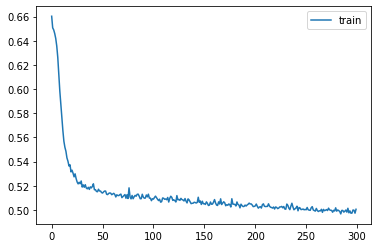

In [92]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.70370   0.90642   0.79230       545
           B    0.82886   0.54286   0.65604       455

    accuracy                        0.74100      1000
   macro avg    0.76628   0.72464   0.72417      1000
weighted avg    0.76065   0.74100   0.73030      1000

Confusion matrix, without normalization
[[494  51]
 [208 247]]


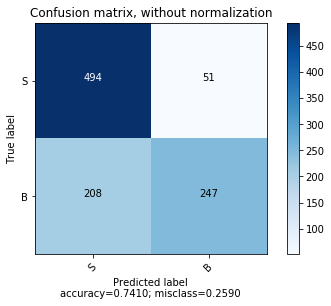

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

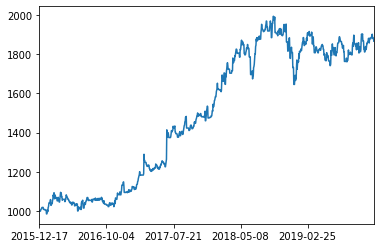

In [93]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 6s 2ms/step - loss: 0.6525 - accuracy: 0.6239
Epoch 2/300
3999/3999 [==============================] - 1s 243us/step - loss: 0.6424 - accuracy: 0.6362
Epoch 3/300
3999/3999 [==============================] - 1s 258us/step - loss: 0.6329 - accuracy: 0.6462
Epoch 4/300
3999/3999 [==============================] - 1s 262us/step - loss: 0.6080 - accuracy: 0.6704
Epoch 5/300
3999/3999 [==============================] - 1s 265us/step - loss: 0.5501 - accuracy: 0.7334
Epoch 6/300
3999/3999 [==============================] - 1s 262us/step - loss: 0.4828 - accuracy: 0.7872
Epoch 7/300
3999/3999 [==============================] - 1s 318us/step - loss: 0.4207 - accuracy: 0.8325
Epoch 8/300
3999/3999 [==============================] - 2s 431us/step - loss: 0.3892 - accuracy: 0.8432
Epoch 9/300
3999/3999 [==============================] - 1s 332us/step - loss: 0.3595 - accuracy: 0.8610
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 340us/step - loss: 0.0904 - accuracy: 0.9682
Epoch 79/300
3999/3999 [==============================] - 1s 321us/step - loss: 0.0897 - accuracy: 0.9692
Epoch 80/300
3999/3999 [==============================] - 1s 251us/step - loss: 0.0926 - accuracy: 0.9650
Epoch 81/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.0857 - accuracy: 0.9750
Epoch 82/300
3999/3999 [==============================] - 2s 392us/step - loss: 0.0798 - accuracy: 0.9727
Epoch 83/300
3999/3999 [==============================] - 1s 276us/step - loss: 0.0871 - accuracy: 0.9667
Epoch 84/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.0776 - accuracy: 0.9765
Epoch 85/300
3999/3999 [==============================] - 1s 315us/step - loss: 0.0908 - accuracy: 0.9657
Epoch 86/300
3999/3999 [==============================] - 1s 332us/step - loss: 0.0820 - accuracy: 0.9765
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 272us/step - loss: 0.0739 - accuracy: 0.9722
Epoch 155/300
3999/3999 [==============================] - 1s 272us/step - loss: 0.0617 - accuracy: 0.9795
Epoch 156/300
3999/3999 [==============================] - 1s 290us/step - loss: 0.0631 - accuracy: 0.9772
Epoch 157/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.0562 - accuracy: 0.9802
Epoch 158/300
3999/3999 [==============================] - 1s 304us/step - loss: 0.0614 - accuracy: 0.9757
Epoch 159/300
3999/3999 [==============================] - 1s 286us/step - loss: 0.0614 - accuracy: 0.9790
Epoch 160/300
3999/3999 [==============================] - 1s 272us/step - loss: 0.0566 - accuracy: 0.9822
Epoch 161/300
3999/3999 [==============================] - 1s 301us/step - loss: 0.0614 - accuracy: 0.9772
Epoch 162/300
3999/3999 [==============================] - 1s 244us/step - loss: 0.0694 - accuracy: 0.9727
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 213us/step - loss: 0.0461 - accuracy: 0.9850
Epoch 231/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.0470 - accuracy: 0.9835
Epoch 232/300
3999/3999 [==============================] - 1s 267us/step - loss: 0.0569 - accuracy: 0.9790
Epoch 233/300
3999/3999 [==============================] - 1s 305us/step - loss: 0.0544 - accuracy: 0.9780
Epoch 234/300
3999/3999 [==============================] - 1s 324us/step - loss: 0.0503 - accuracy: 0.9802
Epoch 235/300
3999/3999 [==============================] - 4s 886us/step - loss: 0.0445 - accuracy: 0.9862
Epoch 236/300
3999/3999 [==============================] - 2s 562us/step - loss: 0.0568 - accuracy: 0.9772
Epoch 237/300
3999/3999 [==============================] - 2s 418us/step - loss: 0.0510 - accuracy: 0.9817
Epoch 238/300
3999/3999 [==============================] - 2s 468us/step - loss: 0.0510 - accuracy: 0.9787
Epoch 239/300
3999/3999 [==========================

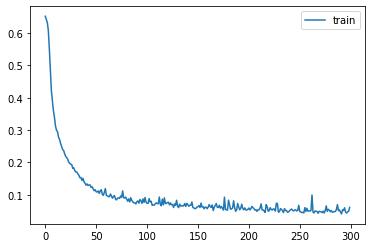

In [94]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.96263   0.99266   0.97742       545
           B    0.99087   0.95385   0.97200       455

    accuracy                        0.97500      1000
   macro avg    0.97675   0.97325   0.97471      1000
weighted avg    0.97548   0.97500   0.97495      1000

Confusion matrix, without normalization
[[541   4]
 [ 21 434]]


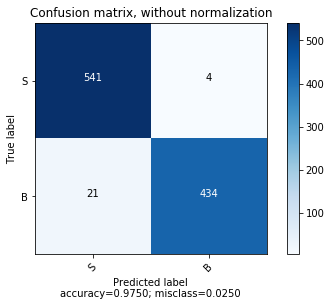

[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 

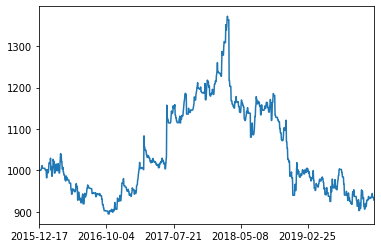

In [95]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 5s 1ms/step - loss: 0.5834 - accuracy: 0.6922
Epoch 2/300
3999/3999 [==============================] - 2s 394us/step - loss: 0.4967 - accuracy: 0.7732
Epoch 3/300
3999/3999 [==============================] - 1s 351us/step - loss: 0.4616 - accuracy: 0.7952
Epoch 4/300
3999/3999 [==============================] - 2s 380us/step - loss: 0.4380 - accuracy: 0.8170
Epoch 5/300
3999/3999 [==============================] - 1s 284us/step - loss: 0.4217 - accuracy: 0.8192
Epoch 6/300
3999/3999 [==============================] - 1s 310us/step - loss: 0.4133 - accuracy: 0.8197
Epoch 7/300
3999/3999 [==============================] - 1s 275us/step - loss: 0.3885 - accuracy: 0.8347
Epoch 8/300
3999/3999 [==============================] - 1s 307us/step - loss: 0.3770 - accuracy: 0.8392
Epoch 9/300
3999/3999 [==============================] - 1s 259us/step - loss: 0.3548 - accuracy: 0.8485
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 267us/step - loss: 0.1024 - accuracy: 0.9580
Epoch 79/300
3999/3999 [==============================] - 1s 307us/step - loss: 0.0904 - accuracy: 0.9642
Epoch 80/300
3999/3999 [==============================] - 1s 286us/step - loss: 0.0895 - accuracy: 0.9682
Epoch 81/300
3999/3999 [==============================] - 2s 433us/step - loss: 0.0851 - accuracy: 0.9697
Epoch 82/300
3999/3999 [==============================] - 2s 401us/step - loss: 0.0813 - accuracy: 0.9715
Epoch 83/300
3999/3999 [==============================] - 2s 441us/step - loss: 0.0867 - accuracy: 0.9672
Epoch 84/300
3999/3999 [==============================] - 1s 357us/step - loss: 0.0907 - accuracy: 0.9647
Epoch 85/300
3999/3999 [==============================] - 1s 259us/step - loss: 0.0904 - accuracy: 0.9662
Epoch 86/300
3999/3999 [==============================] - 1s 340us/step - loss: 0.0883 - accuracy: 0.9685
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 330us/step - loss: 0.0577 - accuracy: 0.9775
Epoch 155/300
3999/3999 [==============================] - 1s 334us/step - loss: 0.0635 - accuracy: 0.9767
Epoch 156/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.0807 - accuracy: 0.9650
Epoch 157/300
3999/3999 [==============================] - 1s 325us/step - loss: 0.0802 - accuracy: 0.9692
Epoch 158/300
3999/3999 [==============================] - 1s 290us/step - loss: 0.0748 - accuracy: 0.9730
Epoch 159/300
3999/3999 [==============================] - 1s 336us/step - loss: 0.0696 - accuracy: 0.9747
Epoch 160/300
3999/3999 [==============================] - 1s 338us/step - loss: 0.0596 - accuracy: 0.9767
Epoch 161/300
3999/3999 [==============================] - 1s 306us/step - loss: 0.0642 - accuracy: 0.9750
Epoch 162/300
3999/3999 [==============================] - 1s 311us/step - loss: 0.0557 - accuracy: 0.9810
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 216us/step - loss: 0.0638 - accuracy: 0.9747
Epoch 231/300
3999/3999 [==============================] - 1s 207us/step - loss: 0.0465 - accuracy: 0.9855
Epoch 232/300
3999/3999 [==============================] - 1s 206us/step - loss: 0.0481 - accuracy: 0.9837
Epoch 233/300
3999/3999 [==============================] - 1s 214us/step - loss: 0.0463 - accuracy: 0.9825
Epoch 234/300
3999/3999 [==============================] - 1s 217us/step - loss: 0.0484 - accuracy: 0.9810
Epoch 235/300
3999/3999 [==============================] - 1s 310us/step - loss: 0.0639 - accuracy: 0.9725
Epoch 236/300
3999/3999 [==============================] - 1s 285us/step - loss: 0.0380 - accuracy: 0.9885
Epoch 237/300
3999/3999 [==============================] - 1s 268us/step - loss: 0.0465 - accuracy: 0.9817
Epoch 238/300
3999/3999 [==============================] - 1s 241us/step - loss: 0.0436 - accuracy: 0.9855
Epoch 239/300
3999/3999 [==========================

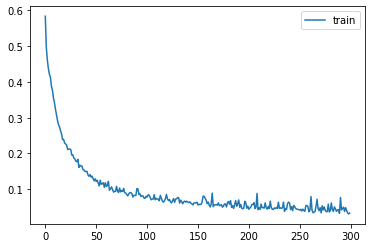

In [96]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    1.00000   0.88991   0.94175       545
           B    0.88350   1.00000   0.93814       455

    accuracy                        0.94000      1000
   macro avg    0.94175   0.94495   0.93995      1000
weighted avg    0.94699   0.94000   0.94011      1000

Confusion matrix, without normalization
[[485  60]
 [  0 455]]


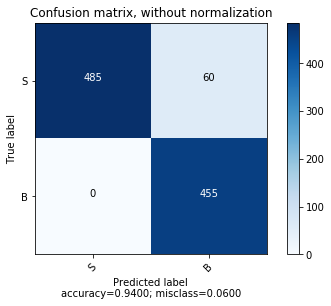

[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 

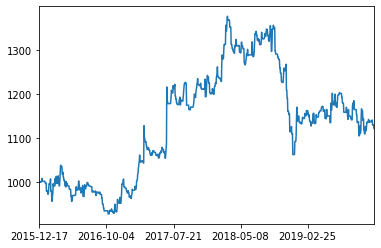

In [97]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 9s 2ms/step - loss: 0.6651 - accuracy: 0.6369
Epoch 2/300
3999/3999 [==============================] - 2s 385us/step - loss: 0.5777 - accuracy: 0.7024
Epoch 3/300
3999/3999 [==============================] - 1s 365us/step - loss: 0.5194 - accuracy: 0.7497
Epoch 4/300
3999/3999 [==============================] - 2s 403us/step - loss: 0.4677 - accuracy: 0.7974
Epoch 5/300
3999/3999 [==============================] - 2s 499us/step - loss: 0.4357 - accuracy: 0.8130
Epoch 6/300
3999/3999 [==============================] - 2s 454us/step - loss: 0.3890 - accuracy: 0.8452
Epoch 7/300
3999/3999 [==============================] - 2s 493us/step - loss: 0.3871 - accuracy: 0.8470
Epoch 8/300
3999/3999 [==============================] - 2s 396us/step - loss: 0.3502 - accuracy: 0.8572
Epoch 9/300
3999/3999 [==============================] - 2s 399us/step - loss: 0.3259 - accuracy: 0.8737
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 355us/step - loss: 0.0665 - accuracy: 0.9782
Epoch 79/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.0349 - accuracy: 0.9887
Epoch 80/300
3999/3999 [==============================] - 1s 370us/step - loss: 0.0795 - accuracy: 0.9727
Epoch 81/300
3999/3999 [==============================] - 2s 388us/step - loss: 0.0422 - accuracy: 0.9872
Epoch 82/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.0435 - accuracy: 0.9847
Epoch 83/300
3999/3999 [==============================] - 2s 386us/step - loss: 0.0900 - accuracy: 0.9690
Epoch 84/300
3999/3999 [==============================] - 1s 277us/step - loss: 0.0795 - accuracy: 0.9750
Epoch 85/300
3999/3999 [==============================] - 1s 375us/step - loss: 0.0441 - accuracy: 0.9887
Epoch 86/300
3999/3999 [==============================] - 2s 395us/step - loss: 0.0374 - accuracy: 0.9885
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 2s 443us/step - loss: 0.0671 - accuracy: 0.9770
Epoch 155/300
3999/3999 [==============================] - 2s 572us/step - loss: 0.0375 - accuracy: 0.9880
Epoch 156/300
3999/3999 [==============================] - 1s 354us/step - loss: 0.0452 - accuracy: 0.9855
Epoch 157/300
3999/3999 [==============================] - 1s 294us/step - loss: 0.0290 - accuracy: 0.9902
Epoch 158/300
3999/3999 [==============================] - 1s 345us/step - loss: 0.0162 - accuracy: 0.9962
Epoch 159/300
3999/3999 [==============================] - 1s 335us/step - loss: 0.0284 - accuracy: 0.9915
Epoch 160/300
3999/3999 [==============================] - 1s 337us/step - loss: 0.0234 - accuracy: 0.9930
Epoch 161/300
3999/3999 [==============================] - 1s 297us/step - loss: 0.0538 - accuracy: 0.9855
Epoch 162/300
3999/3999 [==============================] - 2s 422us/step - loss: 0.0435 - accuracy: 0.9832
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 272us/step - loss: 0.0319 - accuracy: 0.9895
Epoch 231/300
3999/3999 [==============================] - 1s 263us/step - loss: 0.0208 - accuracy: 0.9930
Epoch 232/300
3999/3999 [==============================] - 1s 264us/step - loss: 0.0307 - accuracy: 0.9927
Epoch 233/300
3999/3999 [==============================] - 1s 249us/step - loss: 0.0238 - accuracy: 0.9915
Epoch 234/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.0238 - accuracy: 0.9922
Epoch 235/300
3999/3999 [==============================] - 1s 236us/step - loss: 0.0142 - accuracy: 0.9967
Epoch 236/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.0074 - accuracy: 0.9982
Epoch 237/300
3999/3999 [==============================] - 1s 236us/step - loss: 0.0172 - accuracy: 0.9947
Epoch 238/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.0712 - accuracy: 0.9802
Epoch 239/300
3999/3999 [==========================

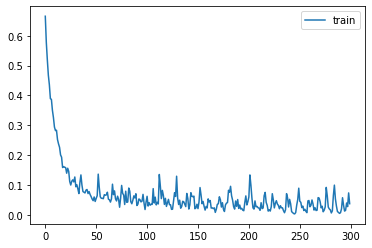

In [98]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.91053   0.63486   0.74811       545
           B    0.67903   0.92527   0.78326       455

    accuracy                        0.76700      1000
   macro avg    0.79478   0.78007   0.76568      1000
weighted avg    0.80520   0.76700   0.76410      1000

Confusion matrix, without normalization
[[346 199]
 [ 34 421]]


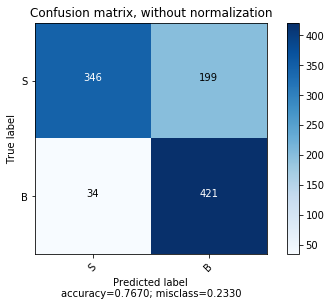

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 

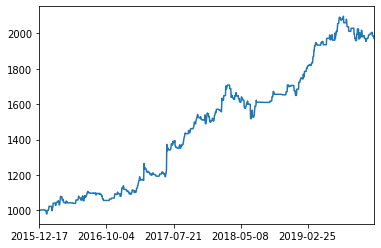

In [99]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 10s 3ms/step - loss: 0.6258 - accuracy: 0.6587
Epoch 2/300
3996/3996 [==============================] - 3s 635us/step - loss: 0.5424 - accuracy: 0.7345
Epoch 3/300
3996/3996 [==============================] - 3s 686us/step - loss: 0.5111 - accuracy: 0.7543
Epoch 4/300
3996/3996 [==============================] - 2s 503us/step - loss: 0.5011 - accuracy: 0.7630
Epoch 5/300
3996/3996 [==============================] - 2s 550us/step - loss: 0.4959 - accuracy: 0.7655
Epoch 6/300
3996/3996 [==============================] - 2s 577us/step - loss: 0.4908 - accuracy: 0.7660
Epoch 7/300
3996/3996 [==============================] - 3s 637us/step - loss: 0.4890 - accuracy: 0.7645
Epoch 8/300
3996/3996 [==============================] - 2s 419us/step - loss: 0.4849 - accuracy: 0.7723
Epoch 9/300
3996/3996 [==============================] - 3s 628us/step - loss: 0.4805 - accuracy: 0.7735
Epoch 10/300
3996/3996 [==============================] 

3996/3996 [==============================] - 2s 496us/step - loss: 0.3974 - accuracy: 0.8206
Epoch 79/300
3996/3996 [==============================] - 2s 425us/step - loss: 0.3965 - accuracy: 0.8178
Epoch 80/300
3996/3996 [==============================] - 2s 480us/step - loss: 0.3948 - accuracy: 0.8196
Epoch 81/300
3996/3996 [==============================] - 2s 433us/step - loss: 0.3970 - accuracy: 0.8161
Epoch 82/300
3996/3996 [==============================] - 2s 424us/step - loss: 0.3956 - accuracy: 0.8178
Epoch 83/300
3996/3996 [==============================] - 2s 432us/step - loss: 0.3933 - accuracy: 0.8223
Epoch 84/300
3996/3996 [==============================] - 2s 408us/step - loss: 0.3929 - accuracy: 0.8218
Epoch 85/300
3996/3996 [==============================] - 2s 471us/step - loss: 0.3942 - accuracy: 0.8221
Epoch 86/300
3996/3996 [==============================] - 2s 522us/step - loss: 0.3903 - accuracy: 0.8226
Epoch 87/300
3996/3996 [==============================] - 2

3996/3996 [==============================] - 3s 632us/step - loss: 0.3517 - accuracy: 0.8406
Epoch 155/300
3996/3996 [==============================] - 2s 573us/step - loss: 0.3530 - accuracy: 0.8451
Epoch 156/300
3996/3996 [==============================] - 2s 533us/step - loss: 0.3482 - accuracy: 0.8458
Epoch 157/300
3996/3996 [==============================] - 2s 486us/step - loss: 0.3500 - accuracy: 0.8418
Epoch 158/300
3996/3996 [==============================] - 2s 512us/step - loss: 0.3511 - accuracy: 0.8413
Epoch 159/300
3996/3996 [==============================] - 3s 631us/step - loss: 0.3510 - accuracy: 0.8378
Epoch 160/300
3996/3996 [==============================] - 2s 484us/step - loss: 0.3512 - accuracy: 0.8468
Epoch 161/300
3996/3996 [==============================] - 2s 480us/step - loss: 0.3559 - accuracy: 0.8351
Epoch 162/300
3996/3996 [==============================] - 2s 441us/step - loss: 0.3467 - accuracy: 0.8416
Epoch 163/300
3996/3996 [==========================

3996/3996 [==============================] - 2s 448us/step - loss: 0.3072 - accuracy: 0.8661
Epoch 231/300
3996/3996 [==============================] - 2s 386us/step - loss: 0.3079 - accuracy: 0.8664
Epoch 232/300
3996/3996 [==============================] - 2s 395us/step - loss: 0.3070 - accuracy: 0.8641
Epoch 233/300
3996/3996 [==============================] - 2s 406us/step - loss: 0.3365 - accuracy: 0.8626
Epoch 234/300
3996/3996 [==============================] - 2s 418us/step - loss: 0.3046 - accuracy: 0.8669
Epoch 235/300
3996/3996 [==============================] - 2s 483us/step - loss: 0.3059 - accuracy: 0.8674
Epoch 236/300
3996/3996 [==============================] - 2s 397us/step - loss: 0.3049 - accuracy: 0.8689
Epoch 237/300
3996/3996 [==============================] - 1s 331us/step - loss: 0.3029 - accuracy: 0.8654
Epoch 238/300
3996/3996 [==============================] - 2s 384us/step - loss: 0.3005 - accuracy: 0.8679
Epoch 239/300
3996/3996 [==========================

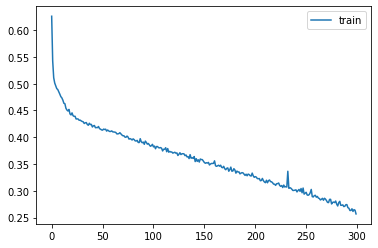

In [100]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.73860   0.77248   0.75516       545
           B    0.71163   0.67253   0.69153       455

    accuracy                        0.72700      1000
   macro avg    0.72511   0.72250   0.72334      1000
weighted avg    0.72633   0.72700   0.72620      1000

Confusion matrix, without normalization
[[421 124]
 [149 306]]


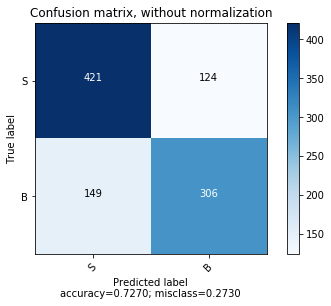

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 

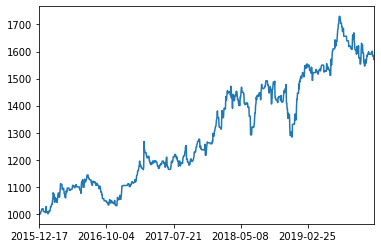

In [101]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 23s 6ms/step - loss: 0.6384 - accuracy: 0.6316
Epoch 2/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.5187 - accuracy: 0.7628
Epoch 3/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.4691 - accuracy: 0.7803
Epoch 4/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.4185 - accuracy: 0.8073
Epoch 5/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.3664 - accuracy: 0.8286
Epoch 6/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.3334 - accuracy: 0.8506
Epoch 7/300
3996/3996 [==============================] - 4s 890us/step - loss: 0.2911 - accuracy: 0.8816
Epoch 8/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.2701 - accuracy: 0.8884
Epoch 9/300
3996/3996 [==============================] - 4s 940us/step - loss: 0.2362 - accuracy: 0.9044
Epoch 10/300
3996/3996 [==============================] - 4s 1ms/ste

3996/3996 [==============================] - 3s 668us/step - loss: 0.0611 - accuracy: 0.9772
Epoch 79/300
3996/3996 [==============================] - 3s 632us/step - loss: 0.0689 - accuracy: 0.9715
Epoch 80/300
3996/3996 [==============================] - 3s 650us/step - loss: 0.0636 - accuracy: 0.9735
Epoch 81/300
3996/3996 [==============================] - 3s 634us/step - loss: 0.0665 - accuracy: 0.9772
Epoch 82/300
3996/3996 [==============================] - 3s 664us/step - loss: 0.0740 - accuracy: 0.9727
Epoch 83/300
3996/3996 [==============================] - 3s 636us/step - loss: 0.0562 - accuracy: 0.9810
Epoch 84/300
3996/3996 [==============================] - 3s 641us/step - loss: 0.0665 - accuracy: 0.9715
Epoch 85/300
3996/3996 [==============================] - 3s 643us/step - loss: 0.0733 - accuracy: 0.9710
Epoch 86/300
3996/3996 [==============================] - 3s 653us/step - loss: 0.0576 - accuracy: 0.9812
Epoch 87/300
3996/3996 [==============================] - 3

3996/3996 [==============================] - 3s 632us/step - loss: 0.0394 - accuracy: 0.9877
Epoch 155/300
3996/3996 [==============================] - 3s 638us/step - loss: 0.0342 - accuracy: 0.9887
Epoch 156/300
3996/3996 [==============================] - 3s 656us/step - loss: 0.0369 - accuracy: 0.9867
Epoch 157/300
3996/3996 [==============================] - 3s 651us/step - loss: 0.0413 - accuracy: 0.9840
Epoch 158/300
3996/3996 [==============================] - 3s 631us/step - loss: 0.0311 - accuracy: 0.9897
Epoch 159/300
3996/3996 [==============================] - 3s 680us/step - loss: 0.0401 - accuracy: 0.9862
Epoch 160/300
3996/3996 [==============================] - 3s 640us/step - loss: 0.0352 - accuracy: 0.9865
Epoch 161/300
3996/3996 [==============================] - 3s 694us/step - loss: 0.0300 - accuracy: 0.9907
Epoch 162/300
3996/3996 [==============================] - 3s 696us/step - loss: 0.0323 - accuracy: 0.9912
Epoch 163/300
3996/3996 [==========================

3996/3996 [==============================] - 3s 710us/step - loss: 0.0203 - accuracy: 0.9922
Epoch 232/300
3996/3996 [==============================] - 3s 711us/step - loss: 0.0404 - accuracy: 0.9837
Epoch 233/300
3996/3996 [==============================] - 3s 694us/step - loss: 0.0269 - accuracy: 0.9910
Epoch 234/300
3996/3996 [==============================] - 3s 781us/step - loss: 0.0180 - accuracy: 0.9947
Epoch 235/300
3996/3996 [==============================] - 3s 722us/step - loss: 0.0299 - accuracy: 0.9895
Epoch 236/300
3996/3996 [==============================] - 3s 821us/step - loss: 0.0185 - accuracy: 0.9945
Epoch 237/300
3996/3996 [==============================] - 3s 747us/step - loss: 0.0154 - accuracy: 0.9960
Epoch 238/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0158 - accuracy: 0.9952
Epoch 239/300
3996/3996 [==============================] - 3s 836us/step - loss: 0.0278 - accuracy: 0.9900
Epoch 240/300
3996/3996 [============================

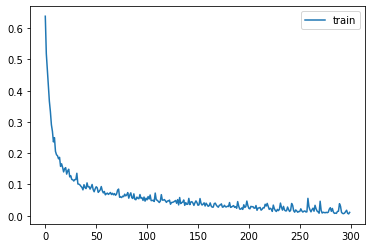

In [102]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.94464   0.97064   0.95747       545
           B    0.96364   0.93187   0.94749       455

    accuracy                        0.95300      1000
   macro avg    0.95414   0.95126   0.95248      1000
weighted avg    0.95328   0.95300   0.95293      1000

Confusion matrix, without normalization
[[529  16]
 [ 31 424]]


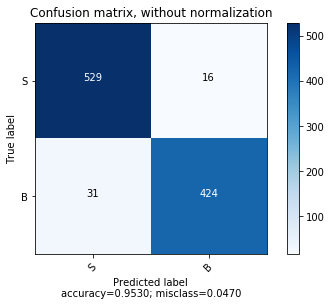

[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 

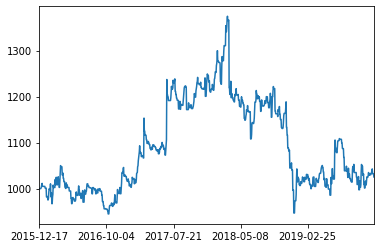

In [103]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 12s 3ms/step - loss: 0.5702 - accuracy: 0.7160
Epoch 2/300
3996/3996 [==============================] - 4s 919us/step - loss: 0.4518 - accuracy: 0.7898
Epoch 3/300
3996/3996 [==============================] - 3s 825us/step - loss: 0.4130 - accuracy: 0.8093
Epoch 4/300
3996/3996 [==============================] - 3s 867us/step - loss: 0.3924 - accuracy: 0.8288
Epoch 5/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.3749 - accuracy: 0.8316
Epoch 6/300
3996/3996 [==============================] - 4s 892us/step - loss: 0.3662 - accuracy: 0.8358
Epoch 7/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.3451 - accuracy: 0.8451
Epoch 8/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.3277 - accuracy: 0.8651
Epoch 9/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.3130 - accuracy: 0.8591
Epoch 10/300
3996/3996 [==============================] - 4s 921

3996/3996 [==============================] - 5s 1ms/step - loss: 0.0467 - accuracy: 0.9852
Epoch 80/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0483 - accuracy: 0.9820
Epoch 81/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0406 - accuracy: 0.9867: 1s - loss: 0
Epoch 82/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0412 - accuracy: 0.9865
Epoch 83/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0428 - accuracy: 0.9837
Epoch 84/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0551 - accuracy: 0.9780
Epoch 85/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0378 - accuracy: 0.9882: 1s - loss:
Epoch 86/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0390 - accuracy: 0.9877
Epoch 87/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0355 - accuracy: 0.9877
Epoch 88/300
3996/3996 [===========================

3996/3996 [==============================] - 6s 1ms/step - loss: 0.0249 - accuracy: 0.9925
Epoch 157/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0230 - accuracy: 0.9937
Epoch 158/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0277 - accuracy: 0.9882
Epoch 159/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0088 - accuracy: 0.9995
Epoch 160/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0056 - accuracy: 0.9995
Epoch 161/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 162/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0036 - accuracy: 0.9997
Epoch 163/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 164/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0162 - accuracy: 0.9952
Epoch 165/300
3996/3996 [==============================] - 4s 1ms/ste

3996/3996 [==============================] - 4s 1ms/step - loss: 0.0090 - accuracy: 0.9987
Epoch 234/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0117 - accuracy: 0.9970
Epoch 235/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 236/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 237/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 238/300
3996/3996 [==============================] - 4s 1ms/step - loss: 9.1916e-04 - accuracy: 1.0000
Epoch 239/300
3996/3996 [==============================] - 4s 1ms/step - loss: 7.4086e-04 - accuracy: 1.0000
Epoch 240/300
3996/3996 [==============================] - 4s 1ms/step - loss: 6.3781e-04 - accuracy: 1.0000
Epoch 241/300
3996/3996 [==============================] - 4s 891us/step - loss: 5.1516e-04 - accuracy: 1.0000
Epoch 242/300
3996/3996 [==========================

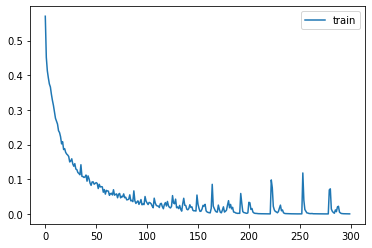

In [104]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.92673   0.85872   0.89143       545
           B    0.84444   0.91868   0.88000       455

    accuracy                        0.88600      1000
   macro avg    0.88559   0.88870   0.88571      1000
weighted avg    0.88929   0.88600   0.88623      1000

Confusion matrix, without normalization
[[468  77]
 [ 37 418]]


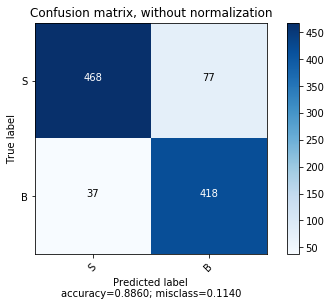

[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 

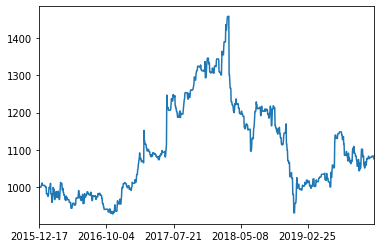

In [105]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 27s 7ms/step - loss: 0.7411 - accuracy: 0.6507
Epoch 2/300
3996/3996 [==============================] - 16s 4ms/step - loss: 0.5555 - accuracy: 0.7230
Epoch 3/300
3996/3996 [==============================] - 14s 3ms/step - loss: 0.5235 - accuracy: 0.7497
Epoch 4/300
3996/3996 [==============================] - 10s 2ms/step - loss: 0.4752 - accuracy: 0.7833
Epoch 5/300
3996/3996 [==============================] - 10s 2ms/step - loss: 0.4275 - accuracy: 0.8076
Epoch 6/300
3996/3996 [==============================] - 10s 3ms/step - loss: 0.3995 - accuracy: 0.8196
Epoch 7/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.3750 - accuracy: 0.8351
Epoch 8/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.3529 - accuracy: 0.8493
Epoch 9/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.3555 - accuracy: 0.8544
Epoch 10/300
3996/3996 [==============================] - 9s 2ms/st

3996/3996 [==============================] - 8s 2ms/step - loss: 0.0500 - accuracy: 0.9832
Epoch 80/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0441 - accuracy: 0.9850
Epoch 81/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0312 - accuracy: 0.9907
Epoch 82/300
3996/3996 [==============================] - 11s 3ms/step - loss: 0.0357 - accuracy: 0.9857
Epoch 83/300
3996/3996 [==============================] - 11s 3ms/step - loss: 0.0359 - accuracy: 0.9895
Epoch 84/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0386 - accuracy: 0.9870
Epoch 85/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0156 - accuracy: 0.9960
Epoch 86/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0438 - accuracy: 0.9860
Epoch 87/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0541 - accuracy: 0.9815
Epoch 88/300
3996/3996 [==============================] - 10s 3ms/step - lo

3996/3996 [==============================] - 7s 2ms/step - loss: 0.0658 - accuracy: 0.9780
Epoch 158/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0289 - accuracy: 0.9925
Epoch 159/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0992 - accuracy: 0.9755
Epoch 160/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0672 - accuracy: 0.9780
Epoch 161/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0600 - accuracy: 0.9812
Epoch 162/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0532 - accuracy: 0.9837
Epoch 163/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0304 - accuracy: 0.9907
Epoch 164/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0275 - accuracy: 0.9925
Epoch 165/300
3996/3996 [==============================] - 10s 3ms/step - loss: 0.0345 - accuracy: 0.9885
Epoch 166/300
3996/3996 [==============================] - 11s 3ms/s

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)